# German Traffic Sign Classifier using a LeNet based Convolutional Network

## Pipeline Approach

In this project, I'm building pipelines to classify the traffic signs from the [German Traffic Sign Benchmarks](http://benchmark.ini.rub.de/?section=gtsrb&subsection=dataset).

I'm using the scikit-learn's pipeline framework in order to train the model with various combinations of transformations and estimators.

The starting model is a convolutional network based on the [LeNet](http://yann.lecun.com/exdb/lenet/) architecture by Yann LeCun.  LeNet was originally designed for handwritten and machine-printed character recognition. 

The project is explained in the following sections.

- Data Exploratory Analysis
- Model Implementation
- Pipeline Implementation
- Preprocessing
- Model Improvement
- Testing and Results

# Data Exploratory Analysis

The traffic sign images were taken from the [German Traffic Sign Benchmarks](http://benchmark.ini.rub.de/?section=gtsrb&subsection=dataset).  

- http://benchmark.ini.rub.de/Dataset/GTSRB_Final_Training_Images.zip
- http://benchmark.ini.rub.de/Dataset/GTSRB_Final_Test_Images.zip
- http://benchmark.ini.rub.de/Dataset/GTSRB_Final_Test_GT.zip

```
> mkdir data

> # use wget or curl 
> wget http://benchmark.ini.rub.de/Dataset/GTSRB_Final_Training_Images.zip
> unzip GTSRB_Final_Training_Images.zip
> mv GTSRB/Final_Training data/

> wget http://benchmark.ini.rub.de/Dataset/GTSRB_Final_Test_Images.zip
> unzip GTSRB_Final_Test_Images.zip
> mv GTSRB/Final_Test/ data/

> wget http://benchmark.ini.rub.de/Dataset/GTSRB_Final_Test_GT.zip
> unzip GTSRB_Final_Test_GT.zip
> mv GT-final_test.csv data/Final_Test/Images/
```

## Training Data Folder Structure

The training images are organized in folders by category.  Each folder is meant for one category (i.e. stop sign) and has a label file (.csv) which is actually semi-colon delimited (not comma delimited).

```
data
 + Final_Training
    + Images
        + 00000
            + 00000_00000.ppm
            + 00000_00001.ppm
            ...    
            + GT-00000.csv
        + 00001
            + 00000_00000.ppm
            + 00000_00001.ppm
            ...    
            + GT-00001.csv
        ...
```

All images are stored in the PPM format ([Portable Pixmap, P6](http://en.wikipedia.org/wiki/Netpbm_format)).  You'll need to install both `matplotlib` and `pillow` to handle such image format.  If you use one of the evironments yml files in this repository, this will be taken care of.

## Import Required Libraries

In [1]:
import glob
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import cv2
import os
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import tensorflow as tf
import tensorflow as tf
from tensorflow.contrib.layers import flatten
from pipeline import NeuralNetwork, make_adam, Session, build_pipeline

matplotlib.style.use('ggplot')
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

## Loading Training Data

All train image paths are combined into one dataframe for convenience.

In [2]:
TRAIN_IMAGE_DIR = 'data/Final_Training/Images'

dfs = []
for train_file in glob.glob(os.path.join(TRAIN_IMAGE_DIR, '*/GT-*.csv')):
    folder = train_file.split('/')[3]
    df = pd.read_csv(train_file, sep=';')
    df['Filename'] = df['Filename'].apply(lambda x: os.path.join(TRAIN_IMAGE_DIR, folder, x))
    dfs.append(df)

In [3]:
train_df = pd.concat(dfs, ignore_index=True)
train_df.head()

Filename  Width  Height  Roi.X1  \
0  data/Final_Training/Images/00000/00000_00000.ppm     29      30       5   
1  data/Final_Training/Images/00000/00000_00001.ppm     30      30       5   
2  data/Final_Training/Images/00000/00000_00002.ppm     30      30       5   
3  data/Final_Training/Images/00000/00000_00003.ppm     31      31       5   
4  data/Final_Training/Images/00000/00000_00004.ppm     30      32       5   

   Roi.Y1  Roi.X2  Roi.Y2  ClassId  
0       6      24      25        0  
1       5      25      25        0  
2       5      25      25        0  
3       5      26      26        0  
4       6      25      26        0

**Annotation format**
- Filename: Filename of corresponding image
- Width: Width of the image
- Height: Height of the image
- ROI.x1: X-coordinate of top-left corner of traffic sign bounding box
- ROI.y1: Y-coordinate of top-left corner of traffic sign bounding box
- ROI.x2: X-coordinate of bottom-right corner of traffic sign bounding box
- ROI.y2: Y-coordinate of bottom-right corner of traffic sign bounding box
- ClassId: Assigned class label

The following points are worth mentioning:
- Image sizes are not fixed
- Sign sizes are not fixed
- Sign's center location is not fixed

Later on, I'll examine sample images to further clarify those points.

## Class Distribution

There are 43 traffic sign classes in 39,209 training images.

In [4]:
N_CLASSES = np.unique(train_df['ClassId']).size  # keep this for later

print("Number of training images : {:>5}".format(train_df.shape[0]))
print("Number of classes         : {:>5}".format(N_CLASSES))

Number of training images : 39209
Number of classes         :    43


The distribution of classes are very skewed.

In [5]:
def show_class_distribution(classIDs, title):
    """
    Plot the traffic sign class distribution
    """
    plt.figure(figsize=(15, 5))
    plt.title('Class ID distribution for {}'.format(title))
    plt.hist(classIDs, bins=N_CLASSES)
    plt.show()

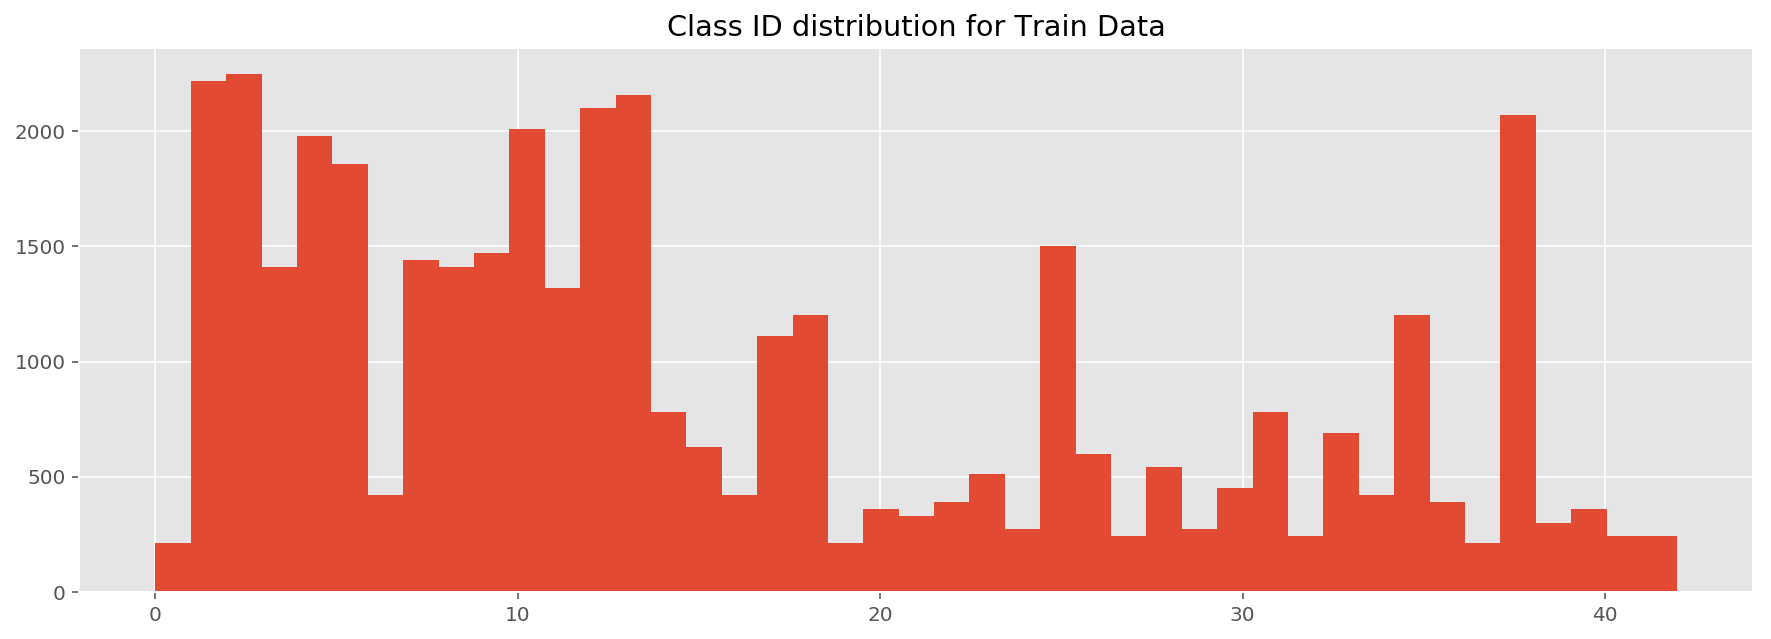

In [6]:
show_class_distribution(train_df['ClassId'], 'Train Data')

The name of each sign are stored in sign_names.csv file.  We can use it see the distribution per sign names.

In [7]:
sign_name_df = pd.read_csv('sign_names.csv', index_col='ClassId')
sign_name_df.head()

SignName
ClassId                      
0        Speed limit (20km/h)
1        Speed limit (30km/h)
2        Speed limit (50km/h)
3        Speed limit (60km/h)
4        Speed limit (70km/h)

In [8]:
sign_name_df['Occurence'] = [sum(train_df['ClassId']==c) for c in range(N_CLASSES)]
sign_name_df.sort_values('Occurence', ascending=False)

SignName  Occurence
ClassId                                                              
2                                     Speed limit (50km/h)       2250
1                                     Speed limit (30km/h)       2220
13                                                   Yield       2160
12                                           Priority road       2100
38                                              Keep right       2070
10            No passing for vehicles over 3.5 metric tons       2010
4                                     Speed limit (70km/h)       1980
5                                     Speed limit (80km/h)       1860
25                                               Road work       1500
9                                               No passing       1470
7                                    Speed limit (100km/h)       1440
3                                     Speed limit (60km/h)       1410
8                                    Speed limit (120km/h)       1410
11                   Right-of-way at the next intersection       1320
35                                              Ahead only       1200
18                                         General caution       1200
17                                                No entry       1110
31                                   Wild animals crossing        780
14                                                    Stop        780
33                                        Turn right ahead        689
15                                             No vehicles        630
26                                         Traffic signals        600
28                                       Children crossing        540
23                                           Slippery road        510
30                                      Beware of ice/snow        450
16                Vehicles over 3.5 metric tons prohibited        420
34                                         Turn left ahead        420
6                              End of speed limit (80km/h)        420
36                                    Go straight or right        390
22                                              Bumpy road        390
40                                    Roundabout mandatory        360
20                            Dangerous curve to the right        360
21                                            Double curve        330
39                                               Keep left        300
29                                       Bicycles crossing        270
24                               Road narrows on the right        270
41                                       End of no passing        240
42       End of no passing by vehicles over 3.5 metric ...        240
32                     End of all speed and passing limits        240
27                                             Pedestrians        240
37                                     Go straight or left        210
19                             Dangerous curve to the left        210
0                                     Speed limit (20km/h)        210

The following constant is defined for later use.

In [9]:
SIGN_NAMES = sign_name_df.SignName.values
SIGN_NAMES[2]

'Speed limit (50km/h)'

## Sample Images

Let's examine some random images:

In [10]:
def load_image(image_file):
    """
    Read image file into numpy array (RGB)
    """
    return plt.imread(image_file)

In [11]:
def get_samples(image_data, num_samples, class_id=None):
    """
    Randomly select image filenames and their class IDs
    """
    if class_id is not None:
        image_data = image_data[image_data['ClassId']==class_id]
    indices = np.random.choice(image_data.shape[0], size=num_samples, replace=False)
    return image_data.iloc[indices][['Filename', 'ClassId']].values

In [12]:
def show_images(image_data, cols=5, sign_names=None, show_shape=False, func=None):
    """
    Given a list of image file paths, load images and show them.
    """
    num_images = len(image_data)
    rows = num_images//cols
    plt.figure(figsize=(cols*3,rows*2.5))
    for i, (image_file, label) in enumerate(image_data):
        image = load_image(image_file)
        if func is not None:
            image = func(image)
        plt.subplot(rows, cols, i+1)
        plt.imshow(image)
        if sign_names is not None:
            plt.text(0, 0, '{}: {}'.format(label, sign_names[label]), color='k',backgroundcolor='c', fontsize=8)        
        if show_shape:
            plt.text(0, image.shape[0], '{}'.format(image.shape), color='k',backgroundcolor='y', fontsize=8)        
        plt.xticks([])
        plt.yticks([])
    plt.show()

The below are 20 random sample images from the train set.

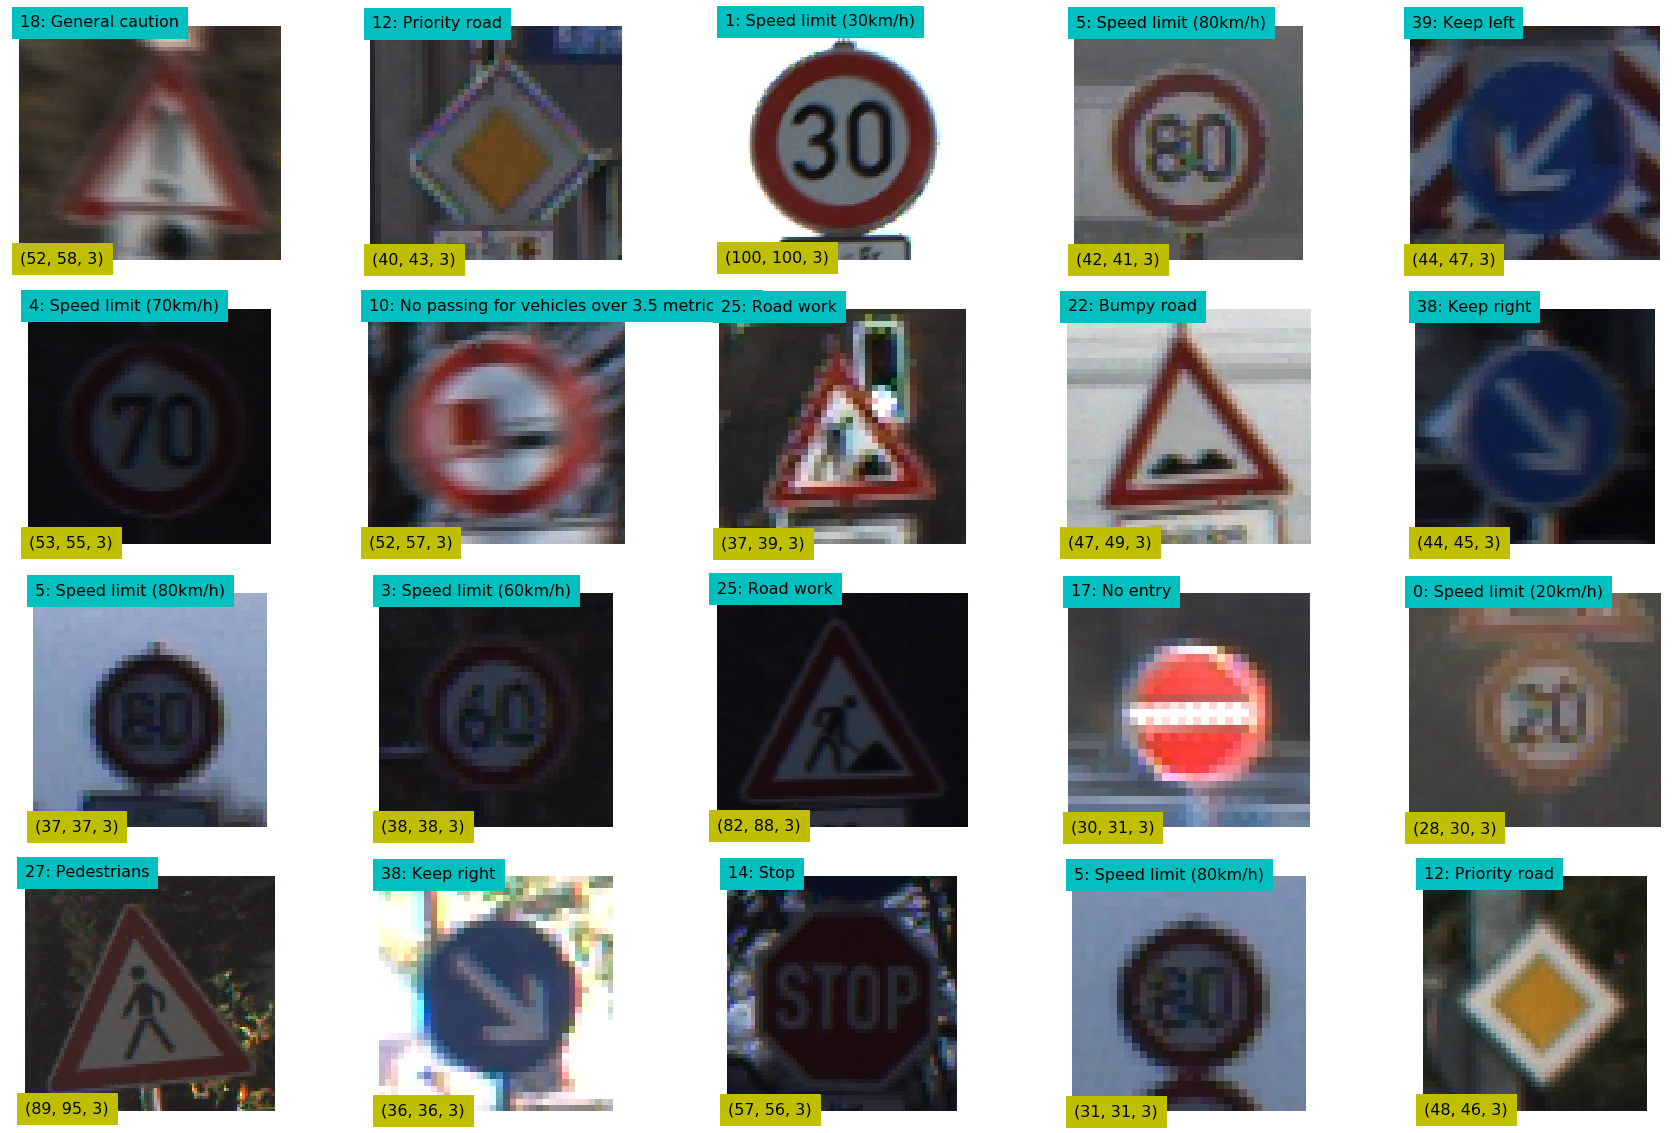

In [13]:
sample_data = get_samples(train_df, 20)
show_images(sample_data, sign_names=SIGN_NAMES, show_shape=True)

Speed limit (50km/h)


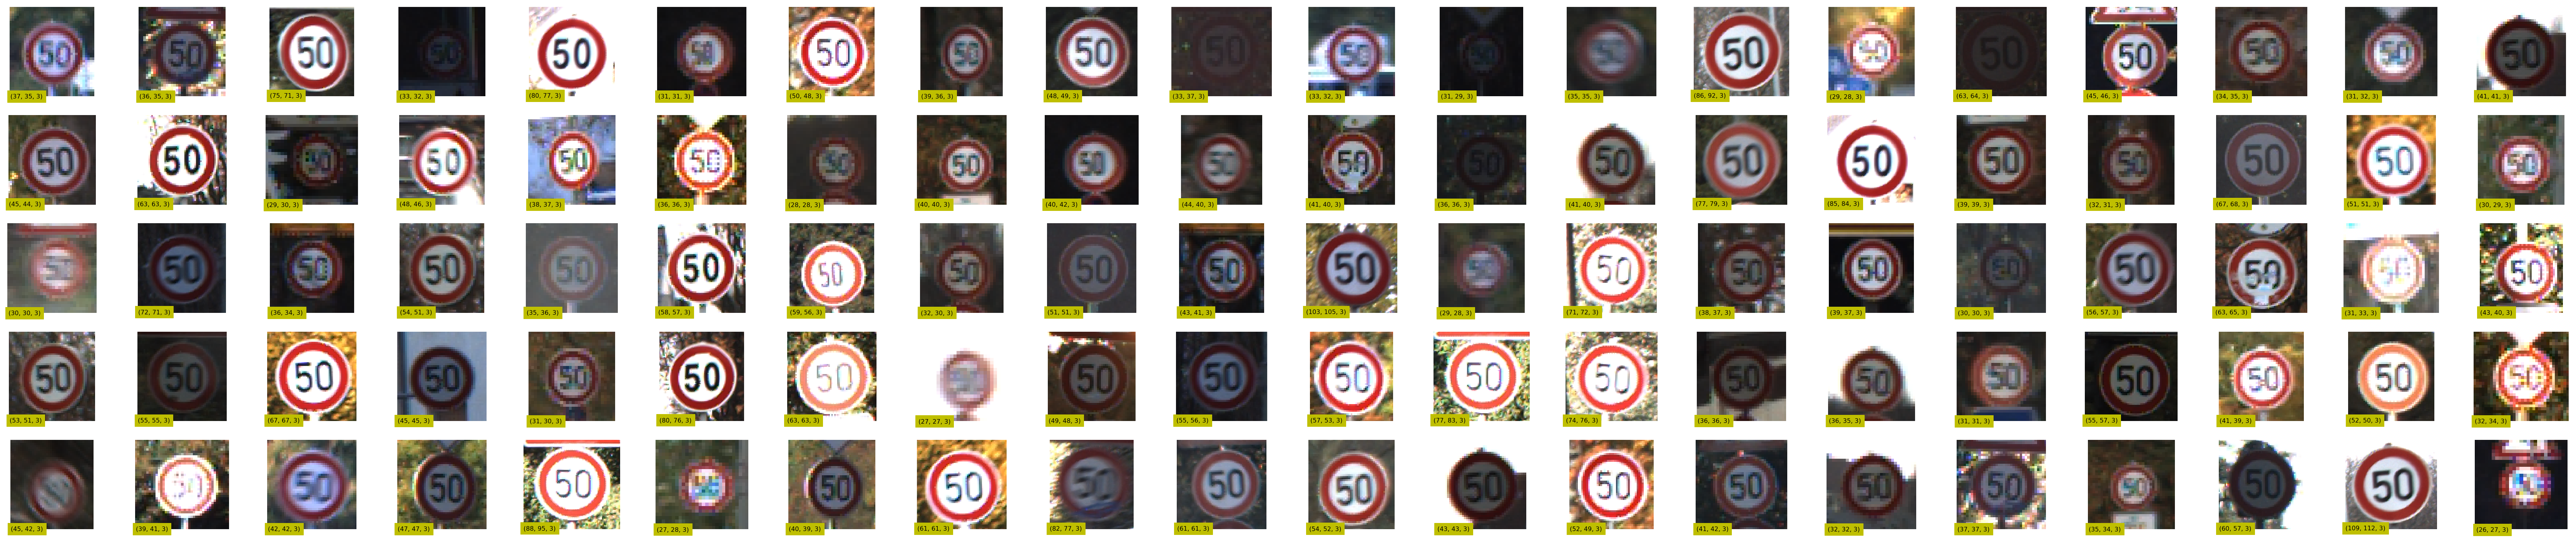

In [14]:
print(SIGN_NAMES[2])
show_images(get_samples(train_df, 100, class_id=2), cols=20, show_shape=True)

Looking at the sample images, the following image characteristics are confirmed:

- The images comes in different sizes  
- The darkness / brightness of those images are fairly random
- The images may be slightly rotated
- The images may not be facing straight
- The images may not be exactly centered
  
The first point will be handled in the image pre-processing, and the remaining points will be handled in the image augmentation.

## Train and Validation Data set

Train and validation data set are created from the training data.

In [15]:
X = train_df['Filename'].values
y = train_df['ClassId'].values

print('X data', len(X))

X data 39209


In [16]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, stratify=y, test_size=8000, random_state=0)

print('X_train:', len(X_train))
print('X_valid:', len(X_valid))

X_train: 31209
X_valid: 8000


#  Model Implementation

## Model Architecture

The model is based on [LeNet](http://yann.lecun.com/exdb/lenet/) by Yann LeCun.  It is a convolutional neural network designed to recognize visual patterns directly from pixel images with minimal preprocessing.  It can handle hand-written characters very well. 

![LeNet](images/lenet.png)

Source: http://yann.lecun.com/exdb/publis/pdf/lecun-98.pdf

- The inputs are 32x32 (Black-White 1 channel) images
- LeNet uses 2x2 sub-sampling (valid padding, max pooling) in convolutional layers (no dropout)
- LeNet uses a sigmoid squashing function - a scaled hyperbolic tangent: $Atanh(Sa)$ where A=1.7159 and S=2/3
- LeNet has one 7x12 bitmap for each class, which is a label.  There are 10 classes (the digits '0' - '9')
- 7x12 = 84 which is why the output is 84
- The output is compared with all the labels (bitmaps) to calculate the error
- The class with the smallest error is an estimated digit value

Our model is adapted from the LeNet as follows.  

- The inputs are 32x32 (RGB - 3 channels) images
- The activation function is ReLU except for the output layer which uses Softmax
- The output has 43 classes

|Layer                       | Shape    |
|----------------------------|:--------:|
|Input                       | 32x32x3  |
|Convolution (valid, 5x5x6)  | 28x28x6  |
|Max Pooling (valid, 2x2)    | 14x14x6  |
|Activation  (ReLU)          | 14x14x6  |
|Convolution (valid, 5x5x16) | 10x10x16 |
|Max Pooling (valid, 2x2)    | 5x5x16   |
|Activation  (ReLU)          | 5x5x16   |
|Flatten                     | 400      |
|Dense                       | 120      |
|Activation  (ReLU)          | 120      |
|Dense                       | 43       |
|Activation  (Softmax)       | 43       |

## Model Implementation

The NeuralNetwork class is defined to provide common operations in neural network using Tensorflow.  See the network.py for details.

The first network (based on LeNet) is defined as follows:

In [17]:
INPUT_SHAPE = (32, 32, 3)

def make_network1(input_shape=INPUT_SHAPE):
    return (NeuralNetwork()
            .input(input_shape)
            .conv([5, 5, 6])
            .max_pool()
            .relu()
            .conv([5, 5, 16])
            .max_pool()
            .relu()
            .flatten()
            .dense(120)
            .relu()
            .dense(N_CLASSES))

## Pipeline Implementation

We are using the scikit-learn's pipeline framework to handle various pipeline scenarios.  See pipeline.py for details.

Once made, a pipeline can be trained and evaluated using the function below:

In [18]:
def train_evaluate(pipeline, epochs=5, samples_per_epoch=50000, train=(X_train, y_train), test=(X_valid, y_valid)):
    """
    Repeat the training for the epochs and evaluate the performance
    """
    X, y = train
    learning_curve = []
    for i in range(epochs):
        indices = np.random.choice(len(X), size=samples_per_epoch)
        pipeline.fit(X[indices], y[indices])
        scores = [pipeline.score(*train), pipeline.score(*test)]
        learning_curve.append([i, *scores])
        print("Epoch: {:>3} Train Score: {:.3f} Evaluation Score: {:.3f}".format(i, *scores))
    return np.array(learning_curve).T # (epochs, train scores, eval scores)

### The First Performance

Let's train a network using the first network.  This performance is our initial benchmark.

In [19]:
def resize_image(image, shape=INPUT_SHAPE[:2]):
    return cv2.resize(image, shape)

loader = lambda image_file: resize_image(load_image(image_file))

In [20]:
with Session() as session:
    functions = [loader]
    pipeline = build_pipeline(functions, session, make_network1(), make_adam(1.0e-3))
    train_evaluate(pipeline)

Epoch:   0 Train Score: 0.841 Evaluation Score: 0.822
Epoch:   1 Train Score: 0.939 Evaluation Score: 0.916
Epoch:   2 Train Score: 0.955 Evaluation Score: 0.932
Epoch:   3 Train Score: 0.891 Evaluation Score: 0.866
Epoch:   4 Train Score: 0.948 Evaluation Score: 0.925


**Observation**:

This proves the network is working properly.  The performance is pretty good for the barebone network.

I can see a bit of overfitting.  This is likely because the network is exposed to the same images over and over since I'm using 5 epochs (50K samples per epoch).  At this moment, it is good to see the network is able to overfit and not showing high biases.  The network can handle these images and able to learn from the data.

# Preprocessing

## Image Augmentation

As the training set has very skewed distribution, if I simply increases the epochs or samples per epoch, the network will overfit to the training set.  Hence, we should generate more training data using image augmentation.

In [21]:
def random_brightness(image, ratio):
    """
    Randomly adjust brightness of the image.
    """
    # HSV (Hue, Saturation, Value) is also called HSB ('B' for Brightness).
    hsv = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
    brightness = np.float64(hsv[:, :, 2])
    brightness = brightness * (1.0 + np.random.uniform(-ratio, ratio))
    brightness[brightness>255] = 255
    brightness[brightness<0] = 0
    hsv[:, :, 2] = brightness
    return cv2.cvtColor(hsv, cv2.COLOR_HSV2RGB)


def random_rotation(image, angle):
    """
    Randomly rotate the image
    """
    if angle == 0:
        return image
    angle = np.random.uniform(-angle, angle)
    rows, cols = image.shape[:2]
    size = cols, rows
    center = cols/2, rows/2
    scale = 1.0
    rotation = cv2.getRotationMatrix2D(center, angle, scale)
    return cv2.warpAffine(image, rotation, size)


def random_translation(image, translation):
    """
    Randomly move the image
    """
    if translation == 0:
        return 0
    rows, cols = image.shape[:2]
    size = cols, rows
    x = np.random.uniform(-translation, translation)
    y = np.random.uniform(-translation, translation)
    trans = np.float32([[1,0,x],[0,1,y]])
    return cv2.warpAffine(image, trans, size)


def random_shear(image, shear):
    """
    Randomly distort the image
    """
    if shear == 0:
        return image
    rows, cols = image.shape[:2]
    size = cols, rows
    left, right, top, bottom = shear, cols - shear, shear, rows - shear
    dx = np.random.uniform(-shear, shear)
    dy = np.random.uniform(-shear, shear)
    p1 = np.float32([[left   , top],[right   , top   ],[left, bottom]])
    p2 = np.float32([[left+dx, top],[right+dx, top+dy],[left, bottom+dy]])
    move = cv2.getAffineTransform(p1,p2)
    return cv2.warpAffine(image, move, size)
    
    
def augment_image(image, brightness, angle, translation, shear):
    image = random_brightness(image, brightness)
    image = random_rotation(image, angle)
    image = random_translation(image, translation)
    image = random_shear(image, shear)
    return image

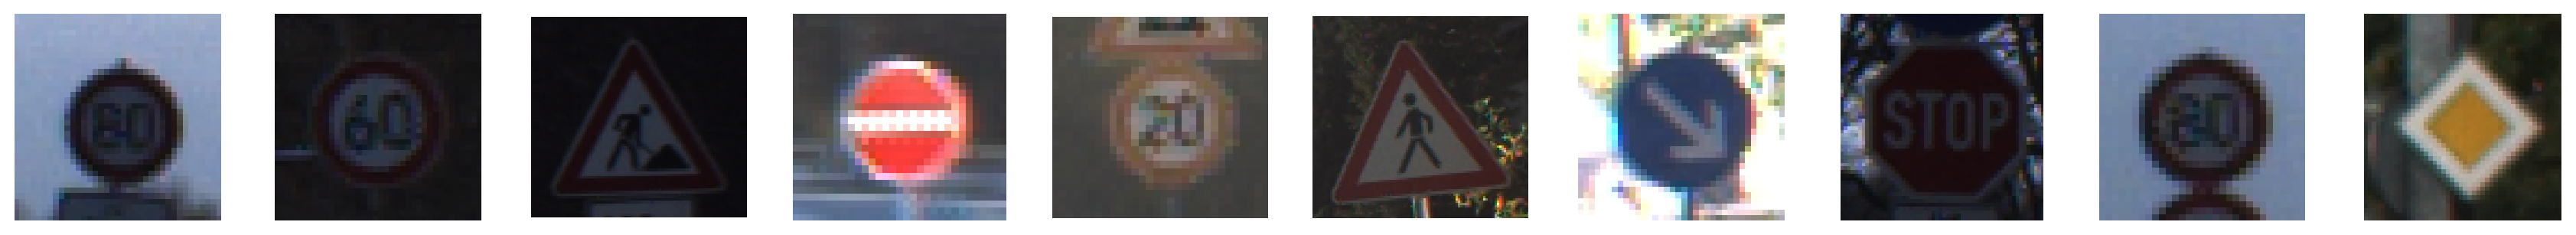

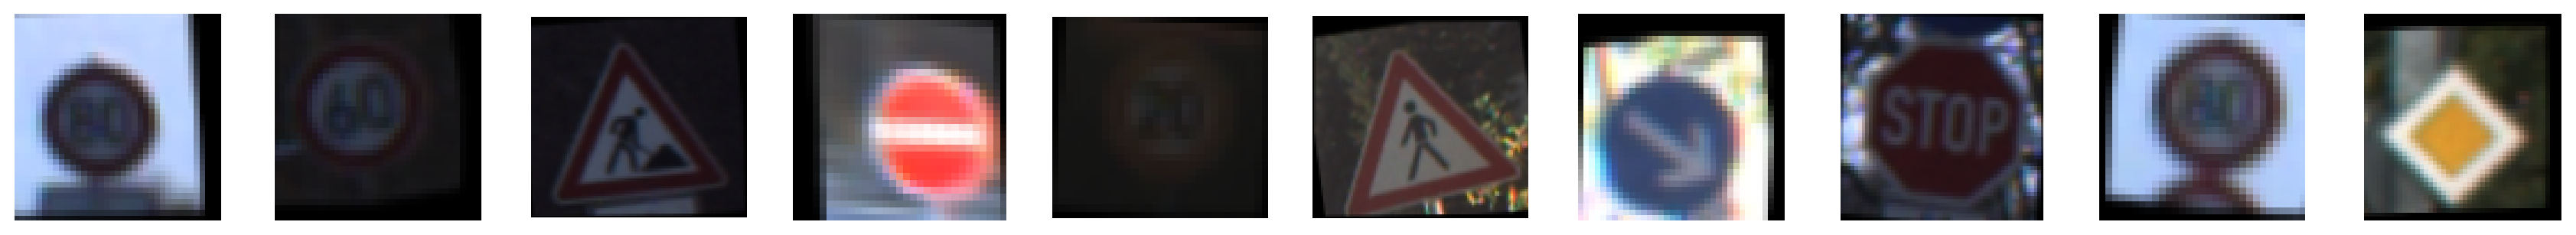

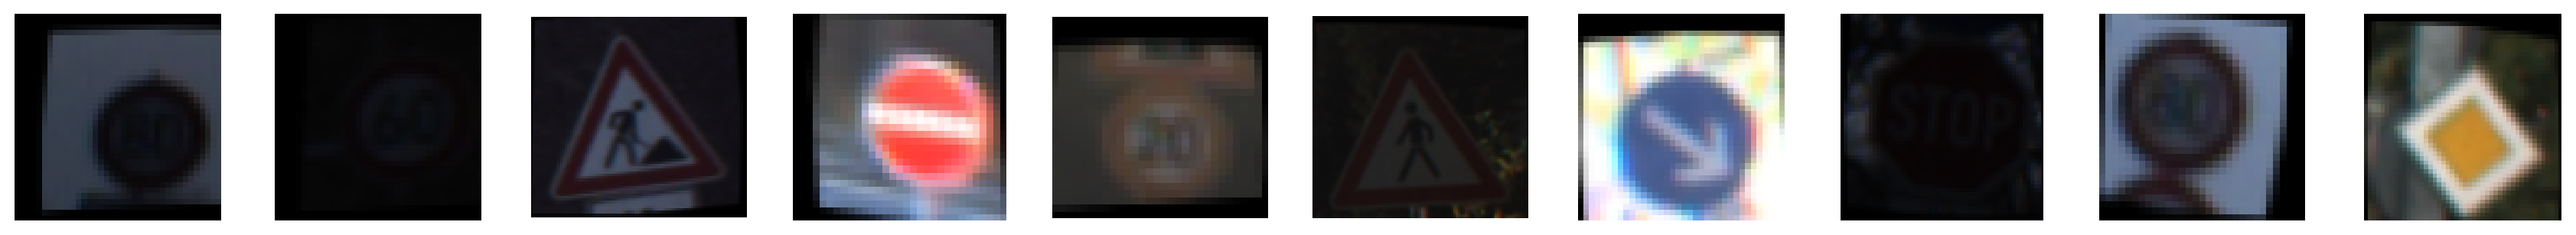

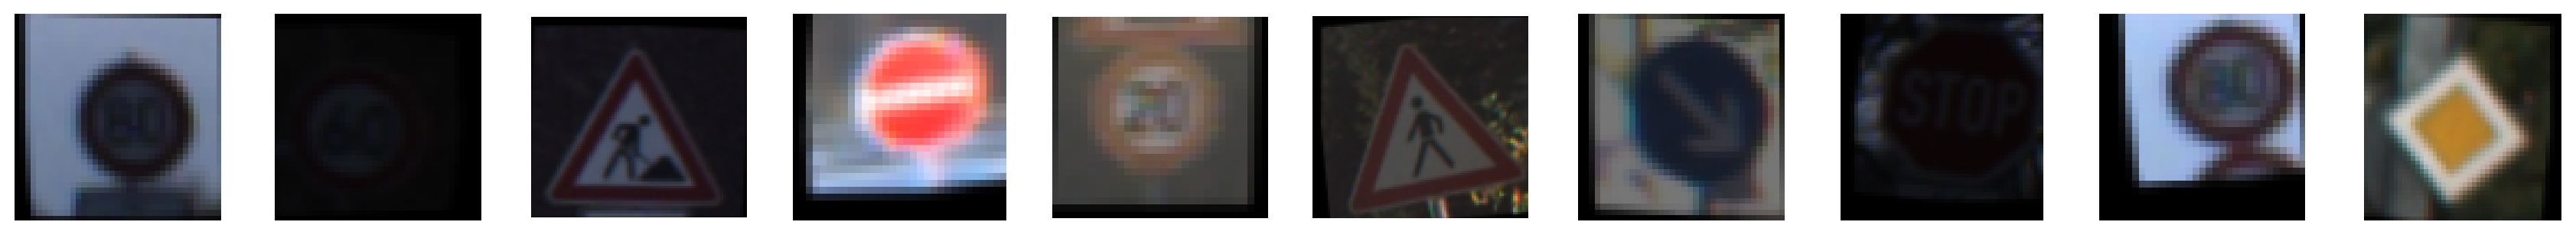

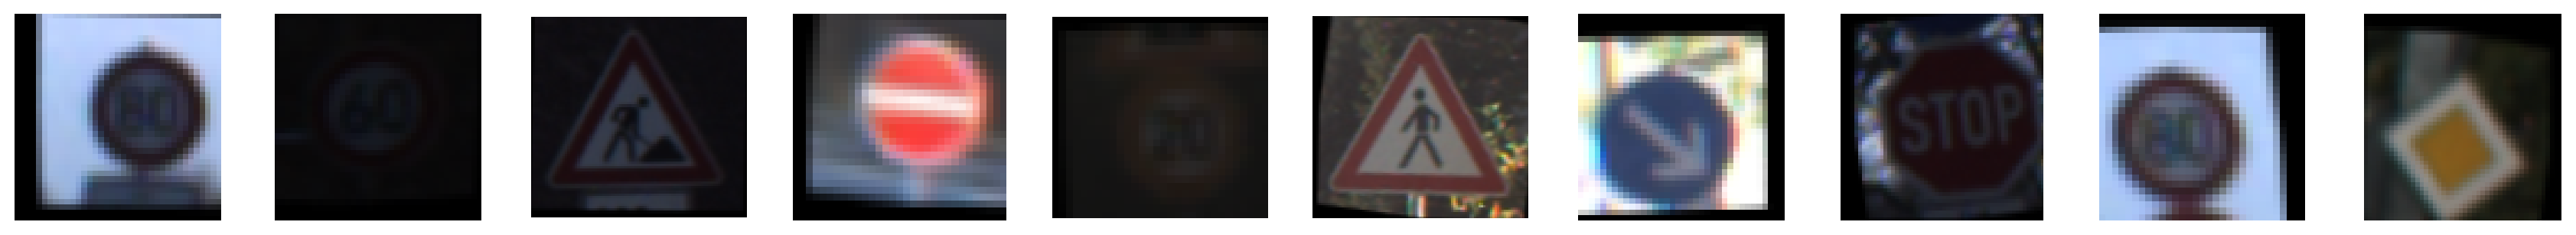

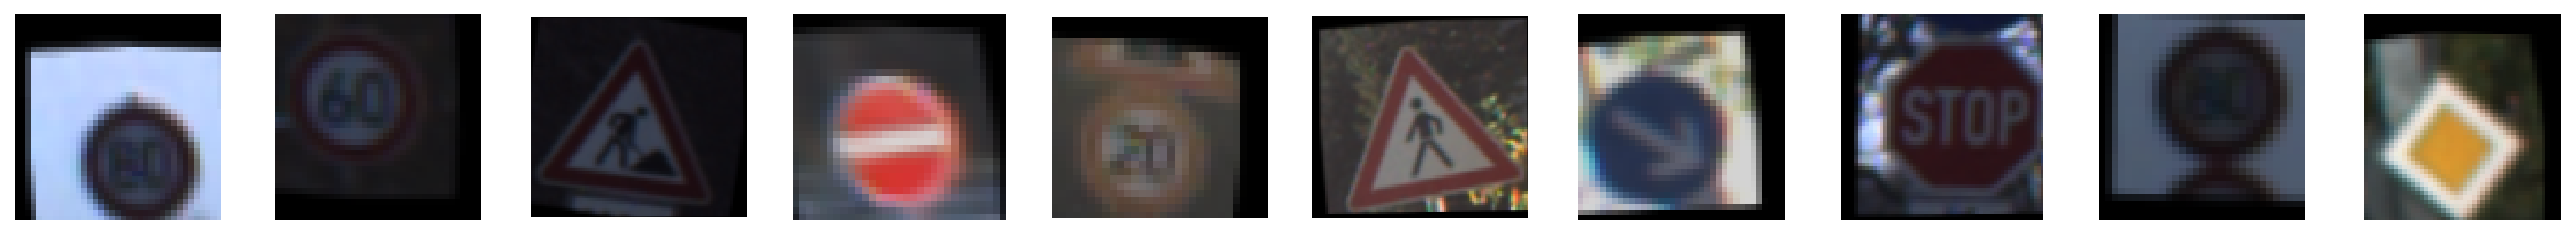

In [22]:
augmenter = lambda x: augment_image(x, brightness=0.7, angle=10, translation=5, shear=2)

show_images(sample_data[10:], cols=10) # original
for _ in range(5):
    show_images(sample_data[10:], cols=10, func=augmenter)

In [23]:
with Session() as session:
    functions = [loader, augmenter]
    pipeline = build_pipeline(functions, session, make_network1(), make_adam(1.0e-3))
    train_evaluate(pipeline)

Epoch:   0 Train Score: 0.199 Evaluation Score: 0.204
Epoch:   1 Train Score: 0.464 Evaluation Score: 0.460
Epoch:   2 Train Score: 0.574 Evaluation Score: 0.572
Epoch:   3 Train Score: 0.633 Evaluation Score: 0.628
Epoch:   4 Train Score: 0.674 Evaluation Score: 0.675


**Obervation**:

The hyper-perameters like brightness, rotation, translation, shear parameters are manually tuned by looking at the randomly altered images.  If the alteration is too great, it is not realistic.  The same way that horizontal flip is not included, too big change like rotating 90 degree should not be used.

The performance with the augmentation is much worse than without it.  There are two possible reasons:

1. the network is not robust to these changes (it was memorizing than generalizing)
2. the training requires more epochs (it takes more time to train with larger data)

Let's see how other preprocessing can improve the performance first.  I hope the normalization and other technique will make the learning easier for the network.  Once that's done, I will use much bigger epochs to properly measure the performance.

## Data Normalization

The below will test various normalization technique to see which one has the best performance.

In [24]:
normalizers = [('x - 127.5',              lambda x: x - 127.5), 
               ('x/127.5 - 1.0',          lambda x: x/127.5 - 1.0), 
               ('x/255.0 - 0.5',          lambda x: x/255.0 - 0.5),
               ('x - x.mean()',           lambda x: x - x.mean()),
               ('(x - x.mean())/x.std()', lambda x: (x - x.mean())/x.std())]
                
for name, normalizer in normalizers:
    print('Normalizer: {}'.format(name))
    with Session() as session:
        functions = [loader, augmenter, normalizer]
        pipeline = build_pipeline(functions, session, make_network1(), make_adam(1.0e-3))
        train_evaluate(pipeline)
    print()

Normalizer: x - 127.5
Epoch:   0 Train Score: 0.436 Evaluation Score: 0.426
Epoch:   1 Train Score: 0.594 Evaluation Score: 0.592
Epoch:   2 Train Score: 0.733 Evaluation Score: 0.719
Epoch:   3 Train Score: 0.736 Evaluation Score: 0.739
Epoch:   4 Train Score: 0.790 Evaluation Score: 0.782

Normalizer: x/127.5 - 1.0
Epoch:   0 Train Score: 0.593 Evaluation Score: 0.590
Epoch:   1 Train Score: 0.754 Evaluation Score: 0.754
Epoch:   2 Train Score: 0.811 Evaluation Score: 0.809
Epoch:   3 Train Score: 0.854 Evaluation Score: 0.851
Epoch:   4 Train Score: 0.849 Evaluation Score: 0.844

Normalizer: x/255.0 - 0.5
Epoch:   0 Train Score: 0.567 Evaluation Score: 0.558
Epoch:   1 Train Score: 0.680 Evaluation Score: 0.679
Epoch:   2 Train Score: 0.760 Evaluation Score: 0.750
Epoch:   3 Train Score: 0.786 Evaluation Score: 0.787
Epoch:   4 Train Score: 0.813 Evaluation Score: 0.812

Normalizer: x - x.mean()
Epoch:   0 Train Score: 0.515 Evaluation Score: 0.508
Epoch:   1 Train Score: 0.682 Eval

**Observaton**:

The performance with any of the normalizations is better than without them.  This clearly shows the importance of the normalizations.  In this experiment, the normalization with `(x-x.mean())/x.std()` produced the best performance.  The performance actually varies randomly at every run.  So, it is not easy to say which one is better than what.  In any case, `(x-x.mean())/x.std()` wins by far.

There are more techniques like using an average image of all training data, etc, which I may try later on.  But for now, I will use the best performing normalization for the rest of the experiment.

In [25]:
normalizer = lambda x: (x - x.mean())/x.std()

## Color Space

Now, we'll try difference color space to see if there is any performance gain.

Note: Gray scale has only one channel so it needs to be handled separately.

**Color Code Reference**:

- http://docs.opencv.org/3.2.0/de/d25/imgproc_color_conversions.html
- https://en.wikipedia.org/wiki/CIE_1931_color_space

In [26]:
# for Gray scale, we need to add the 3rd dimension back (1 channel) as it's expected by the network
converters = [('Gray', lambda x: cv2.cvtColor(x, cv2.COLOR_RGB2GRAY)[:, :, np.newaxis]),
              ('HSV', lambda x: cv2.cvtColor(x, cv2.COLOR_RGB2HSV)),
              ('HLS', lambda x: cv2.cvtColor(x, cv2.COLOR_RGB2HLS)),
              ('Lab', lambda x: cv2.cvtColor(x, cv2.COLOR_RGB2Lab)),
              ('Luv', lambda x: cv2.cvtColor(x, cv2.COLOR_RGB2Luv)),
              ('XYZ', lambda x: cv2.cvtColor(x, cv2.COLOR_RGB2XYZ)),
              ('Yrb', lambda x: cv2.cvtColor(x, cv2.COLOR_RGB2YCrCb)),
              ('YUV', lambda x: cv2.cvtColor(x, cv2.COLOR_RGB2YUV))]

GRAY_INPUT_SHAPE = (*INPUT_SHAPE[:2], 1)

for name, converter in converters:
    print('Color Space: {}'.format(name))
    with Session() as session:
        functions = [loader, augmenter, converter, normalizer]
        if name == 'Gray':
            network = make_network1(input_shape=GRAY_INPUT_SHAPE) # there is only one channel in gray scale
        else:
            network = make_network1()
        pipeline = build_pipeline(functions, session, network, make_adam(1.0e-3))
        train_evaluate(pipeline)
    print()

Color Space: Gray
Epoch:   0 Train Score: 0.734 Evaluation Score: 0.725
Epoch:   1 Train Score: 0.825 Evaluation Score: 0.822
Epoch:   2 Train Score: 0.854 Evaluation Score: 0.851
Epoch:   3 Train Score: 0.886 Evaluation Score: 0.887
Epoch:   4 Train Score: 0.903 Evaluation Score: 0.901

Color Space: HSV
Epoch:   0 Train Score: 0.521 Evaluation Score: 0.513
Epoch:   1 Train Score: 0.623 Evaluation Score: 0.618
Epoch:   2 Train Score: 0.691 Evaluation Score: 0.689
Epoch:   3 Train Score: 0.749 Evaluation Score: 0.743
Epoch:   4 Train Score: 0.785 Evaluation Score: 0.777

Color Space: HLS
Epoch:   0 Train Score: 0.471 Evaluation Score: 0.478
Epoch:   1 Train Score: 0.576 Evaluation Score: 0.573
Epoch:   2 Train Score: 0.652 Evaluation Score: 0.647
Epoch:   3 Train Score: 0.718 Evaluation Score: 0.719
Epoch:   4 Train Score: 0.770 Evaluation Score: 0.768

Color Space: Lab
Epoch:   0 Train Score: 0.583 Evaluation Score: 0.580
Epoch:   1 Train Score: 0.715 Evaluation Score: 0.715
Epoch:   2

**Observaton**:

RGB (no conversion) is the best which surprised me.  I was expecting the gray scale to be more efficient as the traffic signs are mostly about shapes not colors.  The gray scale would have reduced the dimensionality from 3 color channels to 1, which would make the learning faster/easier.  Apparently, that is not the case.  

Also, I was thinking that the colors in traffic signs are more saturated than that of backgrounds (i.e., trees), and the color space like HSV and HLS might contribute to superior performance.  This was not the case.  Also, now that I saw the result, I realized that I should not assume anything about the background colors.

On a separate note, I noticed that whenever I ran this cell, the result seems slightly different.  For example, gray scale or XYZ sometimes shows better performance than RGB (no conversion).  This could be due to the randomness of image augmentation.  But most of the times, RGB (no conversion) is the best.  If I needed to analyse this further, I'd need to check the histogram of different channels and the performance for each color space.  

But that's the kind of things the network should automatically figure out (i.e., automatic feature engineering).  So, I should not mess with color space at least for now.  It makes the pipeline simpler, too.

I'm done with preprocessing part.

In [27]:
preprocessors = [loader, augmenter, normalizer]

# Model Improvement

I want to try the following to see if I can improve the performance while not causing any overfit.

- more filters in conv layers
- more neurons in dense layers
- more conv layers 
- more dense layers
- different activation like `elu` instead of `relu`
- dropout

The below is to plot the learning curve.

In [28]:
def show_learning_curve(learning_curve):
    epochs, train, valid = learning_curve
    plt.figure(figsize=(10, 10))
    plt.plot(epochs, train, label='train')
    plt.plot(epochs, valid, label='validation')
    plt.title('Learning Curve')
    plt.ylabel('accuracy')
    plt.xlabel('epochs')
    plt.xticks(epochs)
    plt.legend(loc='center right')

These functions are for plotting and printing the confusion matrix.

In [29]:
def plot_confusion_matrix(cm):
    cm = [row/sum(row)   for row in cm]
    fig = plt.figure(figsize=(10, 10))
    ax = fig.add_subplot(111)
    cax = ax.matshow(cm, cmap=plt.cm.Oranges)
    fig.colorbar(cax)
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted Class IDs')
    plt.ylabel('True Class IDs')
    plt.show()
    

def print_confusion_matrix(cm, sign_names=SIGN_NAMES):
    results = [(i, SIGN_NAMES[i], row[i]/sum(row)*100) for i, row in enumerate(cm)]
    accuracies = []
    for result in sorted(results, key=lambda x: -x[2]):
        print('{:>2} {:<50} {:6.2f}% {:>4}'.format(*result, sum(y_train==result[0])))
        accuracies.append(result[2])
    print('-'*50)
    print('Accuracy: Mean: {:.3f} Std: {:.3f}'.format(np.mean(accuracies), np.std(accuracies)))

## Network 2

Doubling all filters in the convolutional layers and neurons in the dense layers.

Epoch:   0 Train Score: 0.853 Evaluation Score: 0.844
Epoch:   1 Train Score: 0.908 Evaluation Score: 0.908
Epoch:   2 Train Score: 0.937 Evaluation Score: 0.937
Epoch:   3 Train Score: 0.957 Evaluation Score: 0.954
Epoch:   4 Train Score: 0.951 Evaluation Score: 0.949


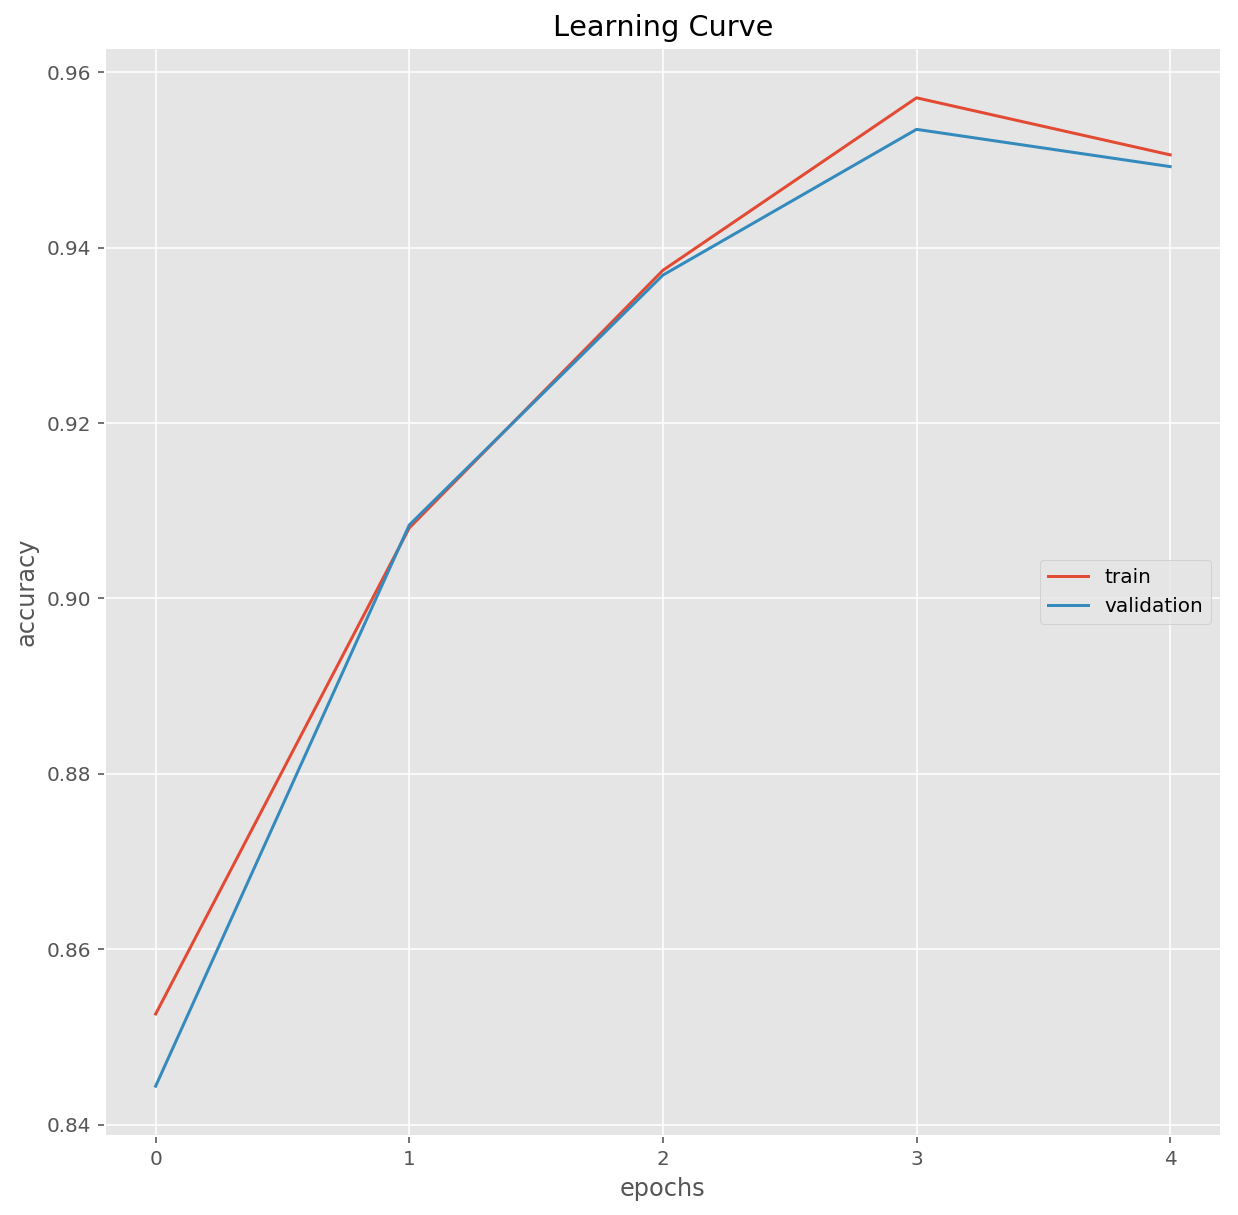

In [30]:
def make_network2(input_shape=INPUT_SHAPE):
    return (NeuralNetwork()
            .input(input_shape)
            .conv([5, 5, 12])  # <== doubled
            .max_pool()
            .relu()
            .conv([5, 5, 32])  # <== doubled
            .max_pool()
            .relu()
            .flatten()
            .dense(240) # <== doubled
            .relu()
            .dense(N_CLASSES))

with Session() as session:
    pipeline = build_pipeline(preprocessors, session, make_network2(), make_adam(1.0e-3))
    learning_curve = train_evaluate(pipeline)
    session.save('checkpoint/network2.ckpt')
    
show_learning_curve(learning_curve)

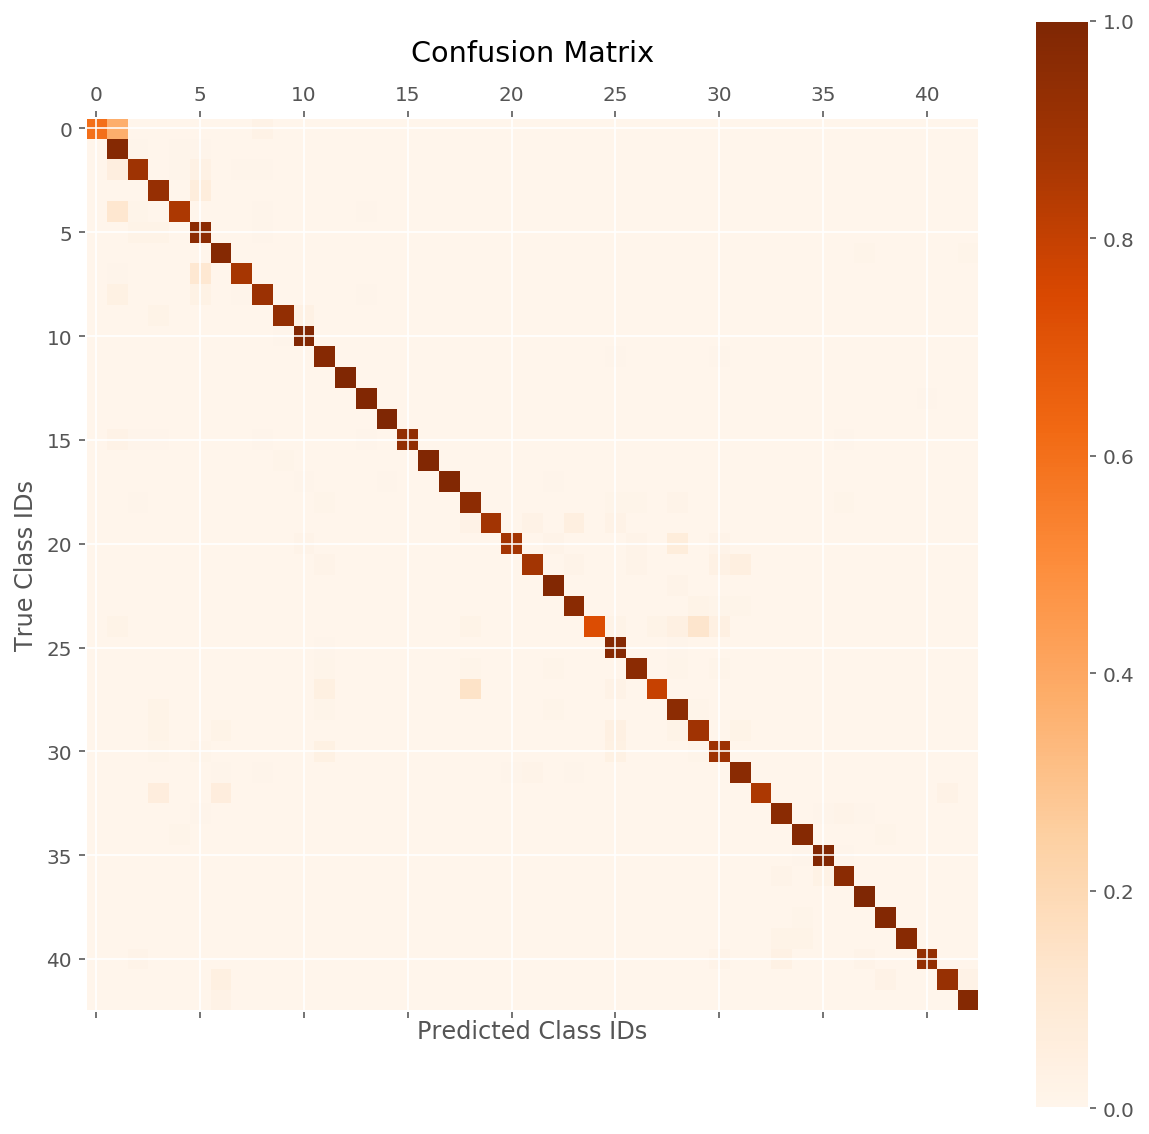

14 Stop                                               100.00%  621
37 Go straight or left                                100.00%  167
12 Priority road                                       99.30% 1672
35 Ahead only                                          99.18%  955
10 No passing for vehicles over 3.5 metric tons        99.02% 1600
13 Yield                                               98.87% 1719
16 Vehicles over 3.5 metric tons prohibited            98.84%  334
22 Bumpy road                                          98.75%  310
17 No entry                                            98.67%  884
38 Keep right                                          98.10% 1648
42 End of no passing by vehicles over 3.5 metric tons  97.96%  191
 1 Speed limit (30km/h)                                97.79% 1767
25 Road work                                           97.71% 1194
 6 End of speed limit (80km/h)                         97.67%  334
34 Turn left ahead                                     97.67% 

In [31]:
with Session() as session:
    pipeline = build_pipeline(preprocessors, session, make_network2())
    session.load('checkpoint/network2.ckpt')  
    pred = pipeline.predict(X_valid)
    
# examine confusionconfusion_matrixix
cm = confusion_matrix(y_valid, pred)
plot_confusion_matrix(cm)
print_confusion_matrix(cm)

**Observation**:

The performance improved. The training accuracy is slightly higher than the validation accuracy.  It might be a sign of overfitting but I'll need to see by increasing the complexity of the network.

On a separate note, I could have tried changing layer by layer but changing all three did work so I'm ok with this.

The confusion matrix's mean accuracy is the sum of the mean accuracy for each class divided by the number of class.  It is lower than overall accuracy indicating the larger classes are performing better (or the smaller classes are performing worse).

## Network 3

Futher doubling all filters in the convolutional layers and neurons in the dense layers.

Epoch:   0 Train Score: 0.904 Evaluation Score: 0.900
Epoch:   1 Train Score: 0.949 Evaluation Score: 0.946
Epoch:   2 Train Score: 0.963 Evaluation Score: 0.959
Epoch:   3 Train Score: 0.968 Evaluation Score: 0.964
Epoch:   4 Train Score: 0.967 Evaluation Score: 0.961


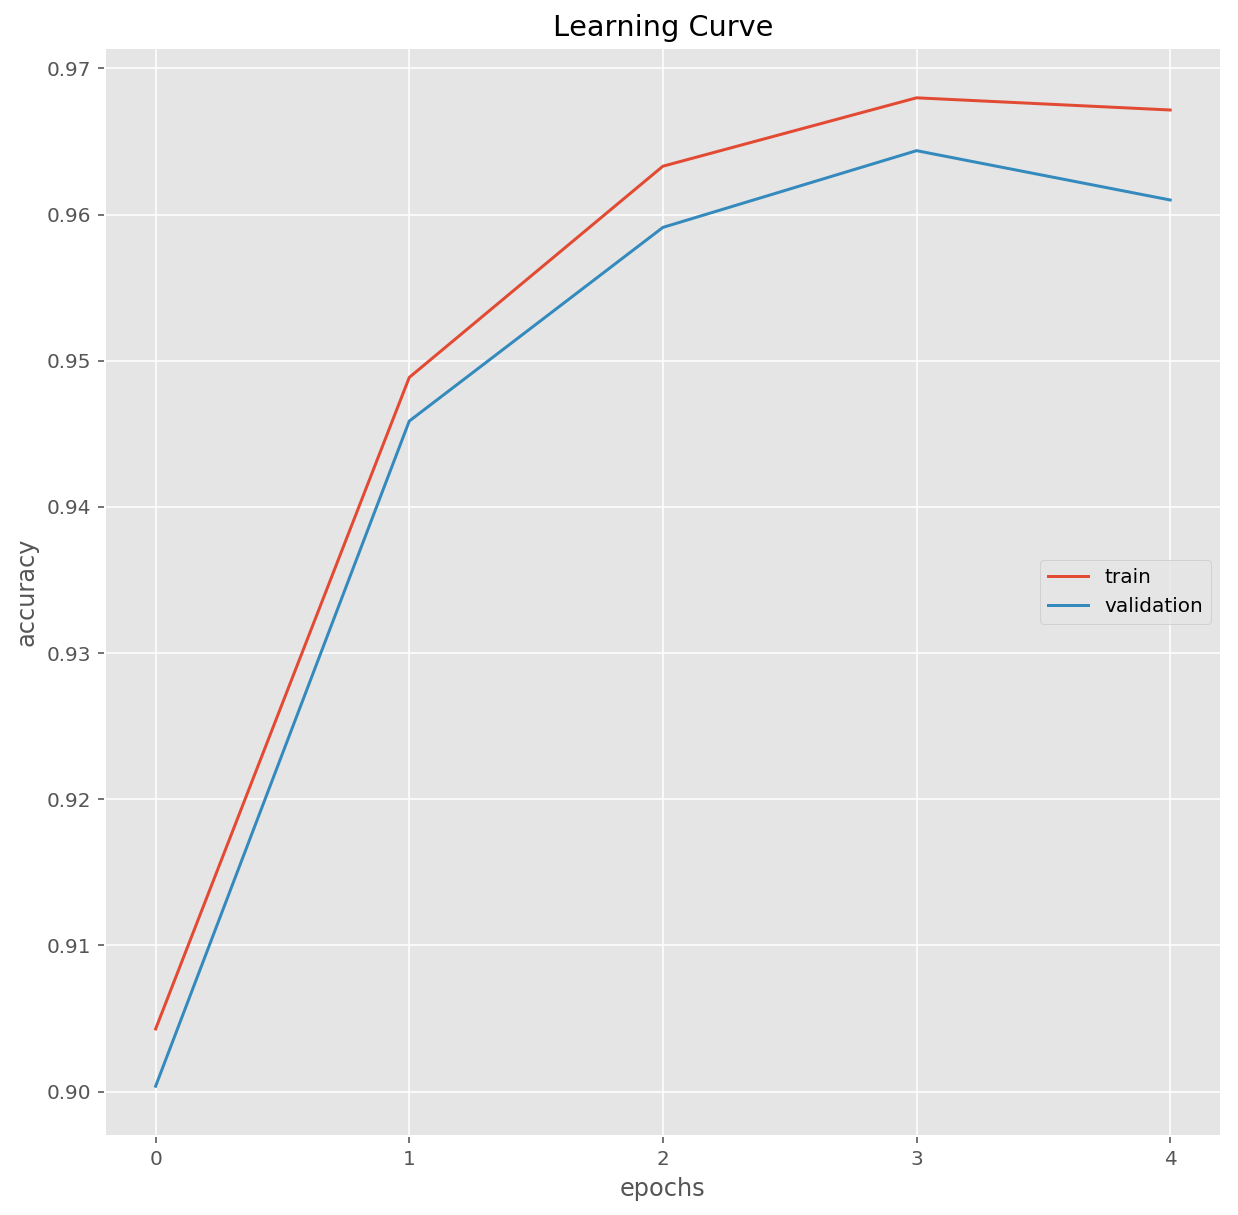

In [32]:
def make_network3(input_shape=INPUT_SHAPE):
    return (NeuralNetwork()
            .input(input_shape)
            .conv([5, 5, 24]) # <== doubled
            .max_pool()
            .relu()
            .conv([5, 5, 64]) # <== doubled
            .max_pool()
            .relu()
            .flatten()
            .dense(480)  # <== doubled
            .relu()
            .dense(N_CLASSES))

with Session() as session:
    pipeline = build_pipeline(preprocessors, session, make_network3(), make_adam(1.0e-3))
    learning_curve = train_evaluate(pipeline)
    session.save('checkpoint/network3.ckpt')
    
show_learning_curve(learning_curve)

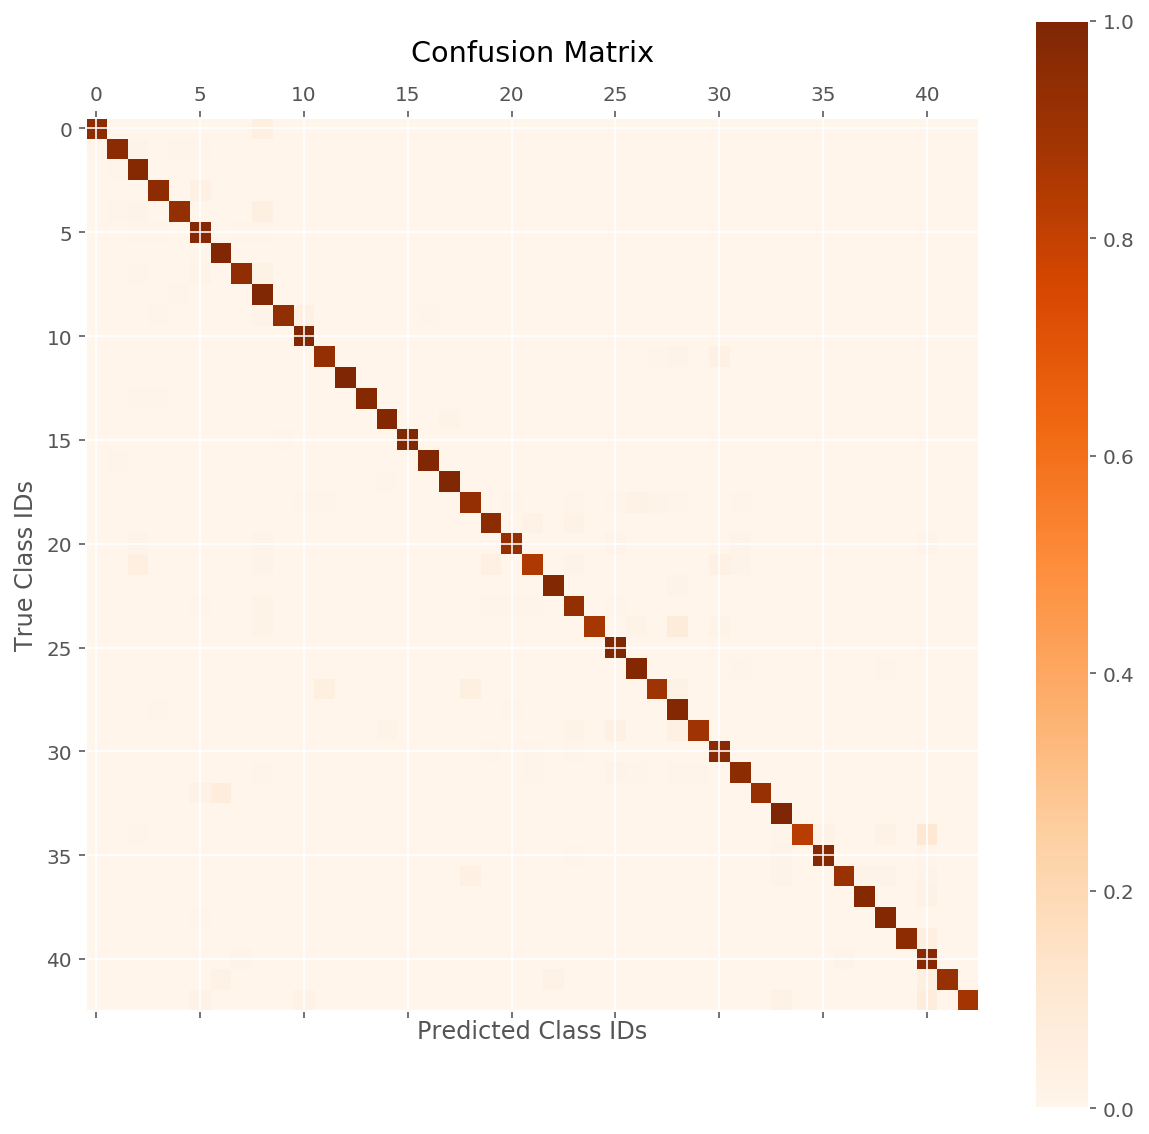

12 Priority road                                      100.00% 1672
33 Turn right ahead                                   100.00%  548
25 Road work                                           99.67% 1194
17 No entry                                            99.56%  884
 8 Speed limit (120km/h)                               99.31% 1122
10 No passing for vehicles over 3.5 metric tons        99.27% 1600
15 No vehicles                                         99.22%  501
 6 End of speed limit (80km/h)                         98.84%  334
16 Vehicles over 3.5 metric tons prohibited            98.84%  334
22 Bumpy road                                          98.75%  310
26 Traffic signals                                     98.36%  478
28 Children crossing                                   98.18%  430
14 Stop                                                98.11%  621
38 Keep right                                          98.10% 1648
13 Yield                                               97.96% 

In [33]:
with Session() as session:
    pipeline = build_pipeline(preprocessors, session, make_network3())
    session.load('checkpoint/network3.ckpt')  
    pred = pipeline.predict(X_valid)
    
# examine confusionconfusion_matrixix
cm = confusion_matrix(y_valid, pred)
plot_confusion_matrix(cm)
print_confusion_matrix(cm)

**Observation**:

The performance is better.  It may be showing a slight overfitting.  But I don't think we need to apply any regularization at this stage.  I should rather try more epochs to see how far it can improve.

For almost all classes, the network is producing better than 90% accuracy, proving that increasing the network complexity is making it more robust.

## Network 3 with More Epochs

Epoch:   0 Train Score: 0.891 Evaluation Score: 0.893
Epoch:   1 Train Score: 0.938 Evaluation Score: 0.937
Epoch:   2 Train Score: 0.958 Evaluation Score: 0.951
Epoch:   3 Train Score: 0.969 Evaluation Score: 0.969
Epoch:   4 Train Score: 0.954 Evaluation Score: 0.950
Epoch:   5 Train Score: 0.958 Evaluation Score: 0.953
Epoch:   6 Train Score: 0.972 Evaluation Score: 0.968
Epoch:   7 Train Score: 0.976 Evaluation Score: 0.973
Epoch:   8 Train Score: 0.970 Evaluation Score: 0.968
Epoch:   9 Train Score: 0.974 Evaluation Score: 0.966
Epoch:  10 Train Score: 0.968 Evaluation Score: 0.966
Epoch:  11 Train Score: 0.973 Evaluation Score: 0.970
Epoch:  12 Train Score: 0.971 Evaluation Score: 0.967
Epoch:  13 Train Score: 0.980 Evaluation Score: 0.979
Epoch:  14 Train Score: 0.977 Evaluation Score: 0.974
Epoch:  15 Train Score: 0.980 Evaluation Score: 0.974
Epoch:  16 Train Score: 0.978 Evaluation Score: 0.976
Epoch:  17 Train Score: 0.980 Evaluation Score: 0.978
Epoch:  18 Train Score: 0.98

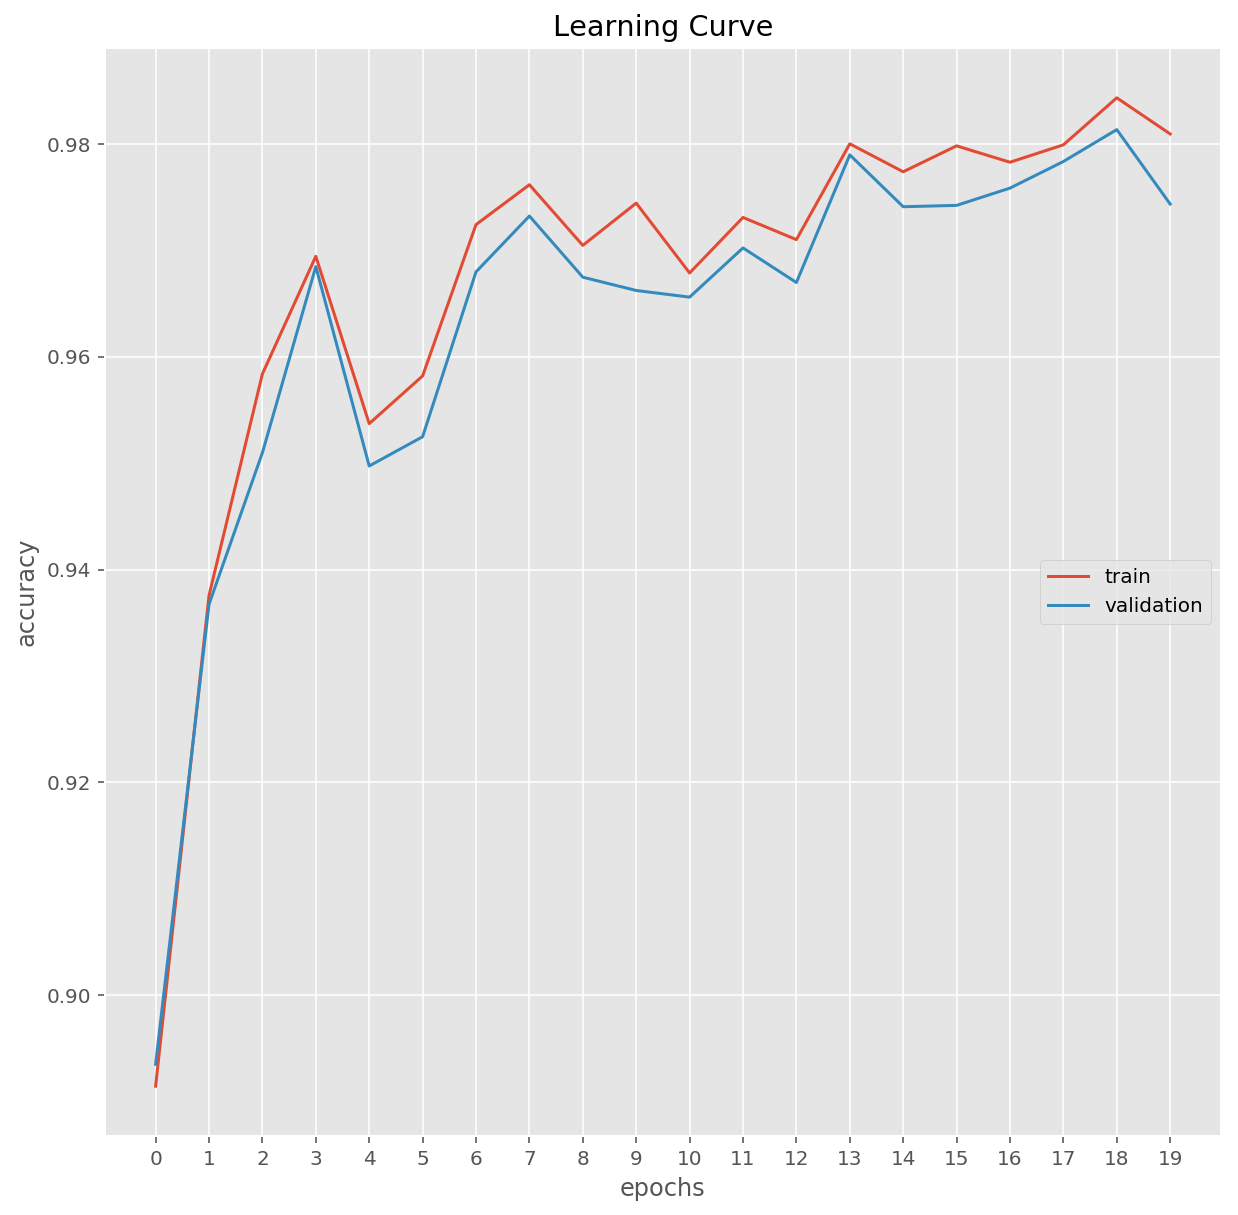

In [34]:
with Session() as session:
    pipeline = build_pipeline(preprocessors, session, make_network3(), make_adam(1.0e-3))
    learning_curve = train_evaluate(pipeline, epochs=20)
    session.save('checkpoint/network3_epochs-20.ckpt')
    
show_learning_curve(learning_curve)

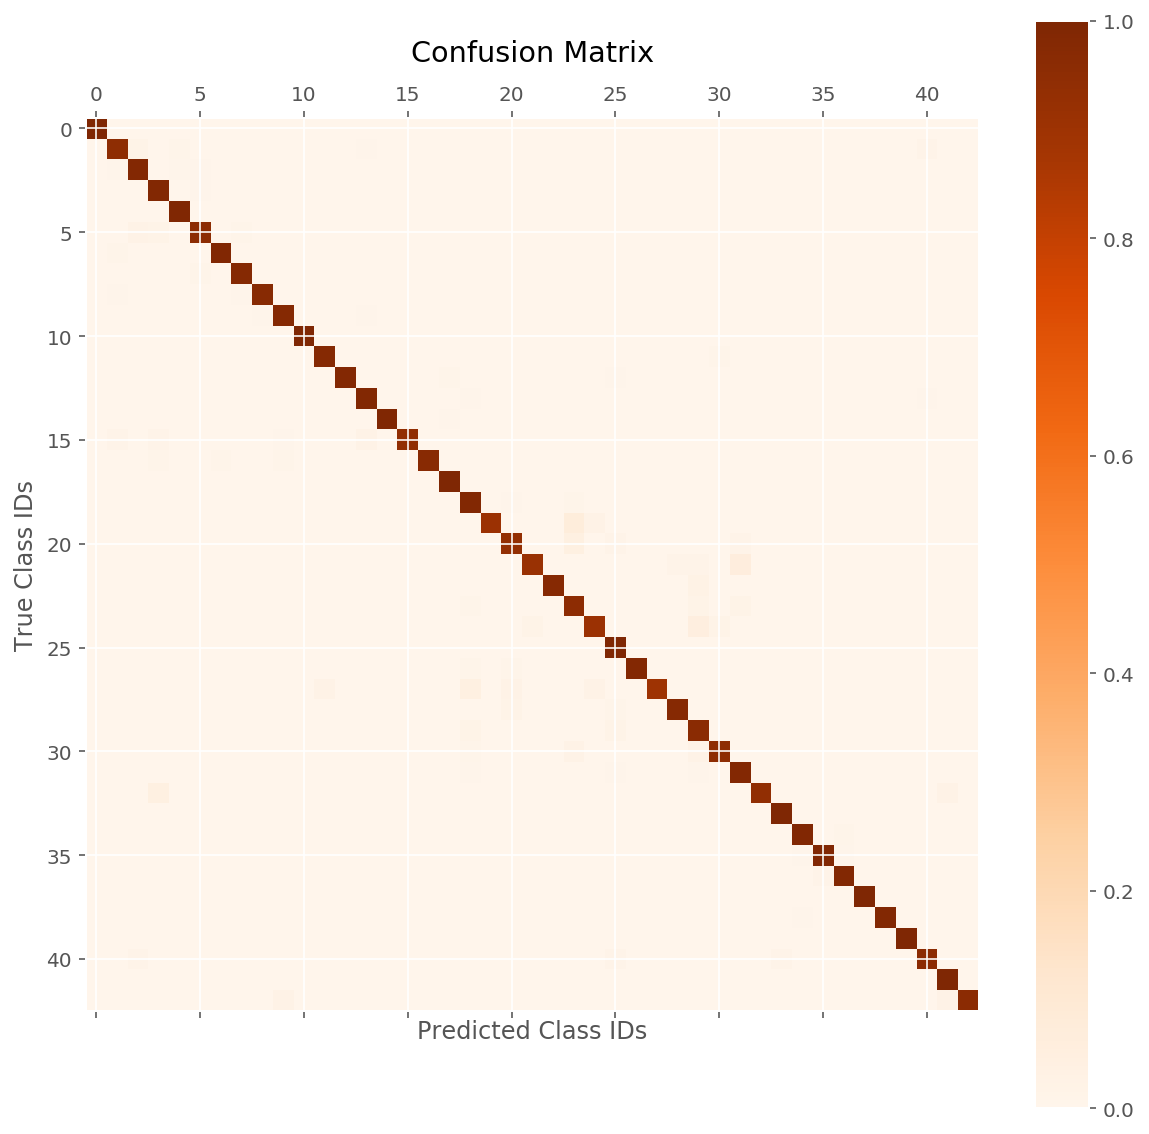

 0 Speed limit (20km/h)                               100.00%  167
17 No entry                                           100.00%  884
33 Turn right ahead                                   100.00%  548
37 Go straight or left                                100.00%  167
39 Keep left                                          100.00%  239
41 End of no passing                                  100.00%  191
10 No passing for vehicles over 3.5 metric tons        99.76% 1600
25 Road work                                           99.67% 1194
 4 Speed limit (70km/h)                                99.50% 1576
14 Stop                                                99.37%  621
35 Ahead only                                          99.18%  955
 6 End of speed limit (80km/h)                         98.84%  334
34 Turn left ahead                                     98.84%  334
38 Keep right                                          98.82% 1648
18 General caution                                     98.78% 

In [35]:
with Session() as session:
    pipeline = build_pipeline(preprocessors, session, make_network3())
    session.load('checkpoint/network3_epochs-20.ckpt')  
    pred = pipeline.predict(X_valid)
    
# examine confusionconfusion_matrixix
cm = confusion_matrix(y_valid, pred)
plot_confusion_matrix(cm)
print_confusion_matrix(cm)

**Observation**:

The performance did improve but not in the last several epochs.  

100% accuracy is achieved for more classes.  Also, the bottom performer is improving as well.

## Network 3 with More Epochs and Lower Learning Rate

Let's try a lower learning rate with epochs=20.

Epoch:   0 Train Score: 0.821 Evaluation Score: 0.821
Epoch:   1 Train Score: 0.920 Evaluation Score: 0.919
Epoch:   2 Train Score: 0.932 Evaluation Score: 0.924
Epoch:   3 Train Score: 0.958 Evaluation Score: 0.952
Epoch:   4 Train Score: 0.975 Evaluation Score: 0.975
Epoch:   5 Train Score: 0.972 Evaluation Score: 0.969
Epoch:   6 Train Score: 0.978 Evaluation Score: 0.973
Epoch:   7 Train Score: 0.976 Evaluation Score: 0.973
Epoch:   8 Train Score: 0.984 Evaluation Score: 0.980
Epoch:   9 Train Score: 0.982 Evaluation Score: 0.979
Epoch:  10 Train Score: 0.988 Evaluation Score: 0.984
Epoch:  11 Train Score: 0.986 Evaluation Score: 0.978
Epoch:  12 Train Score: 0.987 Evaluation Score: 0.984
Epoch:  13 Train Score: 0.984 Evaluation Score: 0.980
Epoch:  14 Train Score: 0.988 Evaluation Score: 0.982
Epoch:  15 Train Score: 0.986 Evaluation Score: 0.981
Epoch:  16 Train Score: 0.987 Evaluation Score: 0.983
Epoch:  17 Train Score: 0.989 Evaluation Score: 0.987
Epoch:  18 Train Score: 0.98

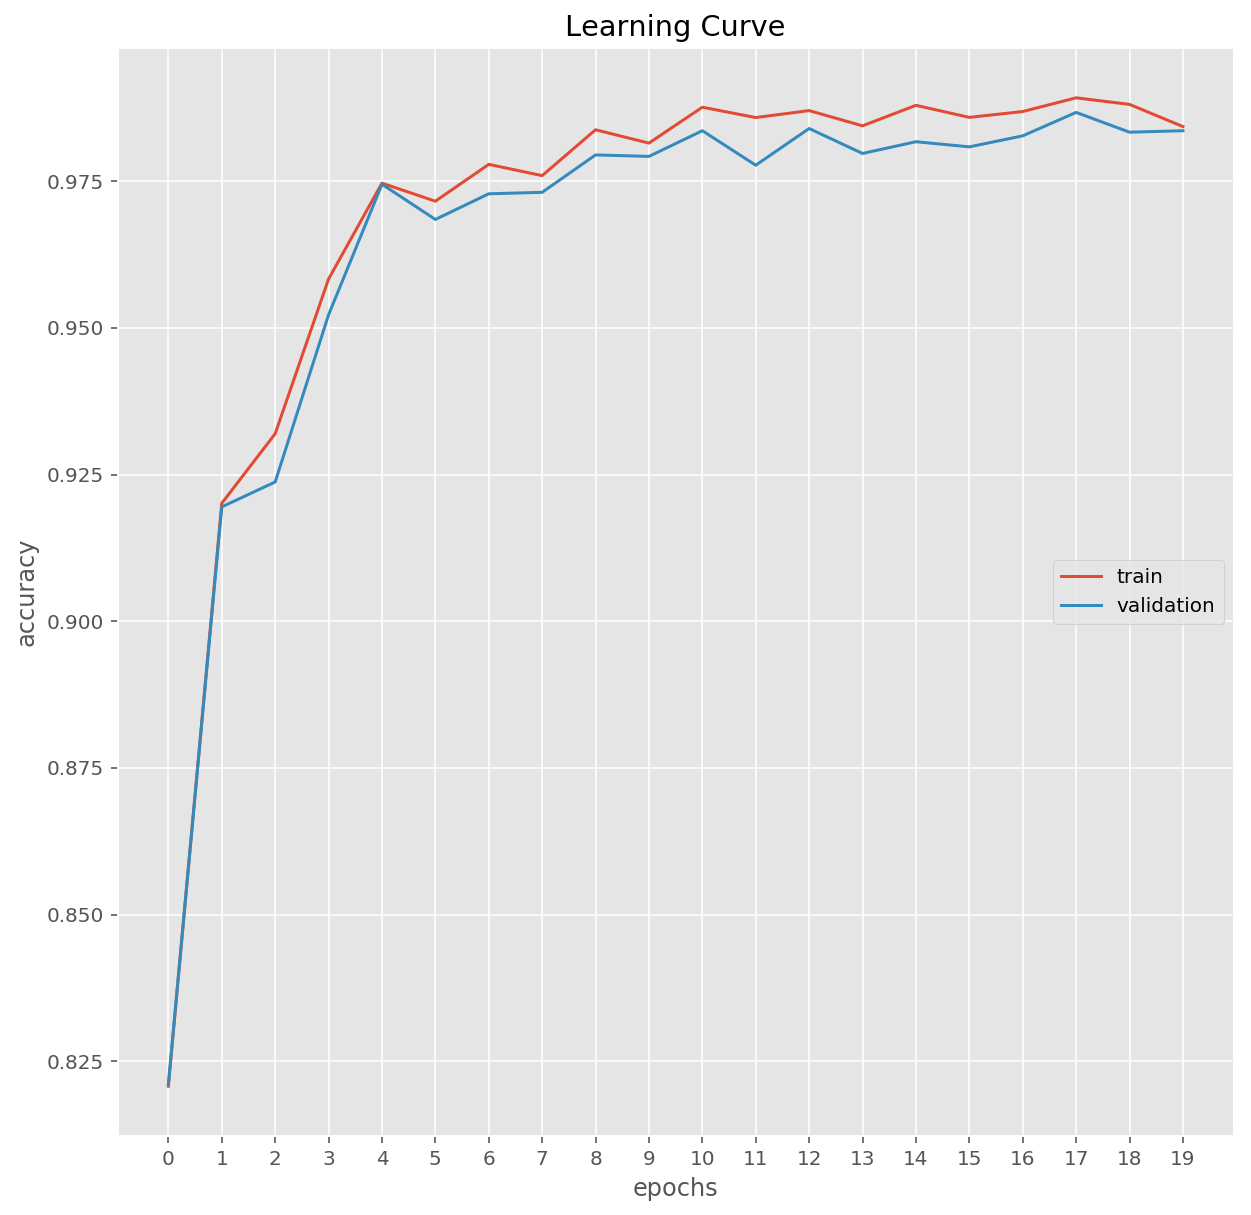

In [36]:
with Session() as session:
    pipeline = build_pipeline(preprocessors, session, make_network3(), make_adam(0.5e-3)) # <== lower learning rate
    learning_curve = train_evaluate(pipeline, epochs=20)
    session.save('checkpoint/network3_epochs-20_lr-0.5e-3.ckpt')
    
show_learning_curve(learning_curve)

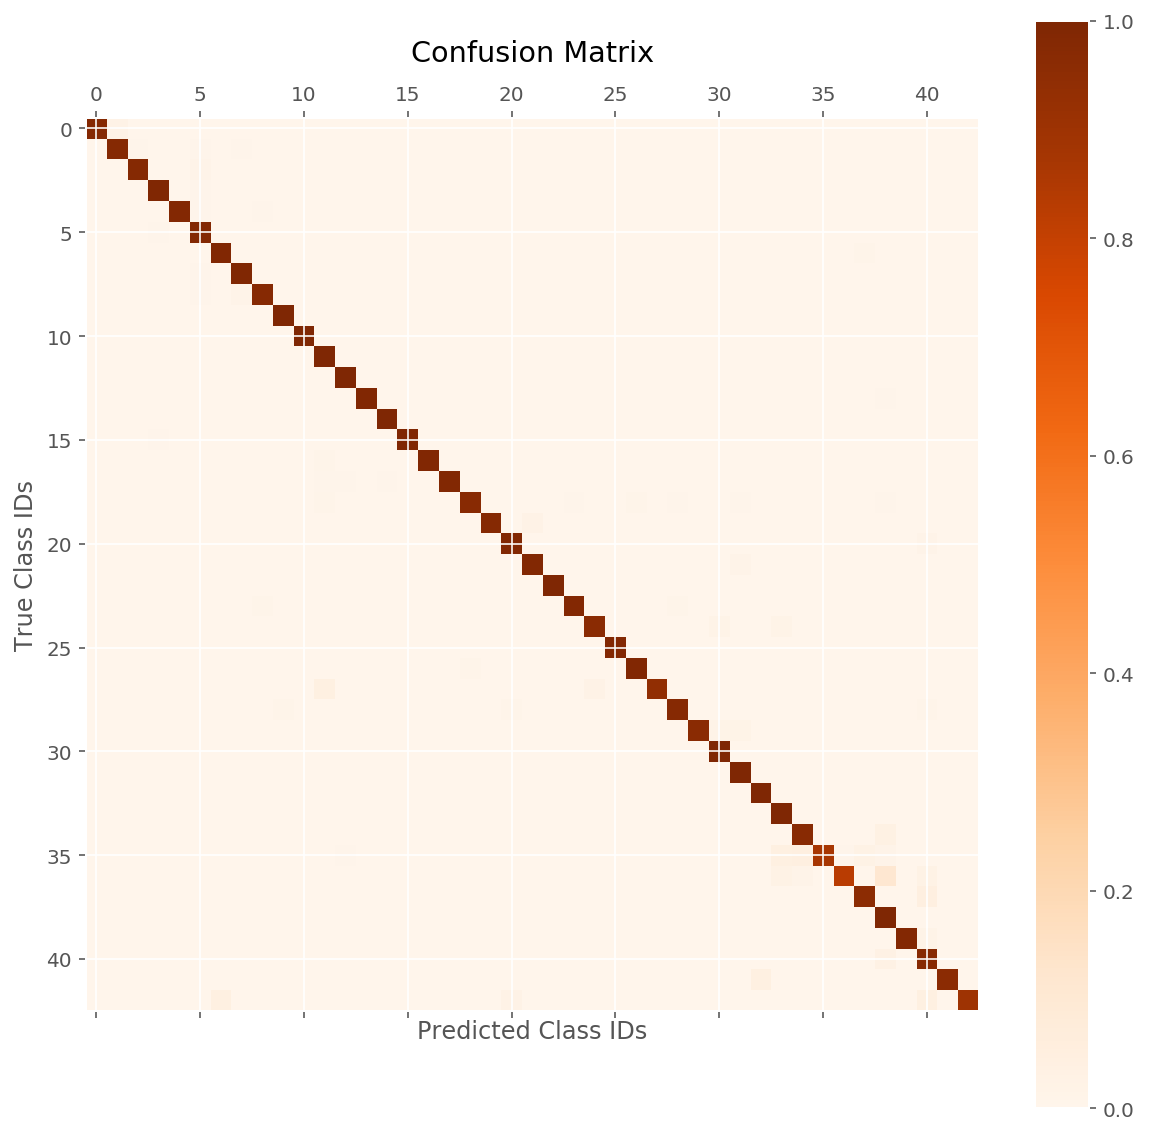

12 Priority road                                      100.00% 1672
14 Stop                                               100.00%  621
22 Bumpy road                                         100.00%  310
30 Beware of ice/snow                                 100.00%  358
31 Wild animals crossing                              100.00%  621
32 End of all speed and passing limits                100.00%  191
33 Turn right ahead                                   100.00%  548
38 Keep right                                         100.00% 1648
10 No passing for vehicles over 3.5 metric tons        99.76% 1600
 9 No passing                                          99.67% 1170
11 Right-of-way at the next intersection               99.63% 1051
 7 Speed limit (100km/h)                               99.32% 1146
 3 Speed limit (60km/h)                                99.31% 1122
15 No vehicles                                         99.22%  501
26 Traffic signals                                     99.18% 

In [37]:
with Session() as session:
    pipeline = build_pipeline(preprocessors, session, make_network3())
    session.load('checkpoint/network3_epochs-20_lr-0.5e-3.ckpt')  
    pred = pipeline.predict(X_valid)
    
# examine confusionconfusion_matrixix
cm = confusion_matrix(y_valid, pred)
plot_confusion_matrix(cm)
print_confusion_matrix(cm)

**Observation**:

The performance is almost the same  or slightly better.  The learning curve looks much smoother.  The average accuracy per class is slightly better, too.  Overall, I believe the smaller learning rate was a worthy change.

### Netowrk 3 Even Smaller Learning Rate

Epoch:   0 Train Score: 0.547 Evaluation Score: 0.543
Epoch:   1 Train Score: 0.718 Evaluation Score: 0.718
Epoch:   2 Train Score: 0.803 Evaluation Score: 0.797
Epoch:   3 Train Score: 0.847 Evaluation Score: 0.835
Epoch:   4 Train Score: 0.877 Evaluation Score: 0.875
Epoch:   5 Train Score: 0.907 Evaluation Score: 0.899
Epoch:   6 Train Score: 0.920 Evaluation Score: 0.915
Epoch:   7 Train Score: 0.934 Evaluation Score: 0.930
Epoch:   8 Train Score: 0.938 Evaluation Score: 0.931
Epoch:   9 Train Score: 0.944 Evaluation Score: 0.937
Epoch:  10 Train Score: 0.951 Evaluation Score: 0.945
Epoch:  11 Train Score: 0.958 Evaluation Score: 0.953
Epoch:  12 Train Score: 0.961 Evaluation Score: 0.955
Epoch:  13 Train Score: 0.964 Evaluation Score: 0.958
Epoch:  14 Train Score: 0.972 Evaluation Score: 0.965
Epoch:  15 Train Score: 0.972 Evaluation Score: 0.966
Epoch:  16 Train Score: 0.966 Evaluation Score: 0.965
Epoch:  17 Train Score: 0.976 Evaluation Score: 0.972
Epoch:  18 Train Score: 0.97

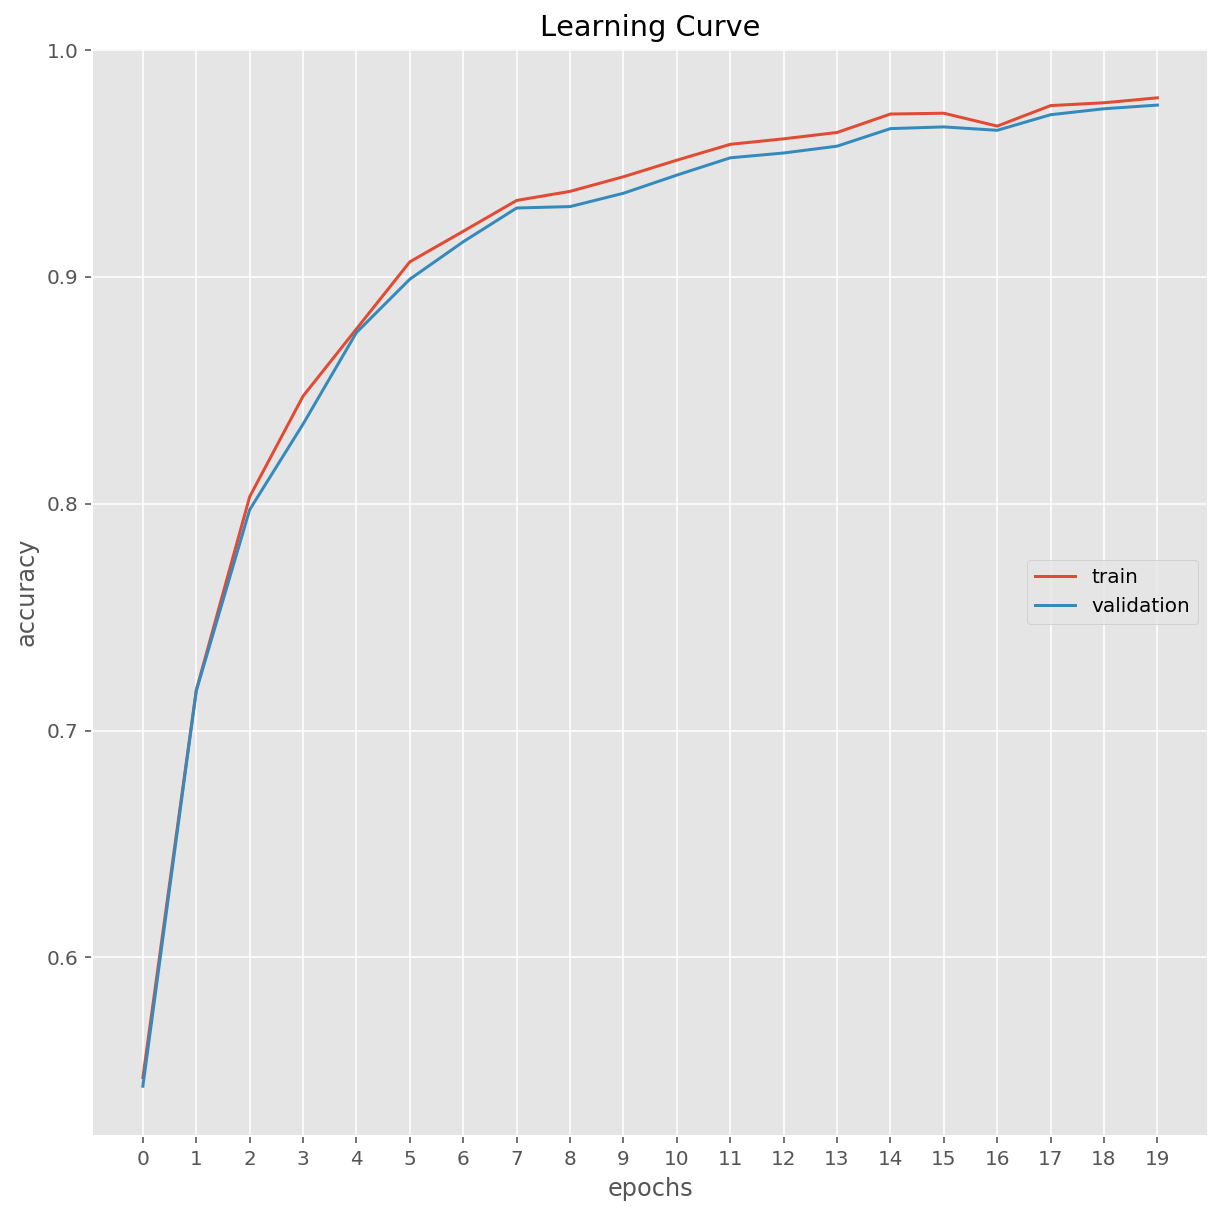

In [38]:
with Session() as session:
    pipeline = build_pipeline(preprocessors, session, make_network3(), make_adam(1.0e-4)) # <== lower learning rate
    learning_curve = train_evaluate(pipeline, epochs=20)
    session.save('checkpoint/network3_epochs-20_lr-1.0e-4.ckpt')
    
show_learning_curve(learning_curve)

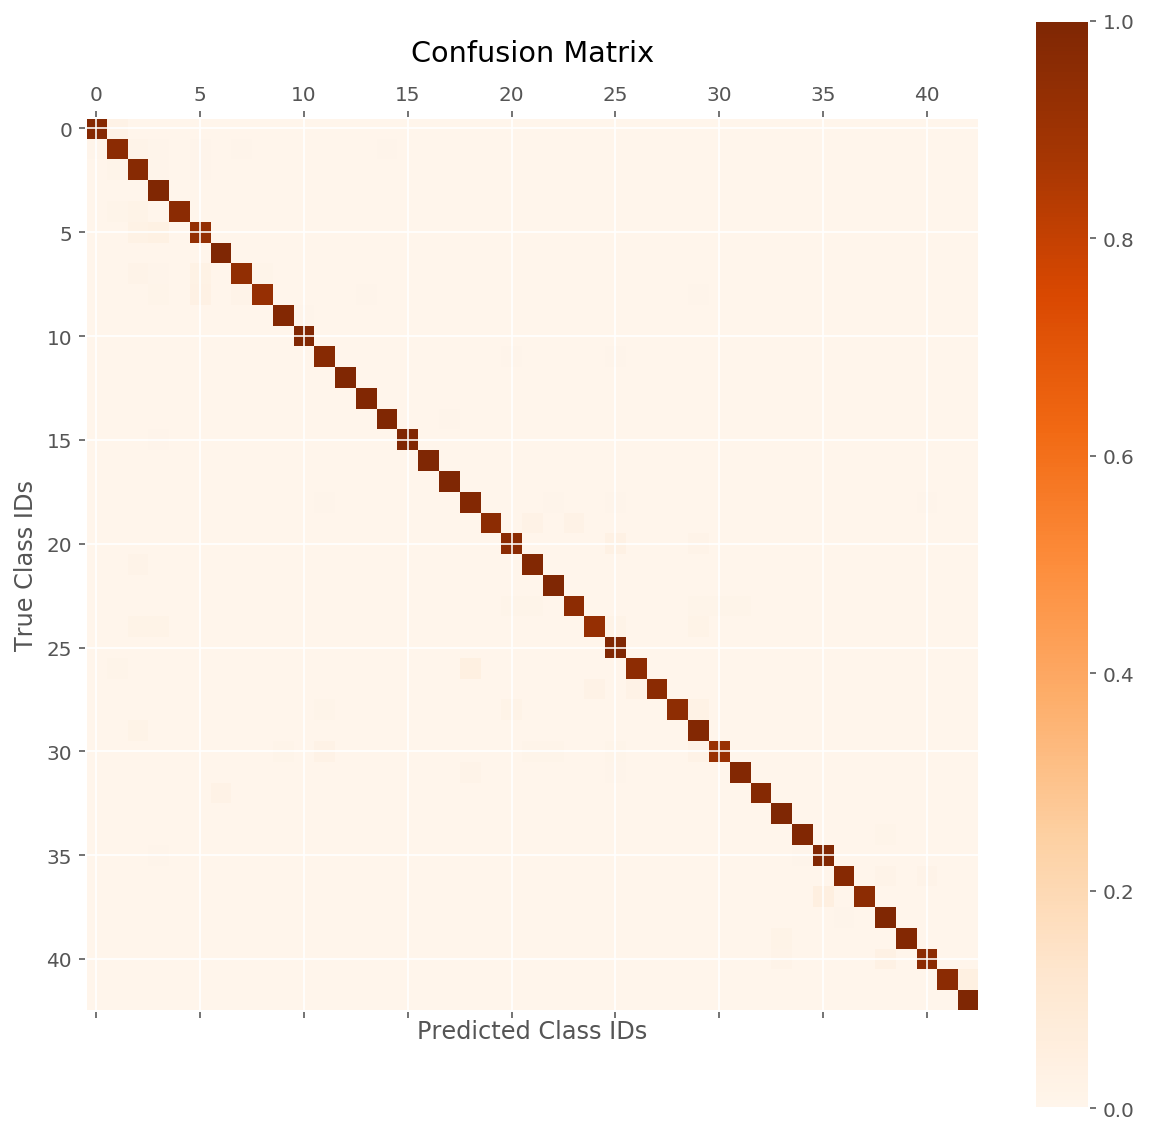

 6 End of speed limit (80km/h)                        100.00%  334
16 Vehicles over 3.5 metric tons prohibited           100.00%  334
17 No entry                                           100.00%  884
22 Bumpy road                                         100.00%  310
33 Turn right ahead                                   100.00%  548
42 End of no passing by vehicles over 3.5 metric tons 100.00%  191
25 Road work                                           99.67% 1194
14 Stop                                                99.37%  621
 3 Speed limit (60km/h)                                99.31% 1122
12 Priority road                                       99.30% 1672
38 Keep right                                          99.29% 1648
10 No passing for vehicles over 3.5 metric tons        99.27% 1600
15 No vehicles                                         99.22%  501
35 Ahead only                                          99.18%  955
13 Yield                                               99.09% 

In [39]:
with Session() as session:
    pipeline = build_pipeline(preprocessors, session, make_network3())
    session.load('checkpoint/network3_epochs-20_lr-1.0e-4.ckpt')  
    pred = pipeline.predict(X_valid)
    
# examine confusionconfusion_matrixix
cm = confusion_matrix(y_valid, pred)
plot_confusion_matrix(cm)
print_confusion_matrix(cm)

**Observation**:

- The performance is worse and it seems to show some overfitting in the end.  
- The learning curve is much more smoother.
- The mean accuracy per class is worse and its standard devaition is bigger.

Let's stick with the previous learning rate for the time being.

## Network 4

Let's try leaky ReLU (to avoid dead ReLU issue if any)

Epoch:   0 Train Score: 0.859 Evaluation Score: 0.856
Epoch:   1 Train Score: 0.935 Evaluation Score: 0.930
Epoch:   2 Train Score: 0.955 Evaluation Score: 0.951
Epoch:   3 Train Score: 0.958 Evaluation Score: 0.960
Epoch:   4 Train Score: 0.970 Evaluation Score: 0.966
Epoch:   5 Train Score: 0.976 Evaluation Score: 0.974
Epoch:   6 Train Score: 0.978 Evaluation Score: 0.977
Epoch:   7 Train Score: 0.981 Evaluation Score: 0.981
Epoch:   8 Train Score: 0.981 Evaluation Score: 0.979
Epoch:   9 Train Score: 0.985 Evaluation Score: 0.984
Epoch:  10 Train Score: 0.988 Evaluation Score: 0.984
Epoch:  11 Train Score: 0.987 Evaluation Score: 0.984
Epoch:  12 Train Score: 0.990 Evaluation Score: 0.987
Epoch:  13 Train Score: 0.989 Evaluation Score: 0.987
Epoch:  14 Train Score: 0.991 Evaluation Score: 0.987
Epoch:  15 Train Score: 0.986 Evaluation Score: 0.983
Epoch:  16 Train Score: 0.990 Evaluation Score: 0.987
Epoch:  17 Train Score: 0.985 Evaluation Score: 0.983
Epoch:  18 Train Score: 0.99

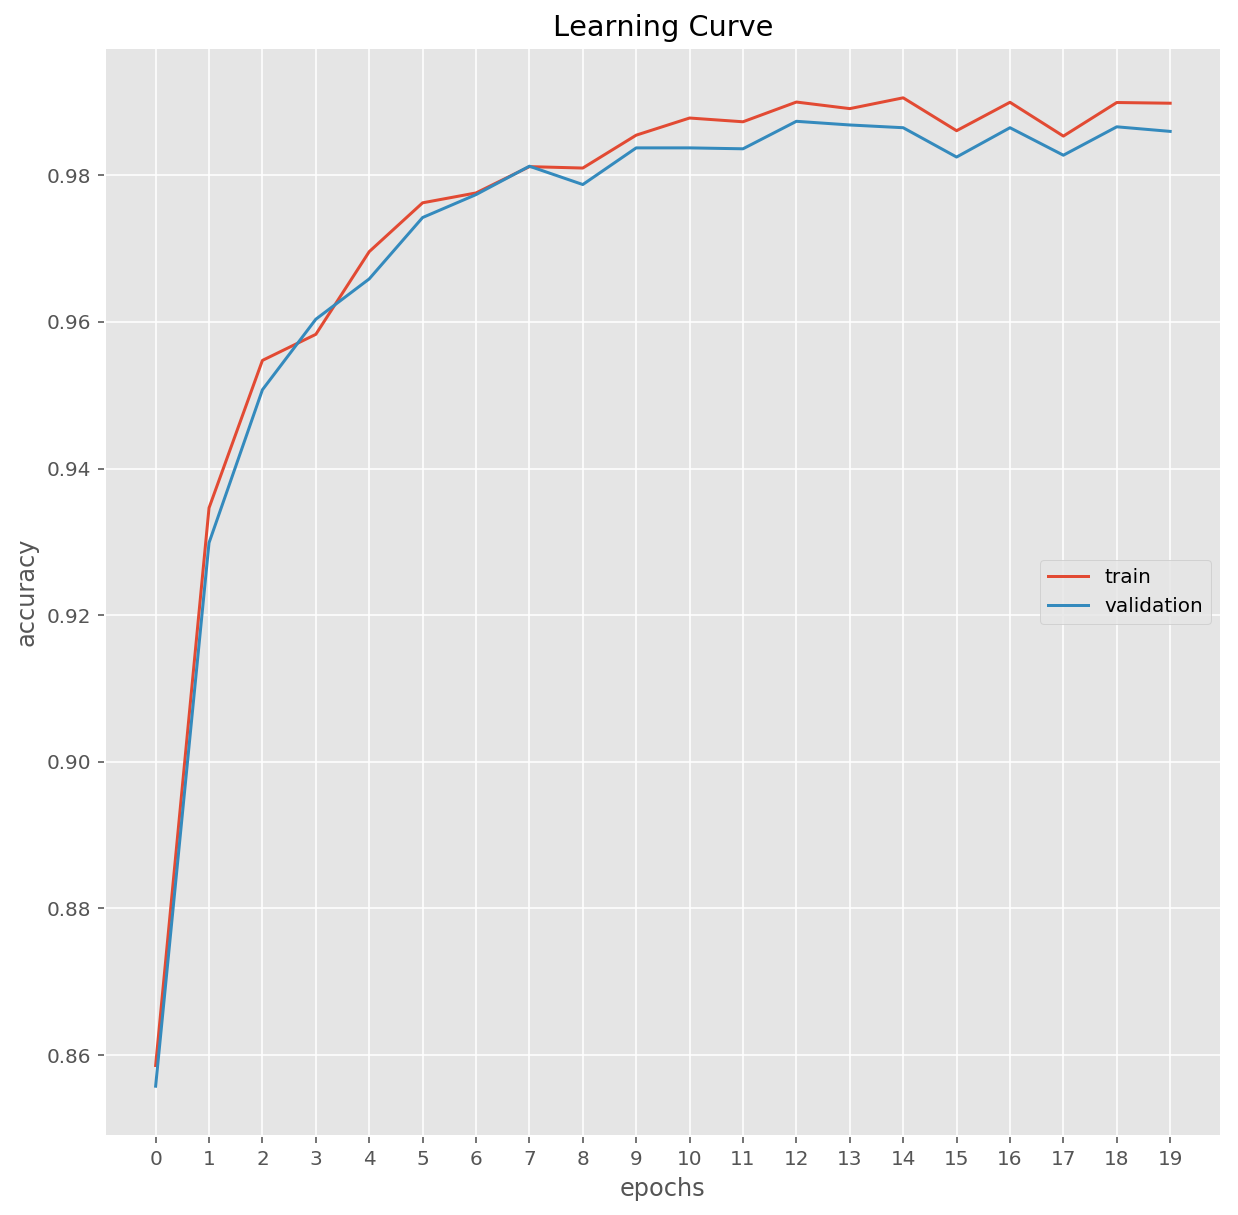

In [40]:
def make_network4(input_shape=INPUT_SHAPE):
    return (NeuralNetwork()
            .input(input_shape)
            .conv([5, 5, 24])
            .max_pool()
            .relu(leak_ratio=0.01) # <== leaky ReLU
            .conv([5, 5, 64])
            .max_pool()
            .relu(leak_ratio=0.01) # <== leaky ReLU
            .flatten()
            .dense(480)
            .relu(leak_ratio=0.01) # <== leaky ReLU
            .dense(N_CLASSES))

with Session() as session:
    pipeline = build_pipeline(preprocessors, session, make_network4(), make_adam(0.5e-3))
    learning_curve = train_evaluate(pipeline, epochs=20)
    session.save('checkpoint/network4.ckpt')

show_learning_curve(learning_curve)

**Observation**:

No improvment.

## Network 5

ELU (Exponential Linear Unit) activation which is supposed to be faster to learn than ReLU.

Reference: http://www.picalike.com/blog/2015/11/28/relu-was-yesterday-tomorrow-comes-elu/

Epoch:   0 Train Score: 0.808 Evaluation Score: 0.803
Epoch:   1 Train Score: 0.889 Evaluation Score: 0.884
Epoch:   2 Train Score: 0.922 Evaluation Score: 0.918
Epoch:   3 Train Score: 0.941 Evaluation Score: 0.935
Epoch:   4 Train Score: 0.939 Evaluation Score: 0.937
Epoch:   5 Train Score: 0.952 Evaluation Score: 0.949
Epoch:   6 Train Score: 0.944 Evaluation Score: 0.943
Epoch:   7 Train Score: 0.963 Evaluation Score: 0.960
Epoch:   8 Train Score: 0.962 Evaluation Score: 0.959
Epoch:   9 Train Score: 0.964 Evaluation Score: 0.963
Epoch:  10 Train Score: 0.970 Evaluation Score: 0.965
Epoch:  11 Train Score: 0.973 Evaluation Score: 0.972
Epoch:  12 Train Score: 0.974 Evaluation Score: 0.969
Epoch:  13 Train Score: 0.972 Evaluation Score: 0.966
Epoch:  14 Train Score: 0.977 Evaluation Score: 0.976
Epoch:  15 Train Score: 0.978 Evaluation Score: 0.977
Epoch:  16 Train Score: 0.974 Evaluation Score: 0.970
Epoch:  17 Train Score: 0.979 Evaluation Score: 0.976
Epoch:  18 Train Score: 0.97

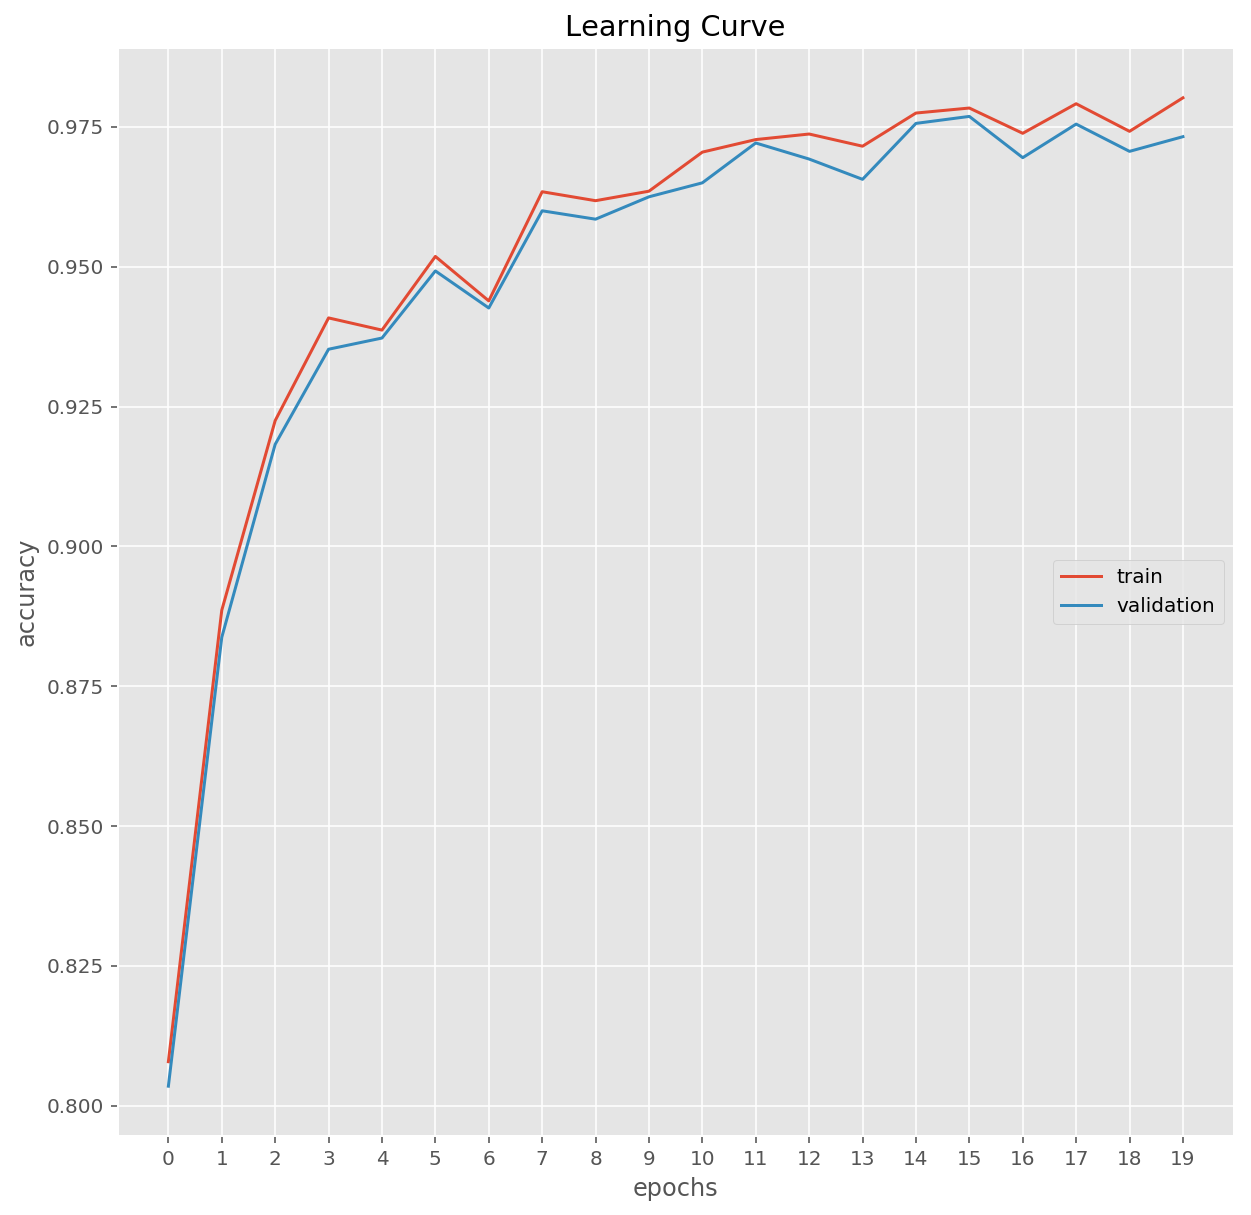

In [41]:
def make_network5(input_shape=INPUT_SHAPE):
    return (NeuralNetwork()
            .input(input_shape)
            .conv([5, 5, 24])
            .max_pool()
            .elu()              # <== ELU
            .conv([5, 5, 64])
            .max_pool()
            .elu()              # <== ELU
            .flatten()
            .dense(480)
            .elu()              # <== ELU
            .dense(N_CLASSES))

with Session() as session:
    pipeline = build_pipeline(preprocessors, session, make_network5(), make_adam(0.5e-3))
    learning_curve = train_evaluate(pipeline, epochs=20)
    session.save('checkpoint/network5.ckpt')
    
show_learning_curve(learning_curve)

**Observation**:

The permance is worse.  Also, it did not learn faster.

## Network 6

Let's try smaller initial weight value.

Epoch:   0 Train Score: 0.800 Evaluation Score: 0.796
Epoch:   1 Train Score: 0.910 Evaluation Score: 0.909
Epoch:   2 Train Score: 0.948 Evaluation Score: 0.944
Epoch:   3 Train Score: 0.956 Evaluation Score: 0.955
Epoch:   4 Train Score: 0.965 Evaluation Score: 0.958
Epoch:   5 Train Score: 0.965 Evaluation Score: 0.960
Epoch:   6 Train Score: 0.974 Evaluation Score: 0.973
Epoch:   7 Train Score: 0.978 Evaluation Score: 0.973
Epoch:   8 Train Score: 0.974 Evaluation Score: 0.969
Epoch:   9 Train Score: 0.970 Evaluation Score: 0.967
Epoch:  10 Train Score: 0.971 Evaluation Score: 0.968
Epoch:  11 Train Score: 0.983 Evaluation Score: 0.982
Epoch:  12 Train Score: 0.984 Evaluation Score: 0.983
Epoch:  13 Train Score: 0.987 Evaluation Score: 0.985
Epoch:  14 Train Score: 0.987 Evaluation Score: 0.985
Epoch:  15 Train Score: 0.985 Evaluation Score: 0.983
Epoch:  16 Train Score: 0.988 Evaluation Score: 0.985
Epoch:  17 Train Score: 0.989 Evaluation Score: 0.985
Epoch:  18 Train Score: 0.98

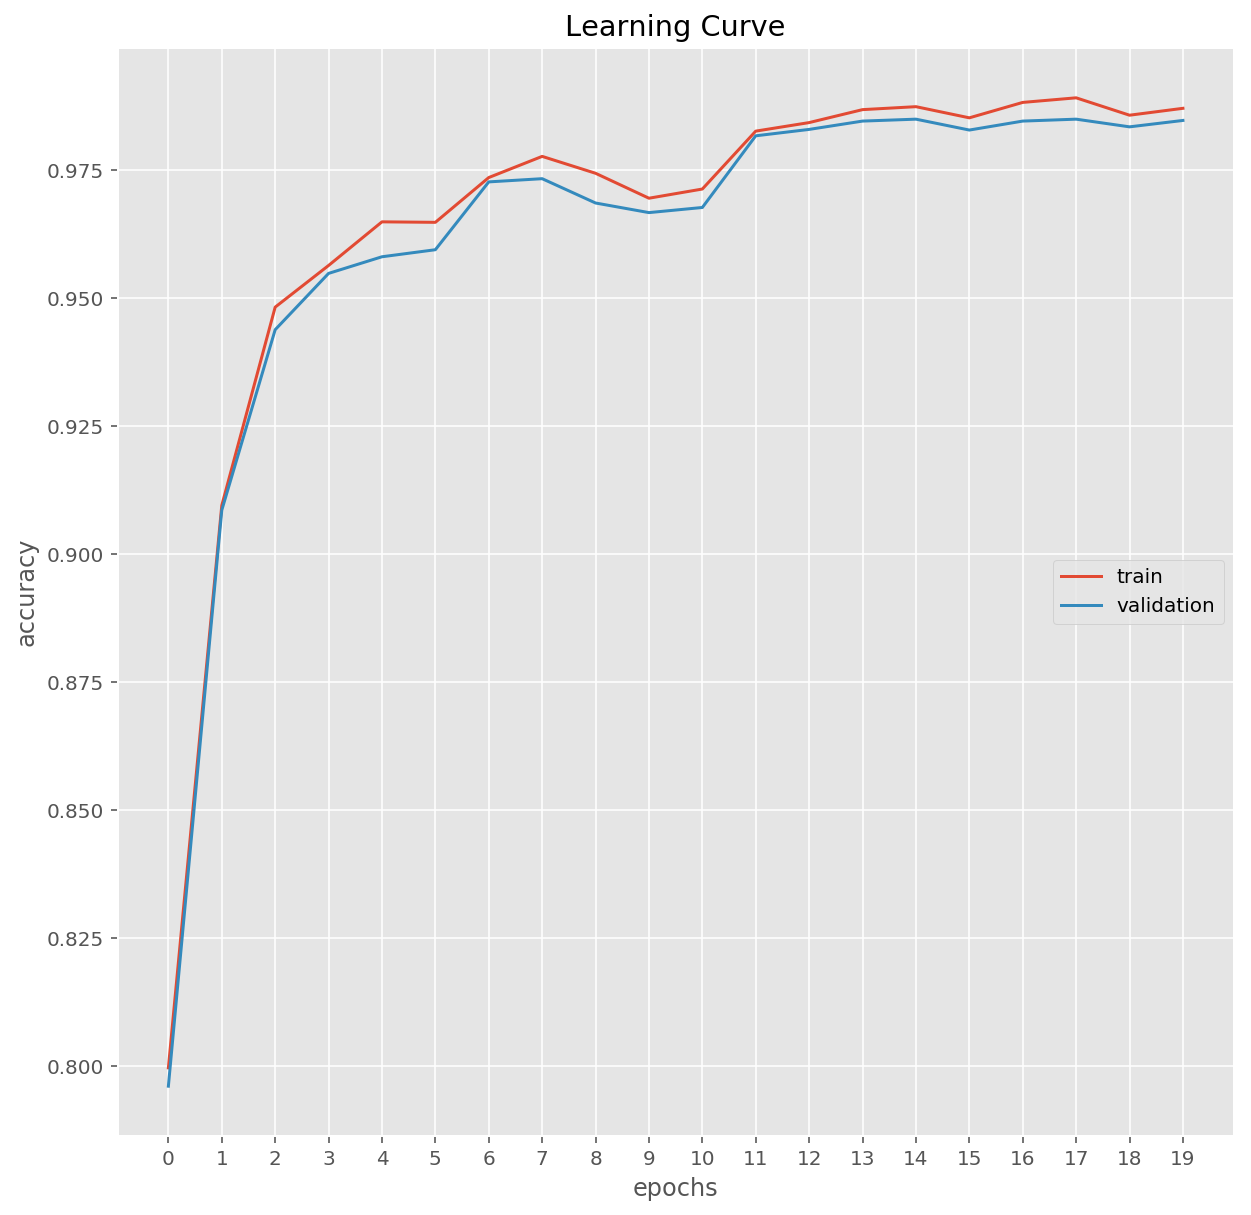

In [42]:
def make_network6(input_shape=INPUT_SHAPE):
    return (NeuralNetwork(weight_sigma=0.01) # <== smaller weight sigma
            .input(input_shape)
            .conv([5, 5, 24])
            .max_pool()
            .relu()
            .conv([5, 5, 64])
            .max_pool()
            .relu()
            .flatten()
            .dense(480)
            .relu()
            .dense(N_CLASSES))

with Session() as session:
    pipeline = build_pipeline(preprocessors, session, make_network6(), make_adam(0.5e-3))
    learning_curve = train_evaluate(pipeline, epochs=20)
    session.save('checkpoint/network6.ckpt')
    
show_learning_curve(learning_curve)

**Observation**:

Not an improvement - a bit worse.

## Network 7

Adding one more dense layer.

Epoch:   0 Train Score: 0.815 Evaluation Score: 0.809
Epoch:   1 Train Score: 0.915 Evaluation Score: 0.917
Epoch:   2 Train Score: 0.926 Evaluation Score: 0.924
Epoch:   3 Train Score: 0.960 Evaluation Score: 0.962
Epoch:   4 Train Score: 0.965 Evaluation Score: 0.964
Epoch:   5 Train Score: 0.975 Evaluation Score: 0.973
Epoch:   6 Train Score: 0.967 Evaluation Score: 0.967
Epoch:   7 Train Score: 0.967 Evaluation Score: 0.962
Epoch:   8 Train Score: 0.980 Evaluation Score: 0.978
Epoch:   9 Train Score: 0.980 Evaluation Score: 0.977
Epoch:  10 Train Score: 0.975 Evaluation Score: 0.970
Epoch:  11 Train Score: 0.988 Evaluation Score: 0.984
Epoch:  12 Train Score: 0.984 Evaluation Score: 0.981
Epoch:  13 Train Score: 0.987 Evaluation Score: 0.981
Epoch:  14 Train Score: 0.978 Evaluation Score: 0.976
Epoch:  15 Train Score: 0.981 Evaluation Score: 0.975
Epoch:  16 Train Score: 0.989 Evaluation Score: 0.989
Epoch:  17 Train Score: 0.984 Evaluation Score: 0.983
Epoch:  18 Train Score: 0.98

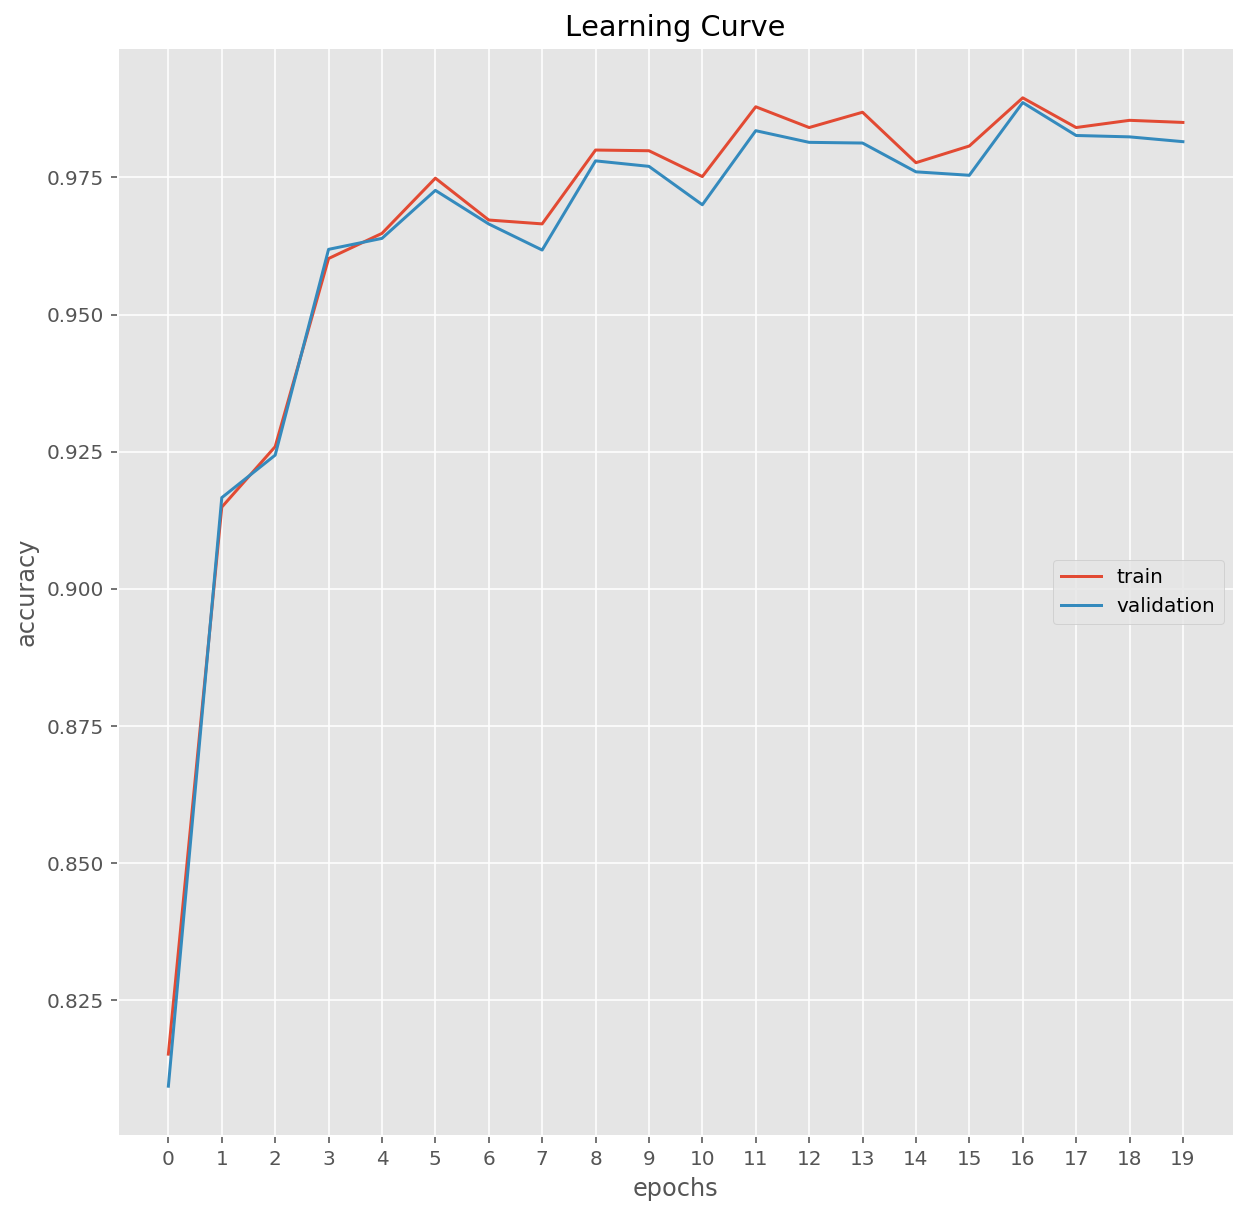

In [43]:
def make_network7(input_shape=INPUT_SHAPE):
    return (NeuralNetwork()
            .input(input_shape)
            .conv([5, 5, 24])
            .max_pool()
            .relu()
            .conv([5, 5, 64])
            .max_pool()
            .relu()
            .flatten()
            .dense(480)
            .relu()
            .dense(240) # <== one more dense layer
            .relu()
            .dense(N_CLASSES))

with Session() as session:
    pipeline = build_pipeline(preprocessors, session, make_network7(), make_adam(0.5e-3))
    learning_curve = train_evaluate(pipeline, epochs=20)
    session.save('checkpoint/network7.ckpt')
    
show_learning_curve(learning_curve)

**Observation**:

No improvment - a bit worse.

## Network 8

The same as Network 3 but using MaxPooling after ReLU.

Epoch:   0 Train Score: 0.828 Evaluation Score: 0.824
Epoch:   1 Train Score: 0.916 Evaluation Score: 0.917
Epoch:   2 Train Score: 0.941 Evaluation Score: 0.940
Epoch:   3 Train Score: 0.963 Evaluation Score: 0.959
Epoch:   4 Train Score: 0.964 Evaluation Score: 0.960
Epoch:   5 Train Score: 0.977 Evaluation Score: 0.976
Epoch:   6 Train Score: 0.973 Evaluation Score: 0.971
Epoch:   7 Train Score: 0.984 Evaluation Score: 0.983
Epoch:   8 Train Score: 0.982 Evaluation Score: 0.981
Epoch:   9 Train Score: 0.981 Evaluation Score: 0.980
Epoch:  10 Train Score: 0.979 Evaluation Score: 0.977
Epoch:  11 Train Score: 0.980 Evaluation Score: 0.979
Epoch:  12 Train Score: 0.984 Evaluation Score: 0.980
Epoch:  13 Train Score: 0.985 Evaluation Score: 0.980
Epoch:  14 Train Score: 0.988 Evaluation Score: 0.988
Epoch:  15 Train Score: 0.990 Evaluation Score: 0.986
Epoch:  16 Train Score: 0.990 Evaluation Score: 0.988
Epoch:  17 Train Score: 0.990 Evaluation Score: 0.985
Epoch:  18 Train Score: 0.99

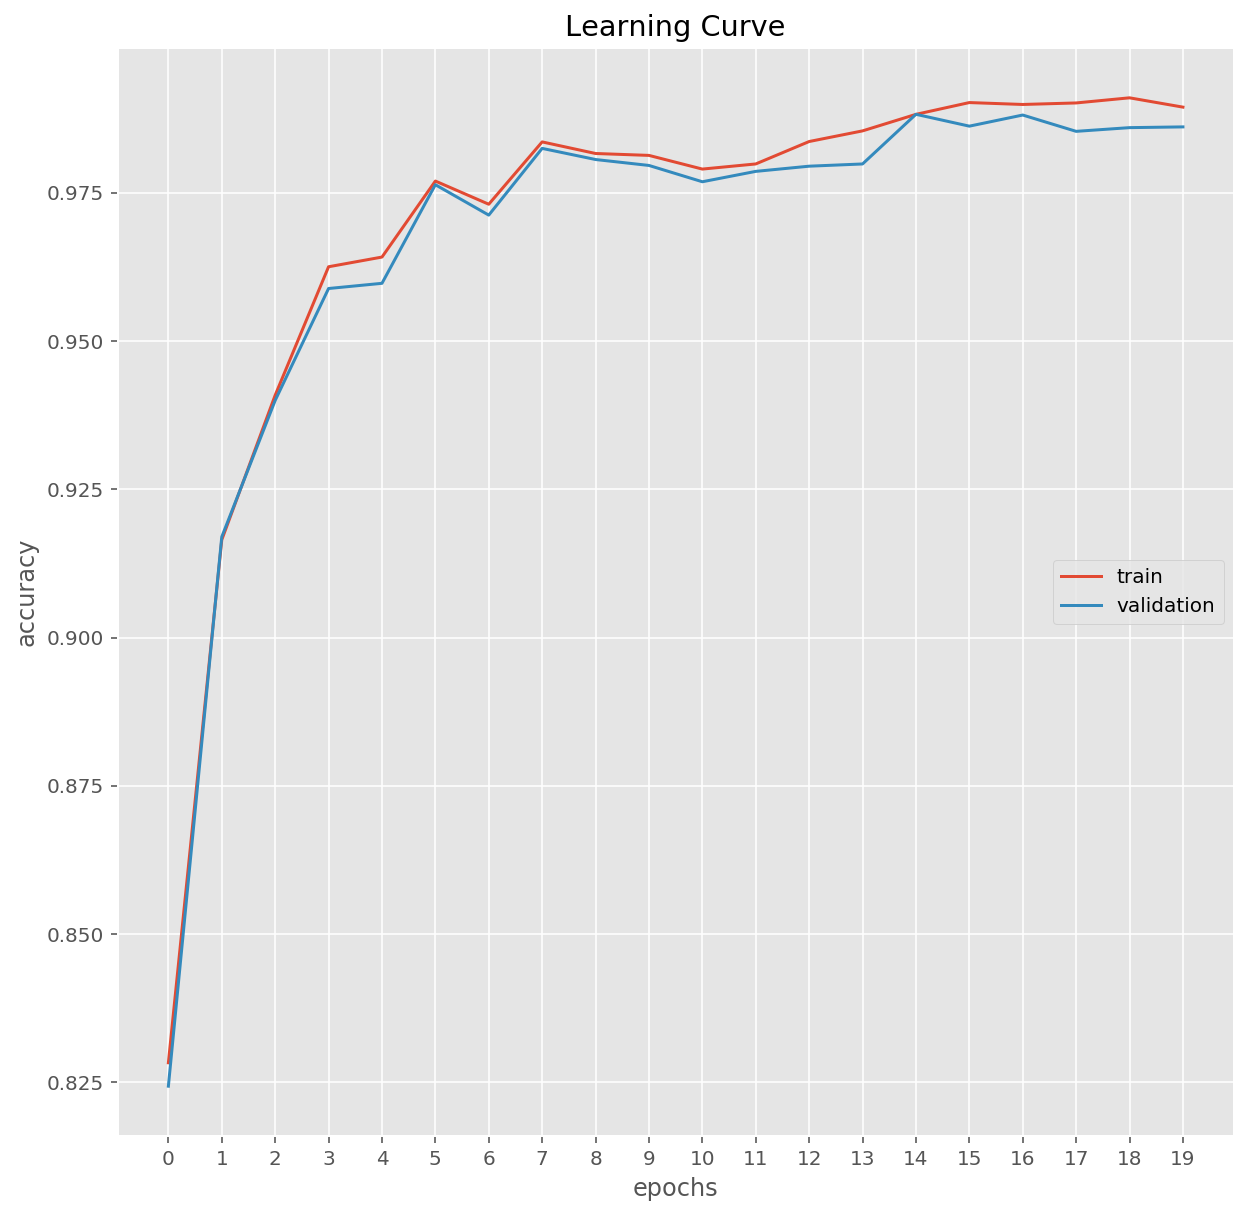

In [44]:
def make_network8(input_shape=INPUT_SHAPE):
    return (NeuralNetwork()
            .input(input_shape)
            .conv([5, 5, 24])
            .relu()     
            .max_pool() # <== after ReLU
            .conv([5, 5, 64])
            .relu()
            .max_pool() # <== after ReLU
            .flatten()
            .dense(480)
            .relu()
            .dense(N_CLASSES))

with Session() as session:
    pipeline = build_pipeline(preprocessors, session, make_network8(), make_adam(0.5e-3))
    learning_curve = train_evaluate(pipeline, epochs=20)
    session.save('checkpoint/network8.ckpt')
    
show_learning_curve(learning_curve)

**Observation**:

No improvement - about the same.

## Network 9

Let's try 3 convolutional layers.

Epoch:   0 Train Score: 0.848 Evaluation Score: 0.852
Epoch:   1 Train Score: 0.912 Evaluation Score: 0.907
Epoch:   2 Train Score: 0.945 Evaluation Score: 0.948
Epoch:   3 Train Score: 0.956 Evaluation Score: 0.959
Epoch:   4 Train Score: 0.966 Evaluation Score: 0.964
Epoch:   5 Train Score: 0.969 Evaluation Score: 0.961
Epoch:   6 Train Score: 0.973 Evaluation Score: 0.971
Epoch:   7 Train Score: 0.975 Evaluation Score: 0.976
Epoch:   8 Train Score: 0.980 Evaluation Score: 0.978
Epoch:   9 Train Score: 0.980 Evaluation Score: 0.974
Epoch:  10 Train Score: 0.965 Evaluation Score: 0.964
Epoch:  11 Train Score: 0.976 Evaluation Score: 0.974
Epoch:  12 Train Score: 0.977 Evaluation Score: 0.974
Epoch:  13 Train Score: 0.984 Evaluation Score: 0.982
Epoch:  14 Train Score: 0.980 Evaluation Score: 0.975
Epoch:  15 Train Score: 0.974 Evaluation Score: 0.970
Epoch:  16 Train Score: 0.982 Evaluation Score: 0.980
Epoch:  17 Train Score: 0.982 Evaluation Score: 0.979
Epoch:  18 Train Score: 0.98

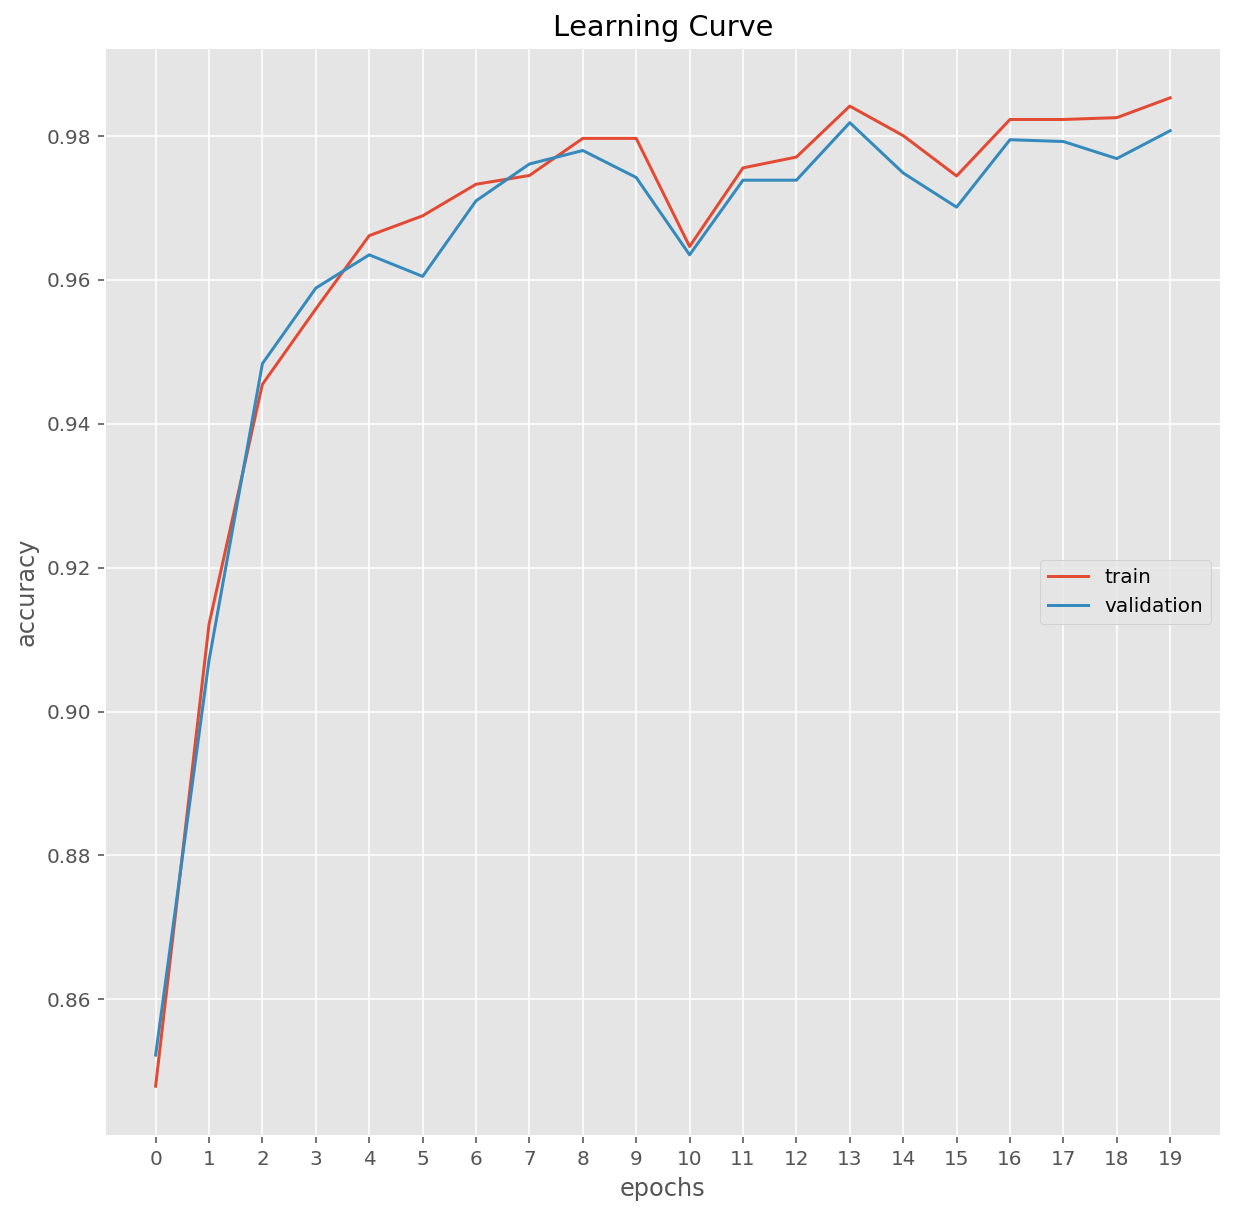

In [45]:
def make_network9(input_shape=INPUT_SHAPE):
    return (NeuralNetwork()
            .input(input_shape)
            .conv([5, 5, 24])
            .max_pool()
            .relu()
            .conv([5, 5, 64])
            .max_pool()
            .relu()
            .conv([3, 3, 64])  # <= smaller kernel here (the image is small by here)
            .max_pool()
            .relu()
            .flatten()
            .dense(480)
            .relu()
            .dense(N_CLASSES))

with Session() as session:
    pipeline = build_pipeline(preprocessors, session, make_network9(), make_adam(0.5e-3))
    learning_curve = train_evaluate(pipeline, epochs=20)
    session.save('checkpoint/network9.ckpt')
    
show_learning_curve(learning_curve)

**Observation**

No improvment - a bit worse.

## Network 3 with Momentum Optimizer

In [46]:
for momentum in [0.7, 0.8, 0.9]:
    with Session() as session:
        print('Momentum: {}'.format(momentum))
        optimizer = tf.train.MomentumOptimizer(learning_rate=0.5e-3, momentum=momentum)
        pipeline = build_pipeline(preprocessors, session, make_network3(), optimizer)
        train_evaluate(pipeline, epochs=20)
        session.save('checkpoint/network3_momentum_{}.ckpt'.format(momentum))
        print()

Momentum: 0.7
Epoch:   0 Train Score: 0.362 Evaluation Score: 0.362
Epoch:   1 Train Score: 0.476 Evaluation Score: 0.469
Epoch:   2 Train Score: 0.551 Evaluation Score: 0.545
Epoch:   3 Train Score: 0.626 Evaluation Score: 0.624
Epoch:   4 Train Score: 0.674 Evaluation Score: 0.676
Epoch:   5 Train Score: 0.708 Evaluation Score: 0.708
Epoch:   6 Train Score: 0.745 Evaluation Score: 0.737
Epoch:   7 Train Score: 0.766 Evaluation Score: 0.765
Epoch:   8 Train Score: 0.791 Evaluation Score: 0.786
Epoch:   9 Train Score: 0.793 Evaluation Score: 0.791
Epoch:  10 Train Score: 0.824 Evaluation Score: 0.824
Epoch:  11 Train Score: 0.831 Evaluation Score: 0.827
Epoch:  12 Train Score: 0.847 Evaluation Score: 0.851
Epoch:  13 Train Score: 0.862 Evaluation Score: 0.860
Epoch:  14 Train Score: 0.868 Evaluation Score: 0.862
Epoch:  15 Train Score: 0.877 Evaluation Score: 0.871
Epoch:  16 Train Score: 0.876 Evaluation Score: 0.867
Epoch:  17 Train Score: 0.888 Evaluation Score: 0.878
Epoch:  18 Tra

**Observation**:

Got worse.

## Network 3 with Balanced Class Distribution of Training Data

Will it help to have a balanced class distribution of training data?

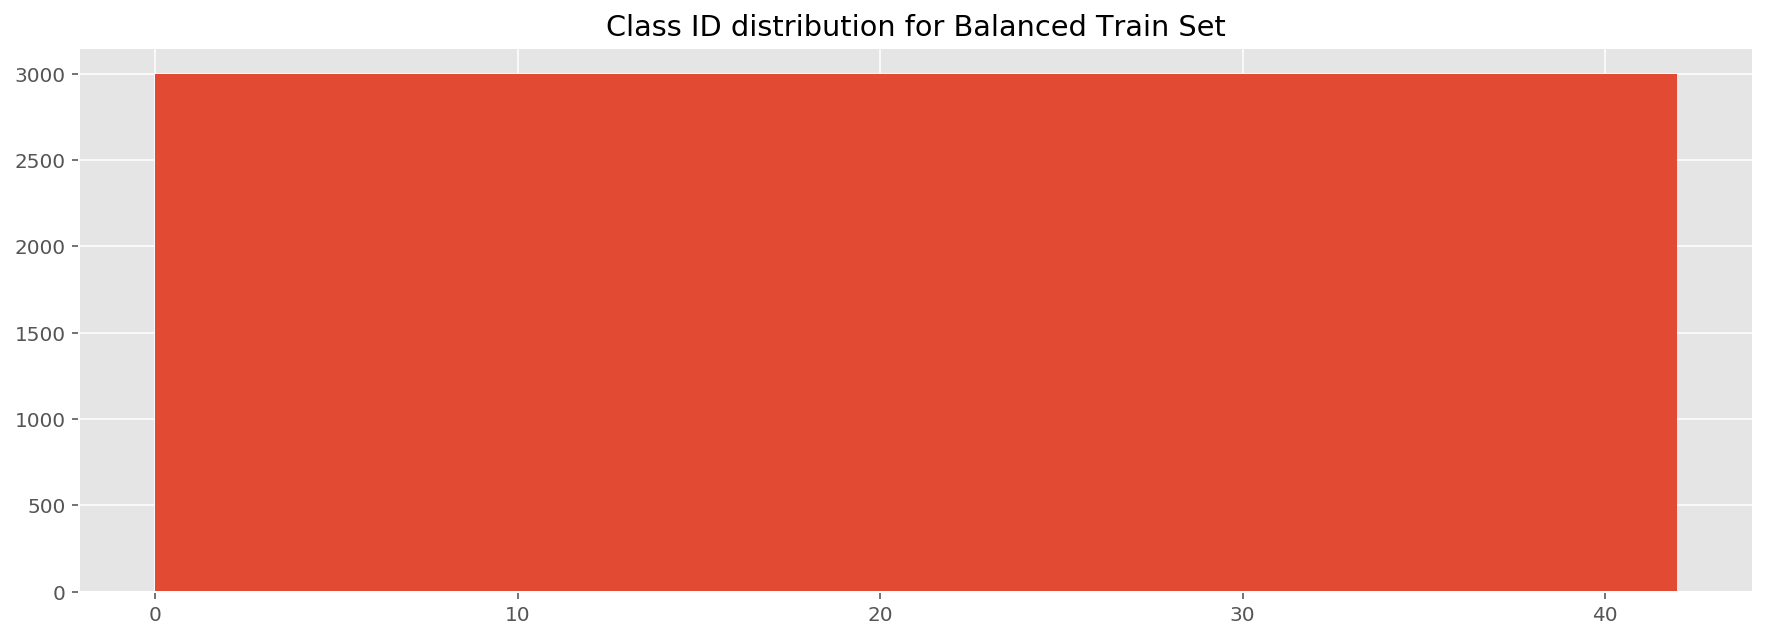

In [47]:
def balance_distribution(X, y, size):
    X_balanced = []
    y_balanced = []
    for c in range(N_CLASSES):
        data = X[y==c]
        indices = np.random.choice(sum(y==c), size)
        X_balanced.extend(X[y==c][indices])
        y_balanced.extend(y[y==c][indices])
    return np.array(X_balanced), np.array(y_balanced)

X_balanced, y_balanced = balance_distribution(X_train, y_train, 3000)

show_class_distribution(y_balanced, 'Balanced Train Set')

Let's try the balanced data set with our best pipeline (Network 3 with learning rate = 0.5e-3)

Epoch:   0 Train Score: 0.815 Evaluation Score: 0.756
Epoch:   1 Train Score: 0.911 Evaluation Score: 0.874
Epoch:   2 Train Score: 0.957 Evaluation Score: 0.938
Epoch:   3 Train Score: 0.962 Evaluation Score: 0.945
Epoch:   4 Train Score: 0.970 Evaluation Score: 0.949
Epoch:   5 Train Score: 0.976 Evaluation Score: 0.960
Epoch:   6 Train Score: 0.980 Evaluation Score: 0.969
Epoch:   7 Train Score: 0.981 Evaluation Score: 0.973
Epoch:   8 Train Score: 0.981 Evaluation Score: 0.968
Epoch:   9 Train Score: 0.986 Evaluation Score: 0.981
Epoch:  10 Train Score: 0.987 Evaluation Score: 0.980
Epoch:  11 Train Score: 0.990 Evaluation Score: 0.980
Epoch:  12 Train Score: 0.989 Evaluation Score: 0.979
Epoch:  13 Train Score: 0.983 Evaluation Score: 0.974
Epoch:  14 Train Score: 0.983 Evaluation Score: 0.975
Epoch:  15 Train Score: 0.988 Evaluation Score: 0.978
Epoch:  16 Train Score: 0.990 Evaluation Score: 0.981
Epoch:  17 Train Score: 0.989 Evaluation Score: 0.982
Epoch:  18 Train Score: 0.99

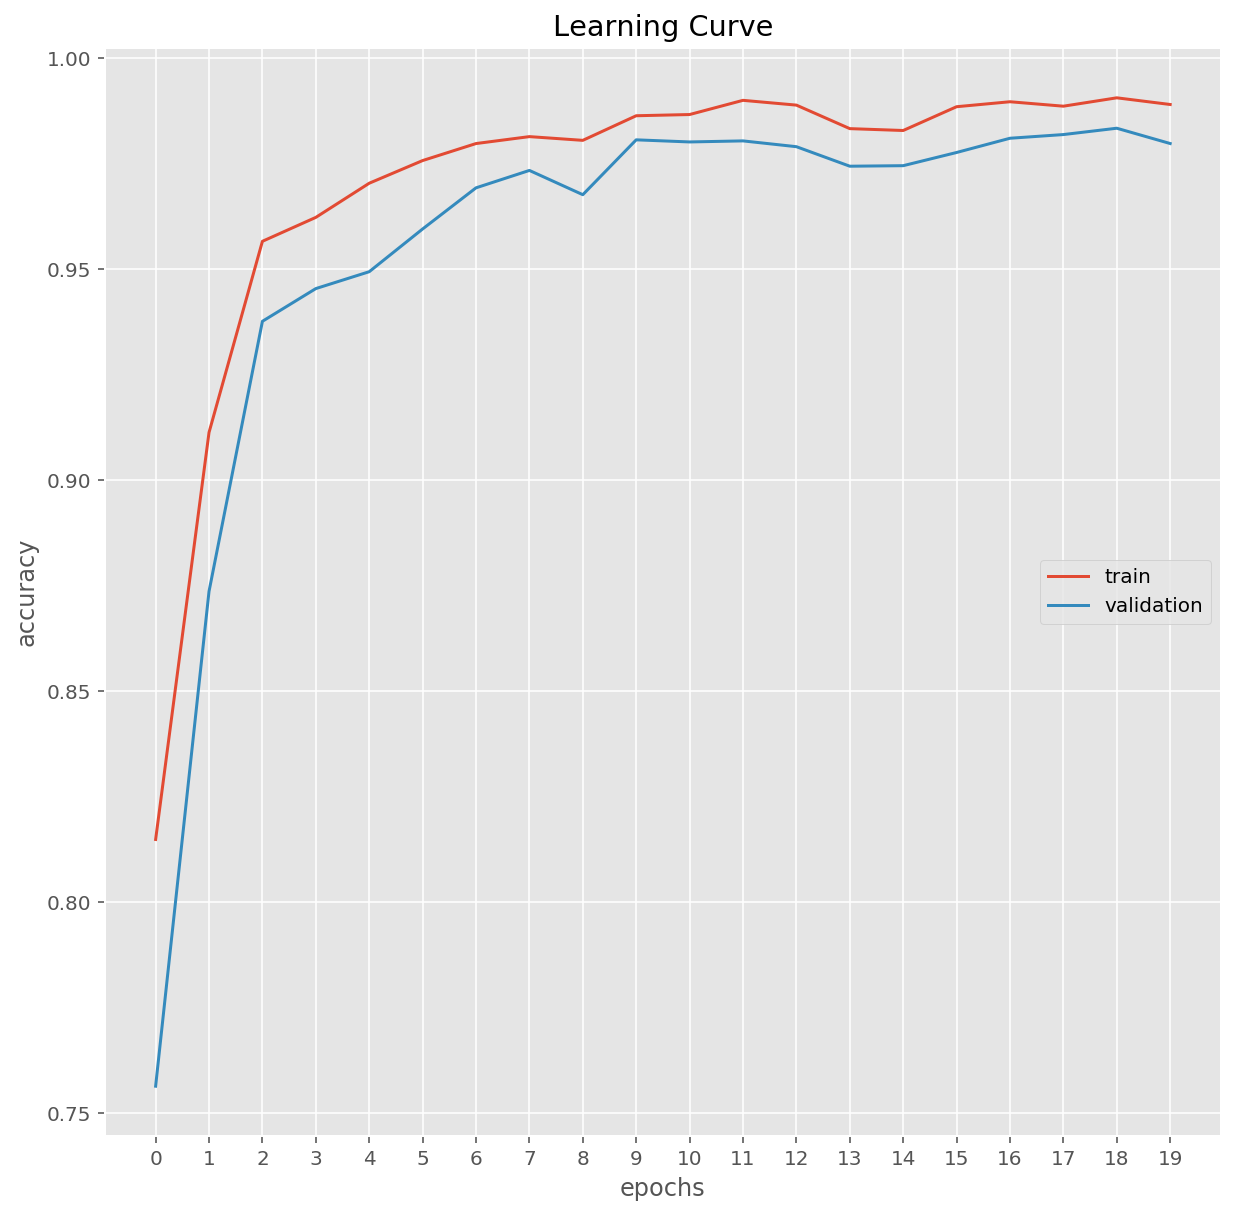

In [48]:
with Session() as session:
    pipeline = build_pipeline(preprocessors, session, make_network3(), make_adam(0.5e-3))
    learning_curve = train_evaluate(pipeline, epochs=20, train=(X_balanced, y_balanced)) # <== using the balanced train set
    session.save('checkpoint/network3_with_balanced_data.ckpt')

show_learning_curve(learning_curve)

**Observation**:

The validation accuracy is much worse than before.  This is likely because the distribution is different, indicating the network is learning the distribution which is different from the validation set.  Assuming the test set has the same kind of validation (we should not check the test set at this stage), using the balance set may not be a good idea.

Instead, we should do more epochs so that minor classes are more visible to the network.

## Network 3 with even more epochs

Let's just try with much more epochs.

Epoch:   0 Train Score: 0.840 Evaluation Score: 0.830
Epoch:   1 Train Score: 0.929 Evaluation Score: 0.929
Epoch:   2 Train Score: 0.955 Evaluation Score: 0.951
Epoch:   3 Train Score: 0.964 Evaluation Score: 0.961
Epoch:   4 Train Score: 0.973 Evaluation Score: 0.970
Epoch:   5 Train Score: 0.978 Evaluation Score: 0.972
Epoch:   6 Train Score: 0.973 Evaluation Score: 0.971
Epoch:   7 Train Score: 0.974 Evaluation Score: 0.971
Epoch:   8 Train Score: 0.986 Evaluation Score: 0.984
Epoch:   9 Train Score: 0.980 Evaluation Score: 0.976
Epoch:  10 Train Score: 0.984 Evaluation Score: 0.982
Epoch:  11 Train Score: 0.985 Evaluation Score: 0.979
Epoch:  12 Train Score: 0.989 Evaluation Score: 0.986
Epoch:  13 Train Score: 0.989 Evaluation Score: 0.983
Epoch:  14 Train Score: 0.989 Evaluation Score: 0.987
Epoch:  15 Train Score: 0.985 Evaluation Score: 0.982
Epoch:  16 Train Score: 0.989 Evaluation Score: 0.988
Epoch:  17 Train Score: 0.989 Evaluation Score: 0.988
Epoch:  18 Train Score: 0.99

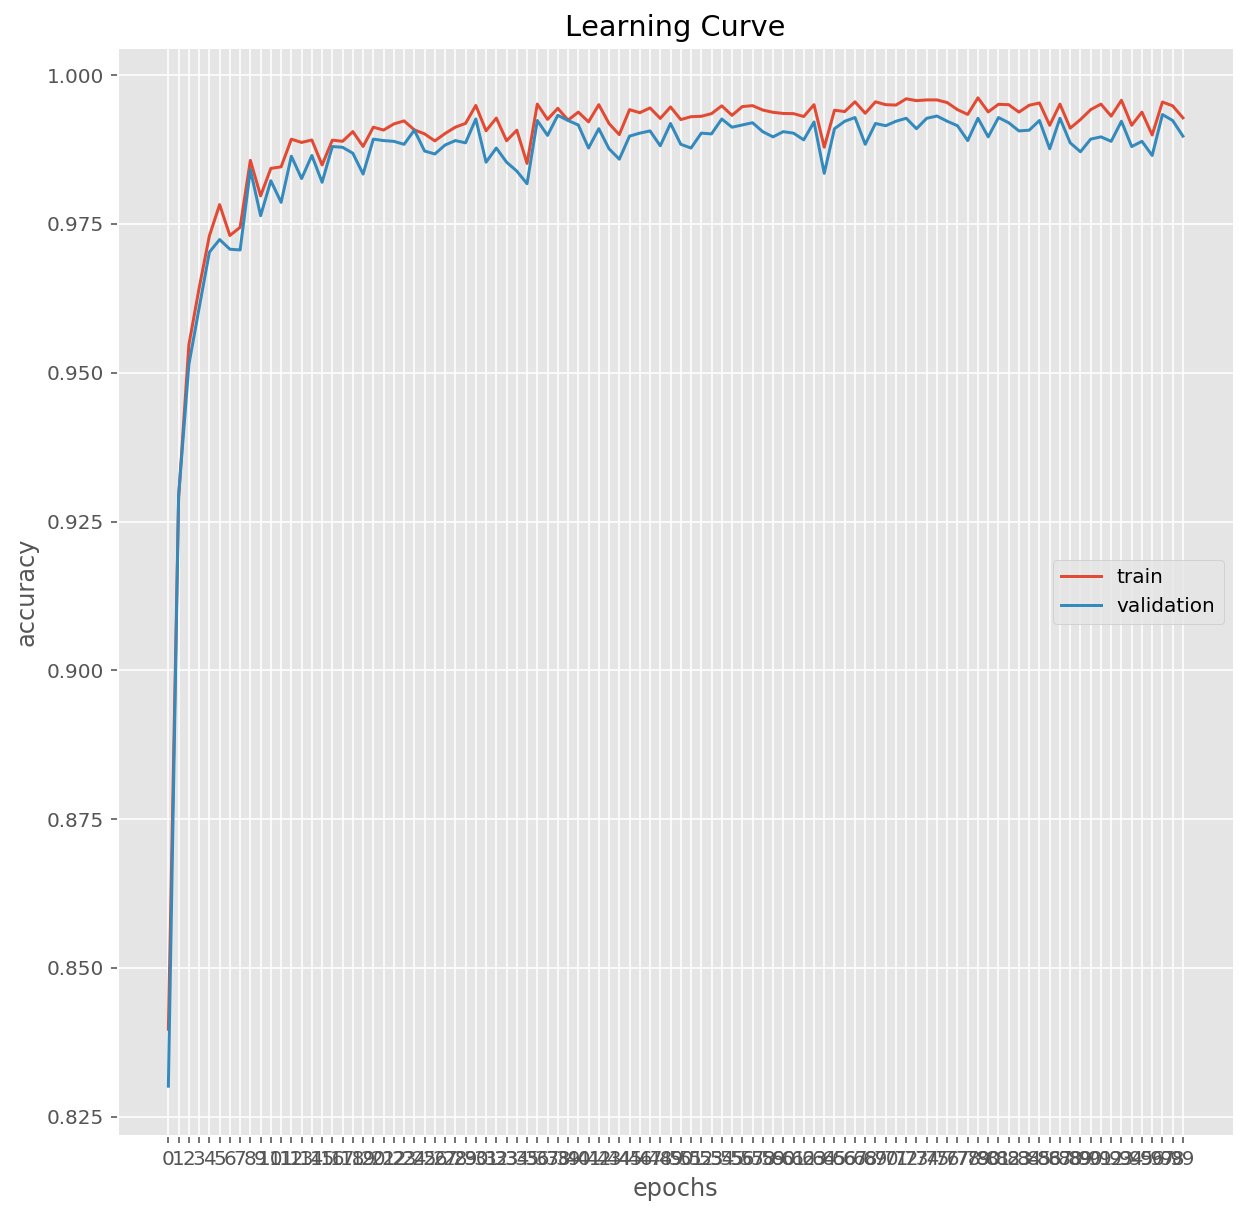

In [49]:
with Session() as session:
    pipeline = build_pipeline(preprocessors, session, make_network3(), make_adam(0.5e-3)) 
    learning_curve = train_evaluate(pipeline, epochs=100)
    
show_learning_curve(learning_curve)

**Observation**:

It performs much better now but the last several epochs are not really helping for the network to learn.  I should try smaller learning rate to see how it goes.

## Network 3 with even lower learning rate (and more epochs)

Epoch:   0 Train Score: 0.568 Evaluation Score: 0.566
Epoch:   1 Train Score: 0.725 Evaluation Score: 0.718
Epoch:   2 Train Score: 0.792 Evaluation Score: 0.781
Epoch:   3 Train Score: 0.841 Evaluation Score: 0.839
Epoch:   4 Train Score: 0.877 Evaluation Score: 0.869
Epoch:   5 Train Score: 0.900 Evaluation Score: 0.890
Epoch:   6 Train Score: 0.910 Evaluation Score: 0.900
Epoch:   7 Train Score: 0.930 Evaluation Score: 0.924
Epoch:   8 Train Score: 0.939 Evaluation Score: 0.938
Epoch:   9 Train Score: 0.943 Evaluation Score: 0.939
Epoch:  10 Train Score: 0.952 Evaluation Score: 0.949
Epoch:  11 Train Score: 0.962 Evaluation Score: 0.957
Epoch:  12 Train Score: 0.967 Evaluation Score: 0.960
Epoch:  13 Train Score: 0.966 Evaluation Score: 0.962
Epoch:  14 Train Score: 0.970 Evaluation Score: 0.965
Epoch:  15 Train Score: 0.968 Evaluation Score: 0.961
Epoch:  16 Train Score: 0.971 Evaluation Score: 0.969
Epoch:  17 Train Score: 0.978 Evaluation Score: 0.970
Epoch:  18 Train Score: 0.98

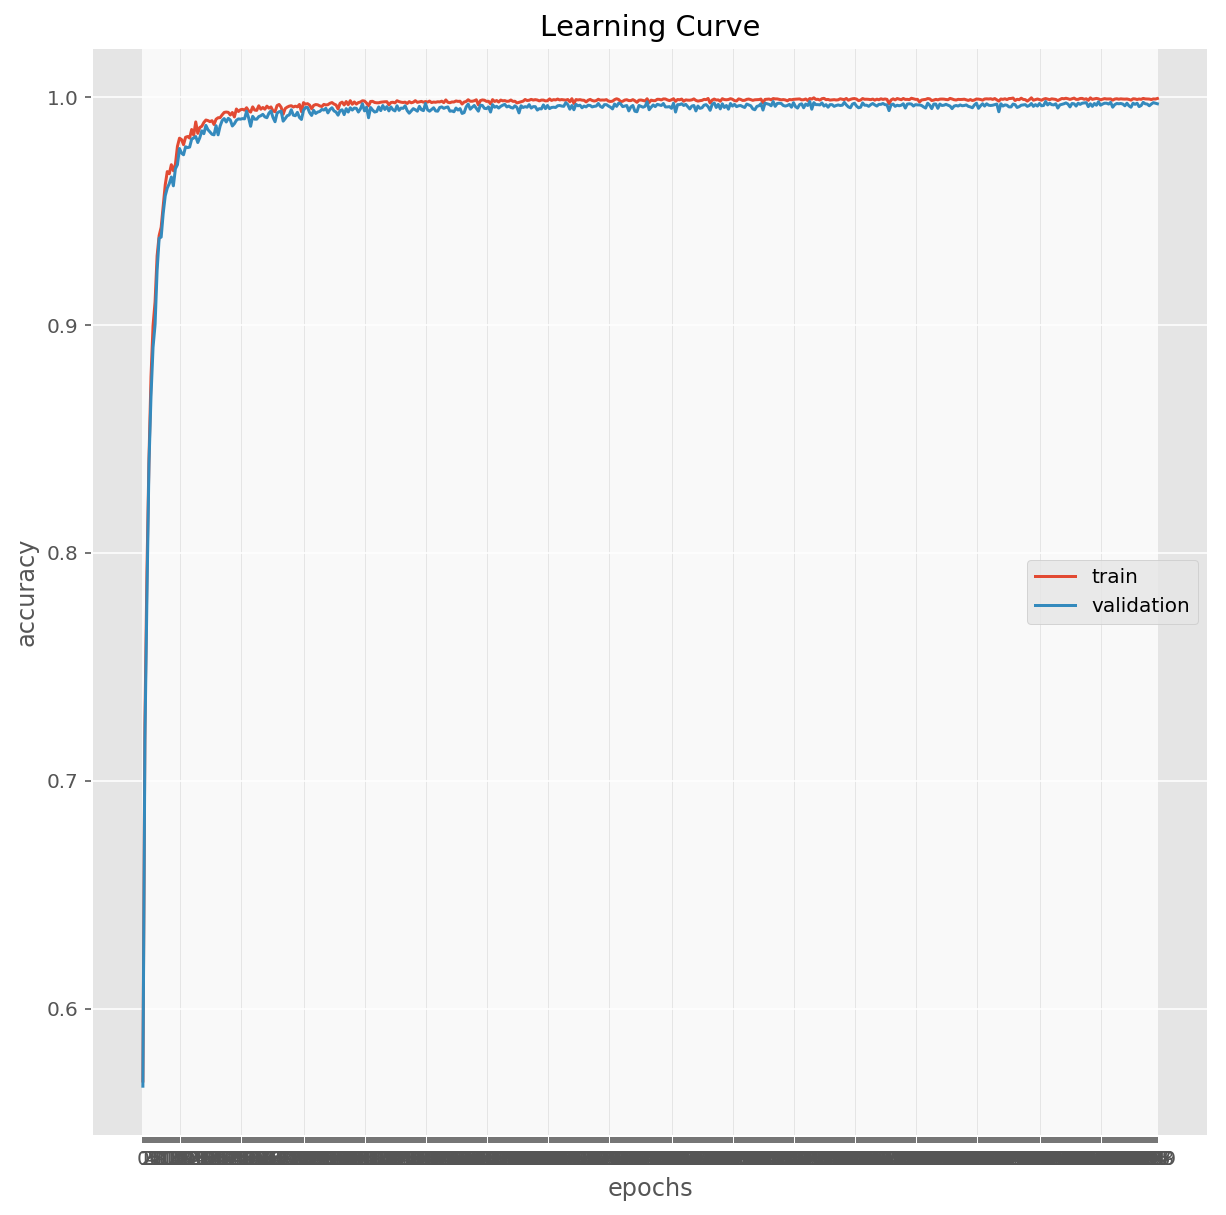

In [50]:
with Session() as session:
    pipeline = build_pipeline(preprocessors, session, make_network3(), make_adam(1.0e-4))
    learning_curve = train_evaluate(pipeline, epochs=500)
    session.save('checkpoint/network3_epochs-500_lr-1.0e-4.ckpt')    
    
show_learning_curve(learning_curve)

**Observation**:

The performance has improved.  It appears that 100 epochs are enough to achieve this performance.  

Is this as good as it can get?

## Network 10 

Can we make the network more robust?  How about a dropout?

Epoch:   0 Train Score: 0.453 Evaluation Score: 0.451
Epoch:   1 Train Score: 0.652 Evaluation Score: 0.649
Epoch:   2 Train Score: 0.750 Evaluation Score: 0.741
Epoch:   3 Train Score: 0.825 Evaluation Score: 0.822
Epoch:   4 Train Score: 0.873 Evaluation Score: 0.867
Epoch:   5 Train Score: 0.899 Evaluation Score: 0.896
Epoch:   6 Train Score: 0.923 Evaluation Score: 0.917
Epoch:   7 Train Score: 0.939 Evaluation Score: 0.936
Epoch:   8 Train Score: 0.942 Evaluation Score: 0.939
Epoch:   9 Train Score: 0.952 Evaluation Score: 0.952
Epoch:  10 Train Score: 0.959 Evaluation Score: 0.957
Epoch:  11 Train Score: 0.960 Evaluation Score: 0.956
Epoch:  12 Train Score: 0.968 Evaluation Score: 0.967
Epoch:  13 Train Score: 0.970 Evaluation Score: 0.966
Epoch:  14 Train Score: 0.975 Evaluation Score: 0.973
Epoch:  15 Train Score: 0.976 Evaluation Score: 0.977
Epoch:  16 Train Score: 0.978 Evaluation Score: 0.977
Epoch:  17 Train Score: 0.982 Evaluation Score: 0.979
Epoch:  18 Train Score: 0.98

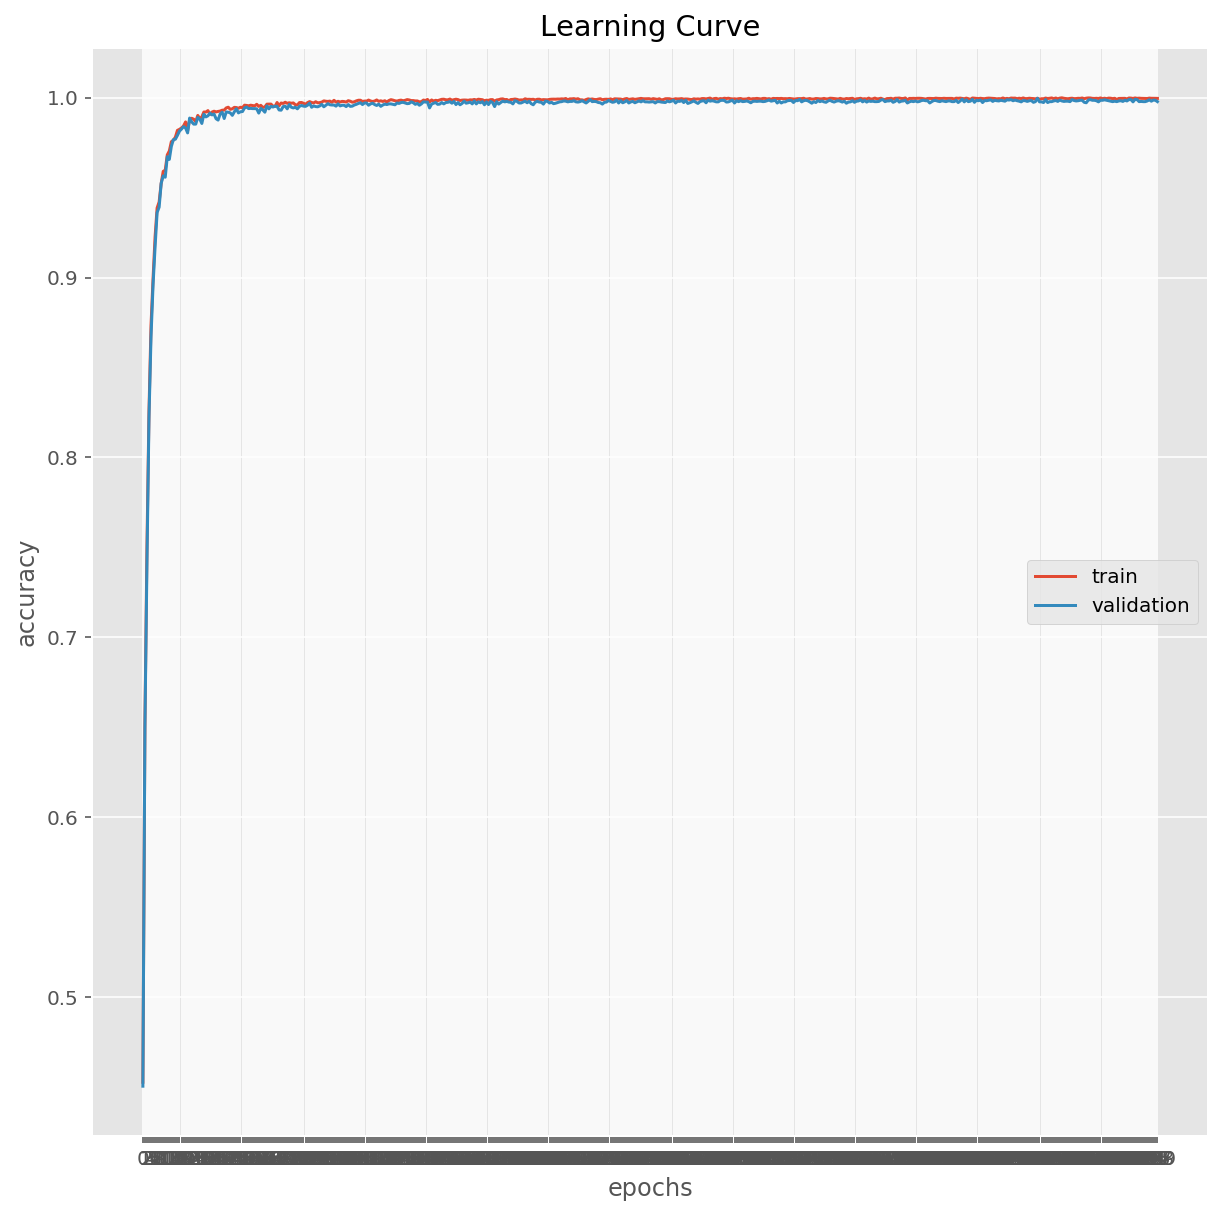

In [51]:
def make_network10(input_shape=INPUT_SHAPE):
    return (NeuralNetwork()
            .input(input_shape)
            .conv([5, 5, 24])
            .max_pool()
            .relu()
            .conv([5, 5, 64])
            .max_pool()
            .relu()
            .dropout(keep_prob=0.5)
            .flatten()
            .dense(480)
            .relu()
            .dense(N_CLASSES))

with Session() as session:
    pipeline = build_pipeline(preprocessors, session, make_network10(), make_adam(1.0e-4))
    learning_curve = train_evaluate(pipeline, epochs=500)
    session.save('checkpoint/network10.ckpt')
    
show_learning_curve(learning_curve)

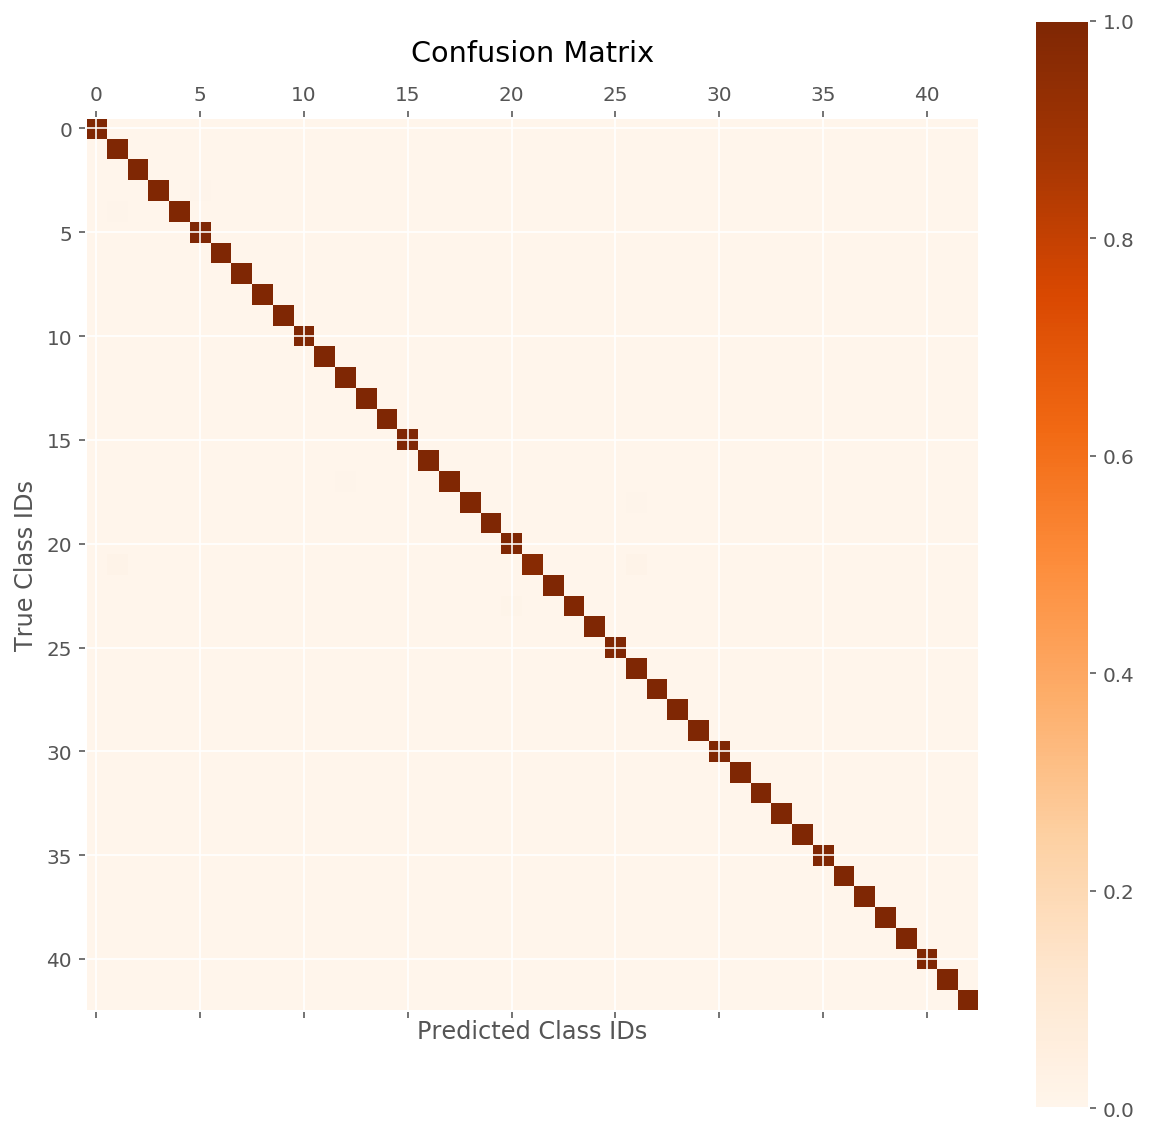

 0 Speed limit (20km/h)                               100.00%  167
 1 Speed limit (30km/h)                               100.00% 1767
 5 Speed limit (80km/h)                               100.00% 1481
 6 End of speed limit (80km/h)                        100.00%  334
 7 Speed limit (100km/h)                              100.00% 1146
10 No passing for vehicles over 3.5 metric tons       100.00% 1600
11 Right-of-way at the next intersection              100.00% 1051
12 Priority road                                      100.00% 1672
13 Yield                                              100.00% 1719
14 Stop                                               100.00%  621
15 No vehicles                                        100.00%  501
16 Vehicles over 3.5 metric tons prohibited           100.00%  334
19 Dangerous curve to the left                        100.00%  167
20 Dangerous curve to the right                       100.00%  287
22 Bumpy road                                         100.00% 

In [52]:
with Session() as session:
    pipeline = build_pipeline(preprocessors, session, make_network10())
    session.load('checkpoint/network10.ckpt')  
    pred = pipeline.predict(X_valid)
    
# examine confusionconfusion_matrixix
cm = confusion_matrix(y_valid, pred)
plot_confusion_matrix(cm)
print_confusion_matrix(cm)

**Observation**:

The validation performance is more stable now.  500 epochs is probably overkill.

## Preprocessing (Again)

These are extra experiments to see if we can improve the pipeline further.  I did experiment with these preprocessing before the network was fully trained and the effect was sort of random (sometimes good, other times bad).  As such I discarded the idea.

But I'm re-doing it to see if it has positive effect after the network is fully trained.  

The conclusion in short is that they don't work well.  This is very likely due to the network trained without them.  It seems abundantly clear in hindsight.  

The below are a series of unfortunately experiments, proving how bad idea it was to change preprocessing after the training.


### Image Enhancement

Taking a weighted average of the original image and the blurred image to make in order to smooth out the noises.

In [53]:
def enhance_image(image, ksize, weight):
    blurred = cv2.GaussianBlur(image, (ksize, ksize), 0)
    return cv2.addWeighted(image, weight, blurred, -weight, image.mean())

In [54]:
for ksize in [5, 7, 9, 11]:
    for weight in [4, 6, 8, 10]:
        print('Enhancer: k={} w={}'.format(ksize, weight))
        with Session() as session:
            enhancer = lambda x: enhance_image(x, ksize, weight)
            functions = [loader, augmenter, enhancer, normalizer]
            pipeline = build_pipeline(functions, session, make_network10())
            session.load('checkpoint/network10.ckpt')
            score = pipeline.score(X_valid, y_valid)
            print('Validation Score: {}'.format(score))
        print()

Enhancer: k=5 w=4
Validation Score: 0.708375

Enhancer: k=5 w=6
Validation Score: 0.69275

Enhancer: k=5 w=8
Validation Score: 0.67175

Enhancer: k=5 w=10
Validation Score: 0.66875

Enhancer: k=7 w=4
Validation Score: 0.793125

Enhancer: k=7 w=6
Validation Score: 0.767125

Enhancer: k=7 w=8
Validation Score: 0.755125

Enhancer: k=7 w=10
Validation Score: 0.7425

Enhancer: k=9 w=4
Validation Score: 0.823625

Enhancer: k=9 w=6
Validation Score: 0.796375

Enhancer: k=9 w=8
Validation Score: 0.77925

Enhancer: k=9 w=10
Validation Score: 0.757375

Enhancer: k=11 w=4
Validation Score: 0.87425

Enhancer: k=11 w=6
Validation Score: 0.85125

Enhancer: k=11 w=8
Validation Score: 0.8395

Enhancer: k=11 w=10
Validation Score: 0.82225



In [55]:
enhancer = lambda x: enhance_image(x, 9, 8)

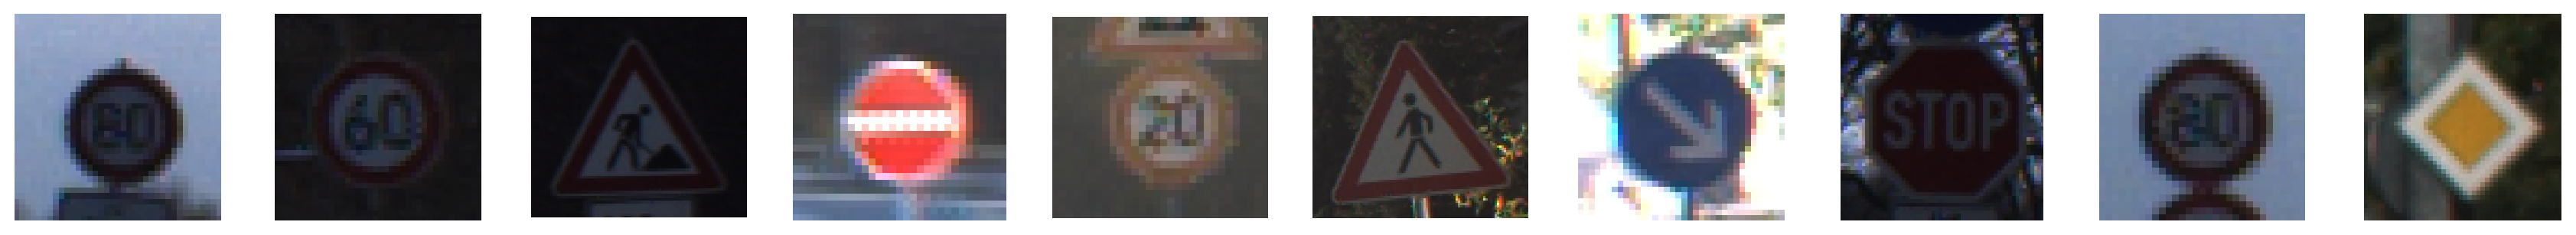

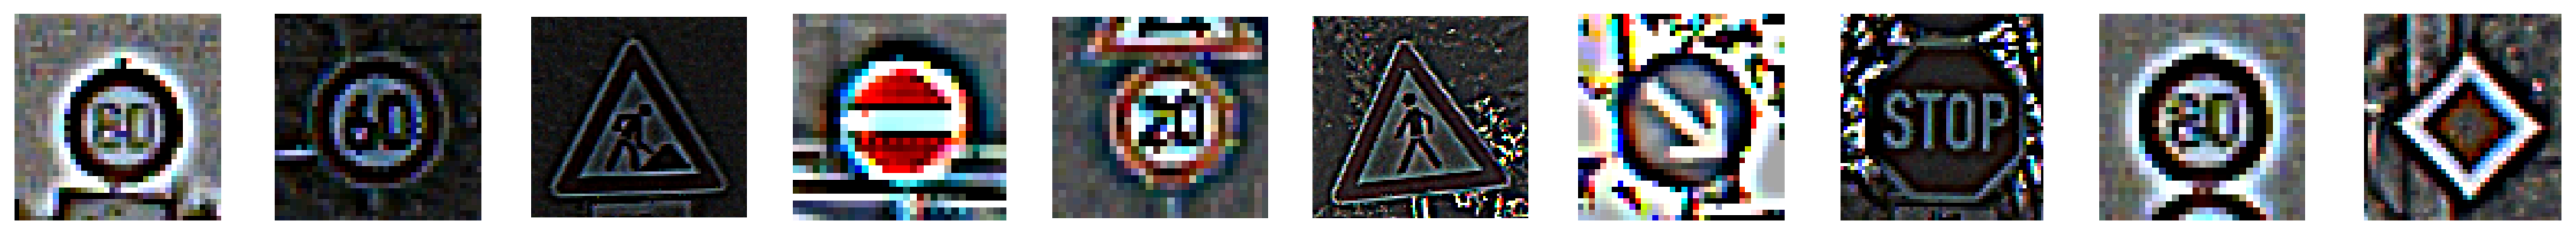

In [56]:
show_images(sample_data[10:], cols=10)
show_images(sample_data[10:], cols=10, func=enhancer)

**Observations**:

I tried these earlier and the result was pretty random.  Sometimes, it improves but not other times.  

If I do this with the pre-trained network as shown above, the result is worse as the network is already tuned for images not using the enhancements.  

Perhaps, I should try to use it during the training to see if it speed up the training or not.

However, as the network performs really well without this, my conclusion is not to use this filter at all.

## Histogram Equalizaition

In [57]:
def equalizer(image):
    image = image.copy()
    for i in range(3):
        image[:, :, i] = cv2.equalizeHist(image[:, :, i])
    return image

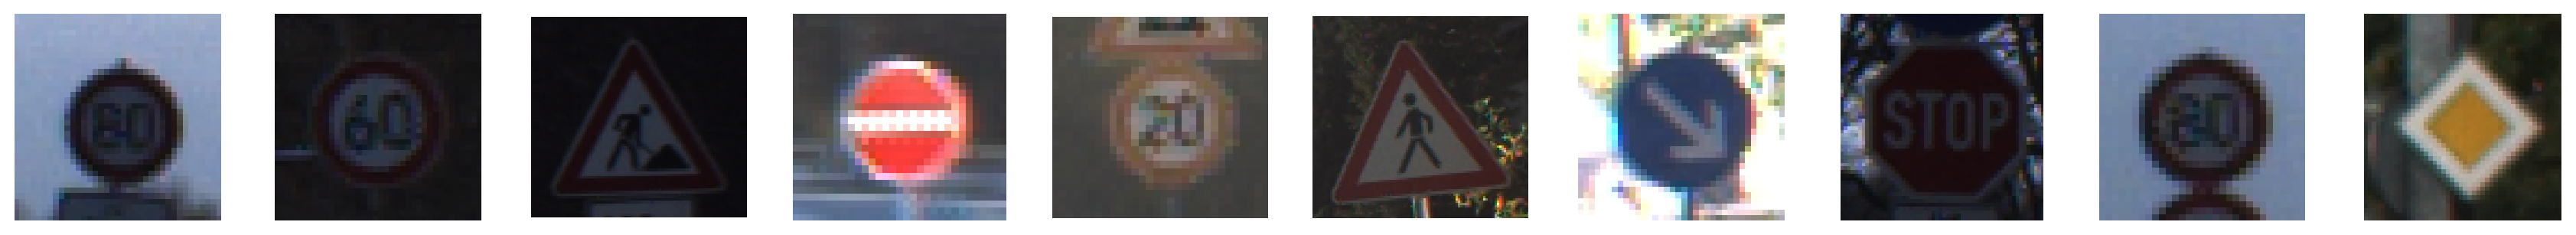

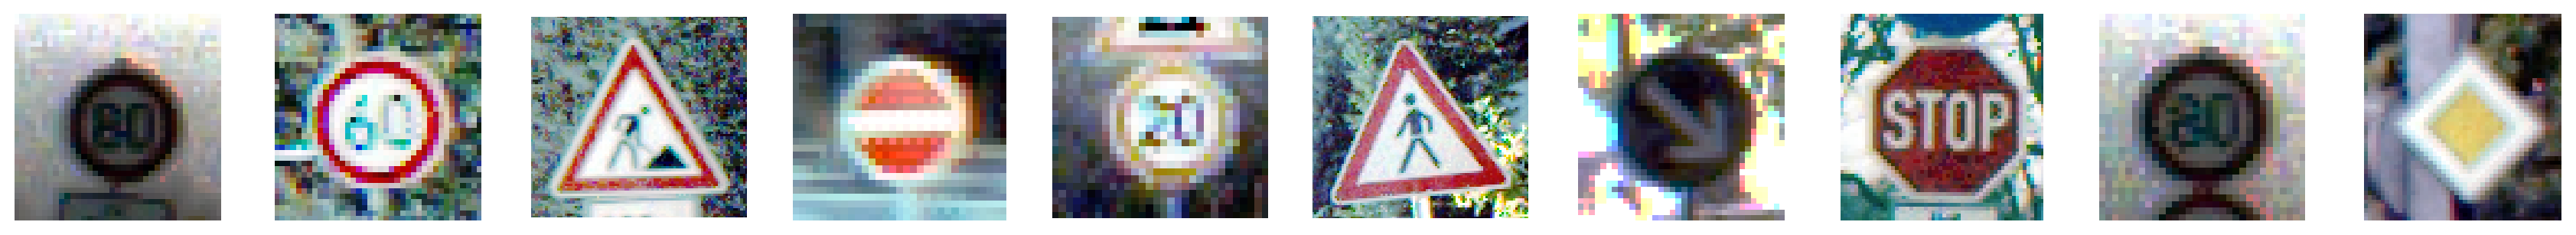

In [58]:
show_images(sample_data[10:], cols=10)
show_images(sample_data[10:], cols=10, func=equalizer)

In [59]:
with Session() as session:
    functions = [loader, augmenter, equalizer, normalizer]
    pipeline = build_pipeline(functions, session, make_network10())
    session.load('checkpoint/network10.ckpt')
    score = pipeline.score(X_valid, y_valid)
    print('Validation Score: {:.3f}'.format(score))

Validation Score: 0.904


**Observation**:

If this was tried before the network was fully trained, it might have made the learning easier.  Earlier, I played with this preprocessing before training but it was not producing better results than the enhancer.  Maybe I will re-try that one day.

How about combine the histogram equalizer and the enhancer?

In [65]:
with Session() as session:
    functions = [loader, augmenter, equalizer, enhancer, normalizer]
    pipeline = build_pipeline(functions, session, make_network10())
    session.load('checkpoint/network10.ckpt')
    score = pipeline.score(X_valid, y_valid)
    print(score)

0.67775


**Observaton**:

The histogram equalizer + enhancer does not improve.

## Min Max Normalization

http://docs.opencv.org/2.4/modules/core/doc/operations_on_arrays.html#normalize

In [62]:
def min_max_norm(image):
    return cv2.normalize(image, None, alpha=0, beta=255, norm_type=cv2.NORM_MINMAX)

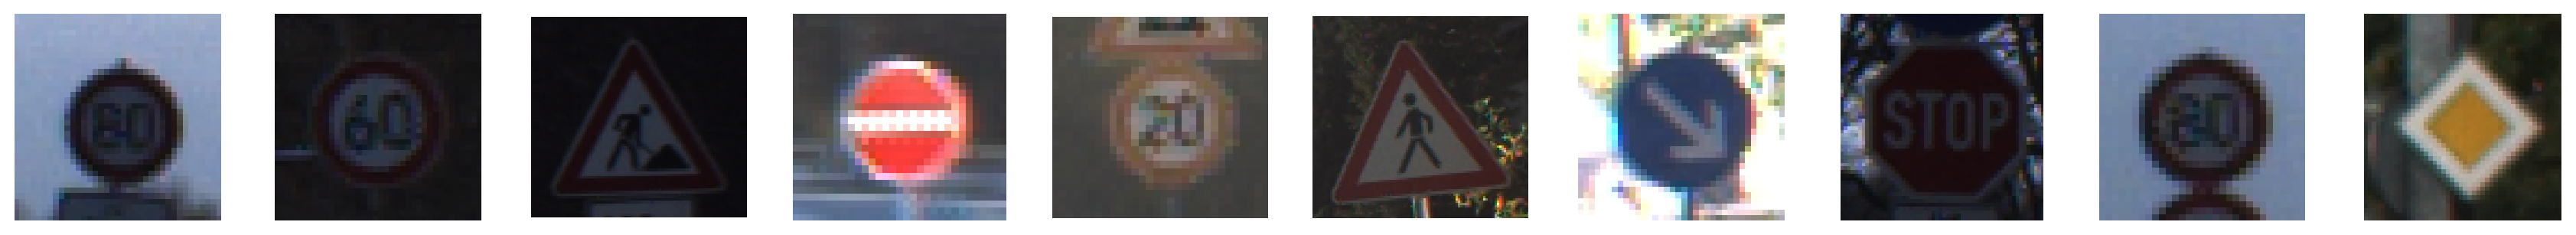

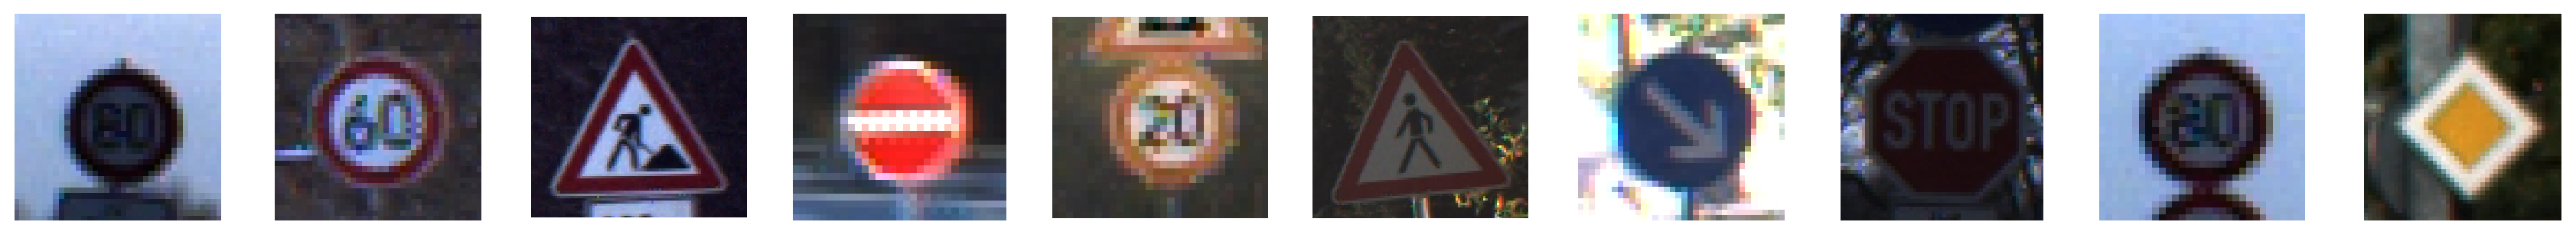

In [63]:
show_images(sample_data[10:], cols=10)
show_images(sample_data[10:], cols=10, func=min_max_norm)

In [66]:
with Session() as session:
    functions = [loader, augmenter, min_max_norm, normalizer]
    pipeline = build_pipeline(functions, session, make_network10())
    session.load('checkpoint/network10.ckpt')
    score = pipeline.score(X_valid, y_valid)
    print(score)

0.99825


**Observaton**:

I tried Min-Max normalizer before fully training the network and did not get any good results.

This experiment here is just to check if it can do any good once the network is fully trained.  It proves the otherwise.

Let's try the combination with the enhancer.

In [67]:
with Session() as session:
    functions = [loader, augmenter, min_max_norm, enhancer, normalizer]
    pipeline = build_pipeline(functions, session, make_network10())
    session.load('checkpoint/network10.ckpt')
    score = pipeline.score(X_valid, y_valid)
    print(score)

0.79925


**Observation**:

The same argument here.  I don't need this.

## Test Dataset

Test images are in one folder.  So, we can simply load them as follows:

Test images do not have category folders but all are kept in one place with one label file.

```
data
 + Final_Test
    + Images
        + 00000.ppm
        + 00001.ppm
        + ...
        + GT-final_test.csv      # Extended annotations including class ids
        + GT-final_test.test.csv
```

I also downloaded GT-final_test.csv which contains extended annotations including class ids for test images.

In [68]:
TEST_IMAGE_DIR = 'data/Final_Test/Images'

# Note: GT-final_test.csv comes with class IDs (GT-final_test.test.csv does not)
test_df = pd.read_csv(os.path.join(TEST_IMAGE_DIR, 'GT-final_test.csv'), sep=';')
test_df['Filename'] = test_df['Filename'].apply(lambda x: os.path.join(TEST_IMAGE_DIR, x))
test_df.head()

Filename  Width  Height  Roi.X1  Roi.Y1  Roi.X2  \
0  data/Final_Test/Images/00000.ppm     53      54       6       5      48   
1  data/Final_Test/Images/00001.ppm     42      45       5       5      36   
2  data/Final_Test/Images/00002.ppm     48      52       6       6      43   
3  data/Final_Test/Images/00003.ppm     27      29       5       5      22   
4  data/Final_Test/Images/00004.ppm     60      57       5       5      55   

   Roi.Y2  ClassId  
0      49       16  
1      40        1  
2      47       38  
3      24       33  
4      52       11

In [69]:
print("Number of test images: {:>5}".format(test_df.shape[0]))

Number of test images: 12630


In [70]:
X_test = test_df['Filename'].values
y_test = test_df['ClassId'].values

In [71]:
with Session() as session:
    pipeline = build_pipeline(preprocessors, session, make_network3())
    session.load('checkpoint/network10.ckpt')
    score = pipeline.score(X_test, y_test)
    print('Test Score: {}'.format(score))

Test Score: 0.958590657165479


**Observation**:

It's about 96% accuracy.  For the simple network like this one, it did a really good work.

I probably need more complex network than this one but I'd need a better hardware to train one of those.  Even with AWS g2 instance is not fast enough to run 500 epochs.

# Testing with Random Images

In [72]:
X_new = np.array(glob.glob('images/sign*.jpg') + 
                 glob.glob('images/sign*.png'))

In [73]:
new_images = [plt.imread(path) for path in X_new]

--------------------------------------------------------------------------------
New Images for Random Testing
--------------------------------------------------------------------------------


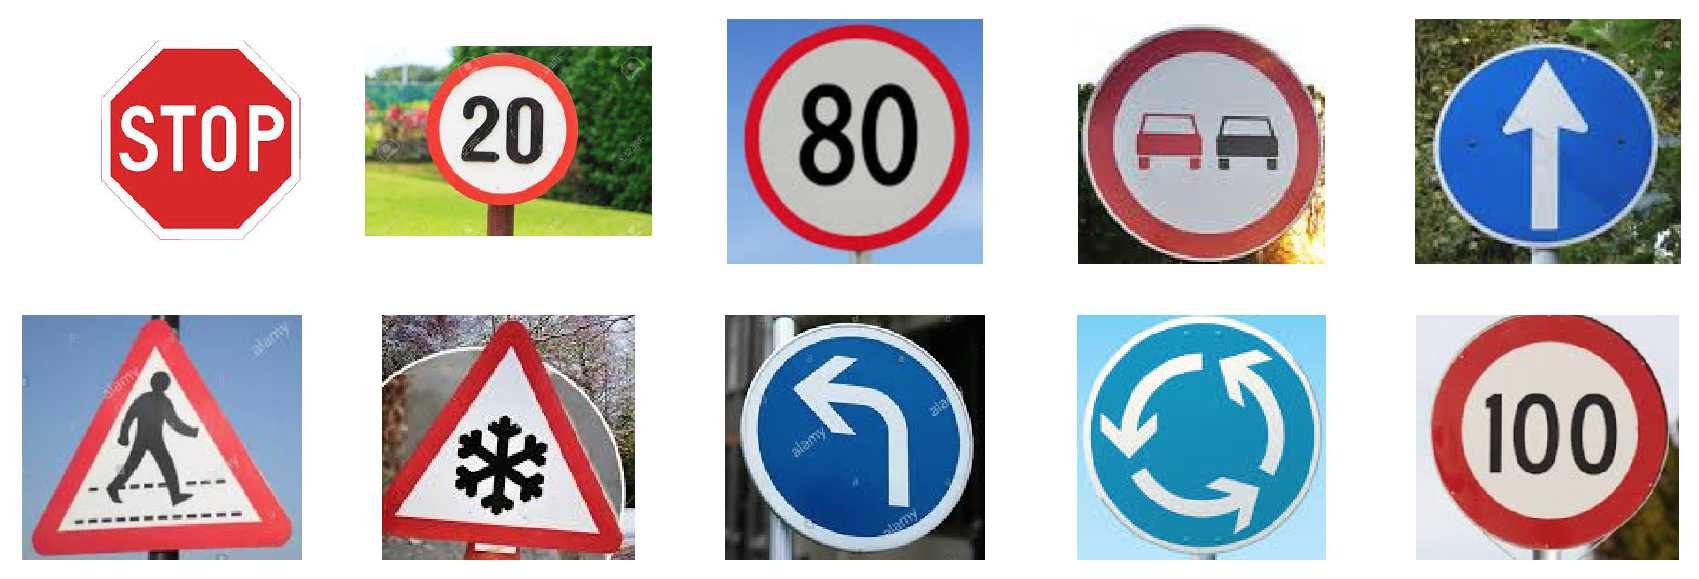

In [74]:
print('-' * 80)
print('New Images for Random Testing')
print('-' * 80)

plt.figure(figsize=(15,5))
for i, image in enumerate(new_images):
    plt.subplot(2,len(X_new)//2,i+1)
    plt.imshow(image)
    plt.xticks([])
    plt.yticks([])    
plt.show()

In [75]:
print('getting top 5 results')

with Session() as session:
    pipeline = build_pipeline(preprocessors, session, make_network3())
    session.load('checkpoint/network10.ckpt')  
    prob = pipeline.predict_proba(X_new)
    estimator = pipeline.steps[-1][1]
    top_5_prob, top_5_pred = estimator.top_k_

print('done')

getting top 5 results
done


--------------------------------------------------------------------------------
Top 5 Predictions
--------------------------------------------------------------------------------


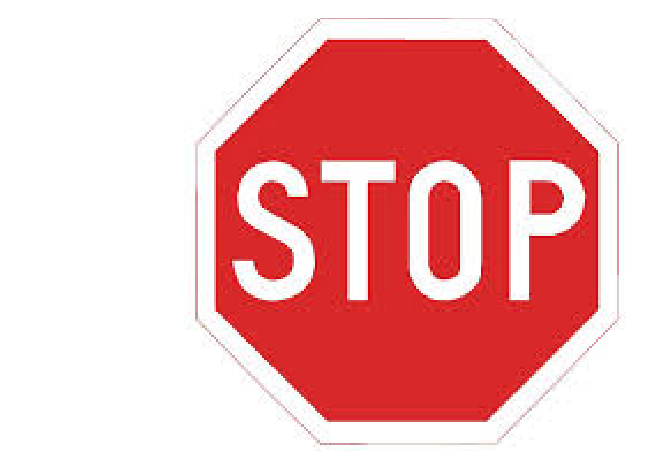

   14: Stop                                               (100.0000000000%)
   13: Yield                                              (  0.0000000000%)
    1: Speed limit (30km/h)                               (  0.0000000000%)
   12: Priority road                                      (  0.0000000000%)
   25: Road work                                          (  0.0000000000%)
--------------------------------------------------------------------------------


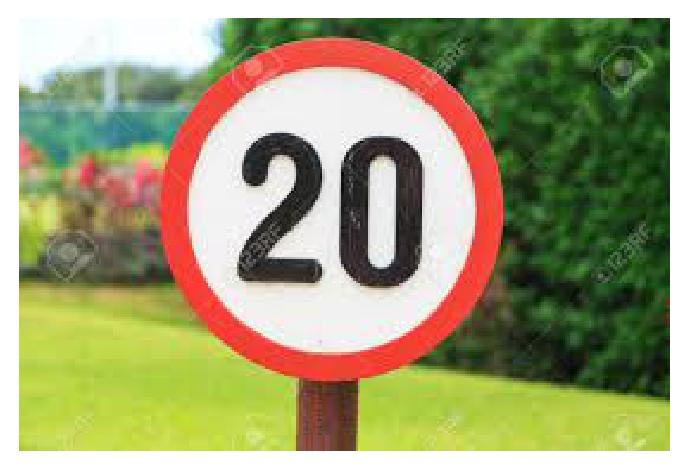

    0: Speed limit (20km/h)                               (100.0000000000%)
    4: Speed limit (70km/h)                               (  0.0000000405%)
    1: Speed limit (30km/h)                               (  0.0000000012%)
   40: Roundabout mandatory                               (  0.0000000011%)
   24: Road narrows on the right                          (  0.0000000005%)
--------------------------------------------------------------------------------


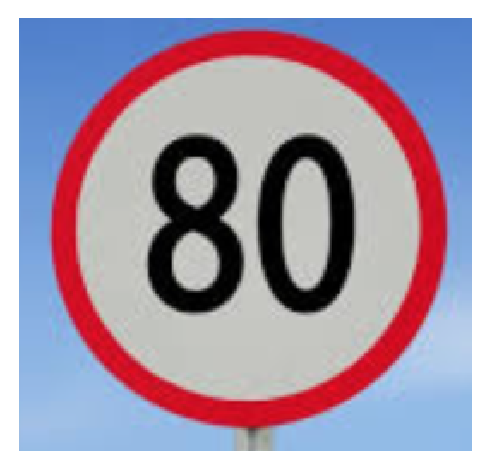

    1: Speed limit (30km/h)                               ( 99.9801933765%)
    5: Speed limit (80km/h)                               (  0.0196605557%)
    2: Speed limit (50km/h)                               (  0.0001432495%)
    6: End of speed limit (80km/h)                        (  0.0000021335%)
    3: Speed limit (60km/h)                               (  0.0000000021%)
--------------------------------------------------------------------------------


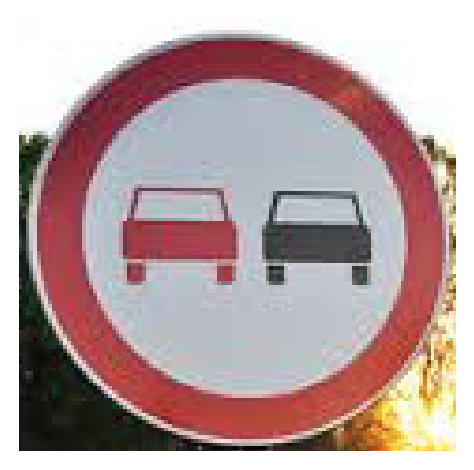

    9: No passing                                         (100.0000000000%)
   15: No vehicles                                        (  0.0000000202%)
   10: No passing for vehicles over 3.5 metric tons       (  0.0000000012%)
    3: Speed limit (60km/h)                               (  0.0000000000%)
    2: Speed limit (50km/h)                               (  0.0000000000%)
--------------------------------------------------------------------------------


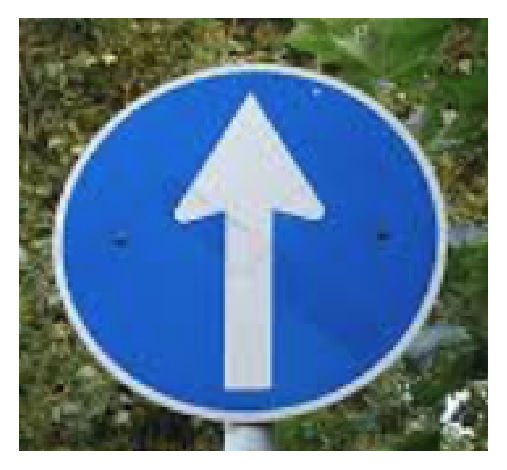

   35: Ahead only                                         (100.0000000000%)
   36: Go straight or right                               (  0.0000000000%)
   34: Turn left ahead                                    (  0.0000000000%)
   37: Go straight or left                                (  0.0000000000%)
   33: Turn right ahead                                   (  0.0000000000%)
--------------------------------------------------------------------------------


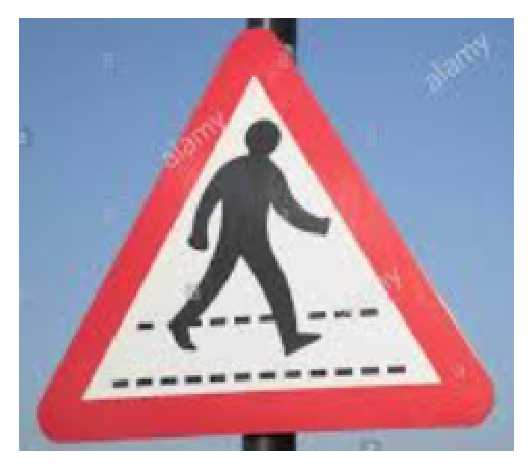

   25: Road work                                          ( 90.6243622303%)
   11: Right-of-way at the next intersection              (  8.8885203004%)
   27: Pedestrians                                        (  0.4870709963%)
   18: General caution                                    (  0.0000405782%)
   20: Dangerous curve to the right                       (  0.0000017497%)
--------------------------------------------------------------------------------


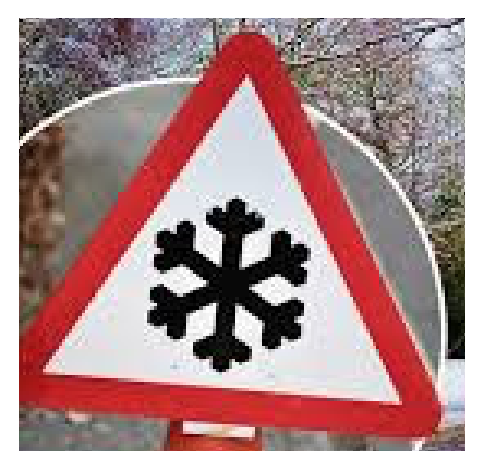

   30: Beware of ice/snow                                 ( 99.3382990360%)
   11: Right-of-way at the next intersection              (  0.6318126805%)
   21: Double curve                                       (  0.0165392499%)
   40: Roundabout mandatory                               (  0.0092216113%)
   29: Bicycles crossing                                  (  0.0038684269%)
--------------------------------------------------------------------------------


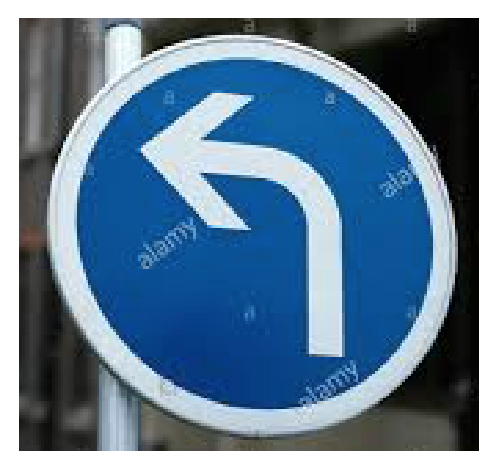

   34: Turn left ahead                                    (100.0000000000%)
   40: Roundabout mandatory                               (  0.0000000926%)
   36: Go straight or right                               (  0.0000000000%)
   35: Ahead only                                         (  0.0000000000%)
   38: Keep right                                         (  0.0000000000%)
--------------------------------------------------------------------------------


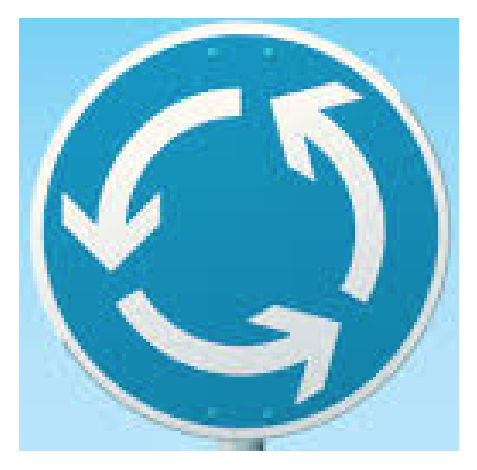

   40: Roundabout mandatory                               (100.0000000000%)
   37: Go straight or left                                (  0.0000000062%)
   34: Turn left ahead                                    (  0.0000000003%)
   38: Keep right                                         (  0.0000000000%)
   36: Go straight or right                               (  0.0000000000%)
--------------------------------------------------------------------------------


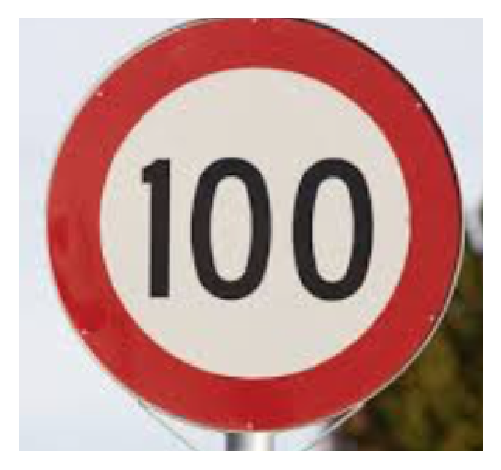

    5: Speed limit (80km/h)                               ( 99.9999761581%)
    8: Speed limit (120km/h)                              (  0.0000297359%)
    7: Speed limit (100km/h)                              (  0.0000014480%)
    1: Speed limit (30km/h)                               (  0.0000007021%)
    3: Speed limit (60km/h)                               (  0.0000000045%)
--------------------------------------------------------------------------------


In [76]:
print('-' * 80)
print('Top 5 Predictions')
print('-' * 80)

for i, (preds, probs, image) in enumerate(zip(top_5_pred, top_5_prob, new_images)):
    plt.imshow(image)
    plt.xticks([])
    plt.yticks([])
    plt.show()
    for pred, prob in zip(preds.astype(int), probs):
        sign_name = SIGN_NAMES[pred]
        print('{:>5}: {:<50} ({:>14.10f}%)'.format(pred, sign_name, prob*100.0))
    print('-' * 80)    

**Observation**:

7 out of 10 are correct.

- The pedestrian     : This is actually not German traffic sign.
- Speed limit (80km) : The model believed it was for 30km. 
- Speed limit (100km): The model believed it was for 80km.

I can understand why it did not identify the pedestrian correctly as it's not a German traffic sign.  But it's quite similar to it.  So, a human would have recognized this.  This means that the machine learned only the shapes but not the concept, which is understandable from the way convolutional neural network works.

This also means that for every country / region, we'd need to train the classifier to recognize their traffic signs.

As for the speed limits (80km and 100km), I'm thinking it is may be due to the image distortion by the resizing operation.  We may need a better way to resize images.  But this is yet to be proven at this stage.

# Conclusion

The use of pipelines were very effective during the experimentations.  In the end, the traffic sign classifier works pretty well overall with the test set.  

However, the network did not work as good with ramdom sample images from the internet.  

Moreover, if a self-driving car needs to find traffic signs in public, it first needs to know where the traffic signs are.  It's a chicken and egg problem.

Therefore, we will need an object recognition mechanism that scan across the image with sliding windows to find the candidate signs.  This kind of detection mechanism is not covered in this project.

# References:
    
- German Traffic Sign Benchmarks: http://benchmark.ini.rub.de/?section=gtsrb&subsection=dataset
- The PPM format (Portable Pixmap, P6): http://en.wikipedia.org/wiki/Netpbm_format
- LeNet Demo (Yann LeCun): http://yann.lecun.com/exdb/lenet/
- Gradient-Based Learning Applied to Document Recognition (Yann LeCun): http://yann.lecun.com/exdb/publis/pdf/lecun-98.pdf
- Udacity: Self-Driving Car Engineer: Traffic Sign Classifier Project: https://github.com/udacity/CarND-Traffic-Sign-Classifier-Project
